<a href="https://colab.research.google.com/github/kevinkorea324/ultimate-ai-investor/blob/main/notebooks/Ultimate_AI_Investor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab (Yahoo Finance Run Only)

---

# 1  Introduction  

| Item | Detail |
|------|--------|
| **Context** | Modern quant strategies increasingly rely on **multi-model pipelines** that fuse price, sentiment, and macro data. Few undergraduate studies still show the *full* workflow—data → α-generation → deployment—and remain reproducible on free cloud GPUs. |
| **Research Gap** | Prior projects often report Sharpe *or* RMSE in isolation, omit transaction costs, and skip walk-forward testing. There is no open, **Yahoo-Finance-only** reference that meets hedge-fund validation standards. |
| **Research Question** | *Can a fully open-source, deep-learning ensemble built on public Yahoo Finance OHLCV deliver Sharpe > 2 [^rq-sharpe], RMSE < 1.2 × 10⁻³ [^rq-rmse], and orderly drawdowns after realistic 10 bps costs?* |
| **Objectives** | 1. Build a **14-step modular pipeline** in Google Colab.<br>2. Ensemble TFT, GRU, LSTM, GNN, XGBoost with Bayesian HPO **(Optuna 30–50-trial prototype; full sweep 180–500 planned)**.<br>3. Evaluate on **BTC-USD, AAPL, SPX (via SPY ETF)** over **≈ 2023-06 → 2025-05** with a **180-fold walk-forward baseline (60 train / 5 test / 5 step)** **and an extended 879-fold Optuna walk-forward for hyper-parameter sweeps**, both using 10 bps costs.<br>4. Package a Dockerised FastAPI service for real-time inference. |
| **Key Contributions** | • **310-feature** library (technical, sentiment, macro, regime) → **98 survive QA**.<br>• **Current OOS mean metrics (Step 11C-2)** – code:<br>  ```python<br>  df_metrics_exec[['sharpe','sortino','max_dd']].mean()<br>  # ▶ Sharpe 1.02  Sortino 1.52  Max-DD –11.7 %<br>  ```<br>• Reproducible end-to-end in ≈ 18 min on a free Tesla T4—no paid APIs or proprietary feeds. |

---

# 2  Method  

## 2.1 Dataset & Pre-Processing (Steps 1 – 3)  

| Dimension | Current specification (Yahoo Finance only) |
|-----------|--------------------------------------------|
| **Assets** | Crypto (**BTC-USD**), US Equity (**AAPL**), Equity Index (**SPX via SPY ETF**) |
| **Frequency** | **1-hour bars**, aligned to UTC |
| **History Window** | **≈ 725 days per symbol (2023-06 → 2025-05)** |
| **Data QA** | • Drop bars where bid-ask > 3 × IQR<br>• Forward-fill ≤ 2 gaps, else flag NA |
| **Feature Library (310 → 98)** | 110 technical · 80 sentiment (VADER + finBERT) · 40 macro · 80 vol/regime |

> *Synthetic bars are used **only** for leakage unit-tests (Step 6A, Hurst-based fractal generator) and are excluded from training, validation, and metrics.*

## 2.2 Model Stack & Hyper-Parameter Search (Steps 4 – 5)  

| Model | Core Hyper-Parameters | Optuna Search Space |
|-------|----------------------|---------------------|
| **TFT** | `d_model = 128`, `n_heads = 4`, `dropout = 0.10` | `d_model` {64,128,256}; `dropout` 0.05–0.30 |
| **GRU** | 2 layers × 256 units, **Layer Norm** | `units` 128–512; `lr` 1e-4–3e-3 |
| **LSTM** | 3 layers × 128 units, recurrent dropout 0.05 | `layers` 2–4; `dropout` 0–0.30 |
| **GNN (GAT)** | 6 asset nodes, 2 attention layers | `heads` {2,4,8}; α 0.10–0.30 |
| **XGBoost** | `eta = 0.03`, `max_depth = 6`, 500 trees | `depth` 3–9; `eta` 0.01–0.10 |

*Optuna ASHA: **30–50 trials (prototype)**, median convergence ≈ 22.  
Predictions blended via **StackingRegressor → meta-XGB** (5-fold CV).*

## 2.3 Validation · Execution · Risk (Steps 6 – 11)  

* **Walk-Forward** — 180-fold baseline (60/5/5) **and** 879-fold Optuna sweep.  
* **Cost Model** — **10 bps round-trip + slippage = 5 bps mean, σ 2 bps** (ϵ ∼ 𝒩(0,(2 bps)²)).  
* **Impact** — **Almgren–Chriss** (η = 2.5 × 10⁻⁶, γ = 2.0 × 10⁻⁶).  
* **Risk Budget** — ERC or inverse-vol; dynamic Kelly scaled to 10 % annual σ.  
* **Back-test** — `vectorbt`; artefacts saved in `/output/backtests/`.

## 2.4 Explainability & Deployment (Steps 12 – 14)  

| Element | Artefact |
|---------|----------|
| **SHAP** | `shap_summary.png`, `waterfall_top10.png` |
| **LIME** | `lime_report.md` |
| **FastAPI** | `serve_fastapi.py` → `/predict?symbol=AAPL&horizon=60` |
| **Docker** | 450 MB image `ai-investor` (Gunicorn × Uvicorn) |
| **CI/CD** | GitHub Actions → `nbconvert` → MLflow registry |

---

# 3  Result  

## 3.1 Risk-Adjusted Metrics (OOS ≈ 2023-06 → 2025-05)  

| Metric | BTC-USD | AAPL | SPX\* | **Mean** |
|--------|--------:|----:|------:|---------:|
| Sharpe | 1.05 | 0.98 | *— pending* | **1.02** |
| Sortino | 1.63 | 1.40 | *— pending* | **1.52** |
| Max DD | –11.4 % | –11.9 % | *— pending* | **–11.7 %** |
| Hit Rate | 52.3 % | 52.1 % | *— pending* | **52.2 %** |

\* SPX metrics derive from SPY ETF and will populate automatically after the next end-to-end run.

## 3.2 Forecast-Error Metrics (1-h Horizon) — **Table 3-2**  

*Fold leaderboard export pending; per-model lines will be filled once `fold_metrics.csv` is saved. The meta-stack row below still uses the synthetic placeholder.*

| Model | RMSE × 10⁻³ | MAE × 10⁻³ | MAPE % | Notes |
|-------|-----------:|----------:|-------:|-------|
| Meta-Stack (OOS) | **9.80** | 7.30 | 11.1 | *placeholder; price-unit scaling pending* |

---

# 4  Discussion  

## 4.1 Interpretation  
* **Alpha drivers** – SHAP top-3: *KAMA slope*, *BTC-USD ↔ SPX GNN edge*, *CPI YoY shock*.  
* **Accuracy** – Fold-level RMSE values (export pending) indicate feature capacity; ensemble degradation stems from scale mismatch.  
* **Risk** – Dynamic Kelly caps drawdown at –11.7 % while harvesting Sharpe ≈ 1.0.

## 4.2 Limitations  
1. No level-2 order-book in Yahoo data.  
2. Hourly sentiment lag; sub-minute shocks untested.  
3. Almgren–Chriss parameters calibrated on equities; FX/index micro-structure may differ.

## 4.3 Future Work  
* Neural-SDE execution model.  
* Transformer decoder for LOBSTER imbalance.  
* Vector-valued Kelly across vol surface.  

---

[^rq-rmse]: The < 1.2 × 10⁻³ RMSE ceiling is **not yet met**; the current placeholder OOS RMSE is 9.8 × 10⁻³.  
[^rq-sharpe]: The > 2.0 Sharpe target is **not yet met**; OOS mean Sharpe is 1.02 (see aggregation code in Introduction).

# Table of Contents
- [Step&nbsp;1: Install Libraries](#step-1-install-libraries)
- [Step&nbsp;2: High-Frequency and Multi-Modal Data Expansion](#step-2-high-frequency-and-multi-modal-data-expansion)
- [Step&nbsp;3: Advanced Feature Engineering&nbsp;(Time2Vec, Fractals, KAMA)](#step-3-advanced-feature-engineering-time2vec-fractals-kama)
- [Step&nbsp;4: Advanced Model Building&nbsp;(TFT, GNN, Multi-task Learning)](#step-4-advanced-model-building-tft-gnn-multi-task-learning)
  - [Step&nbsp;4.5: Prepare Sequences from Engineered DataFrame](#step-45-prepare-sequences-from-engineered-dataframe)
- [Step&nbsp;5: Hyperparameter Optimization&nbsp;(Ray Tune)](#step-5-hyperparameter-optimization-ray-tune)
- [Step&nbsp;6: Synthetic-to-Walk-Forward Backtesting & Regime-Analysis Pipeline](#step-6-synthetic-to-walk-forward-backtesting--regime-analysis-pipeline)
  - [Step&nbsp;6A: Multi-Day Synthetic OHLCV Generator](#step-6a-multi-day-synthetic-ohlcv-generator)
  - [Step&nbsp;6B: Walk-Forward GRU Meta-Signal Generator](#step-6b-walk-forward-gru-meta-signal-generator)
  - [Step&nbsp;6C: Backtrader Integration](#step-6c-backtrader-integration)
  - [Step&nbsp;6D: Full Backtest & Optimization Pipeline&nbsp;(Optuna)](#step-6d-full-backtest--optimization-pipeline-optuna)
  - [Step&nbsp;6E: Regime Tagging & Performance Visualization](#step-6e-regime-tagging--performance-visualization)
  - [Step&nbsp;6F: Regime-Based Performance Analysis & Walk-Forward Backtest](#step-6f-regime-based-performance-analysis--walk-forward-backtest)
  - [Step&nbsp;6G: Gaussian HMM Market-Regime Detection](#step-6g-gaussian-hmm-market-regime-detection)
- [Step&nbsp;7: Real Historical Market Data Integration](#step-7-real-historical-market-data-integration)
  - [Step&nbsp;7A: Fetch Historical Data&nbsp;(Yahoo Finance)](#step-7a-fetch-historical-data-yahoo-finance)
  - [Step&nbsp;7B: Data-Quality Validation & EDA](#step-7b-data-quality-validation--eda)
  - [Step&nbsp;7C-1: Historical Data Preparation for Modelling](#step-7c-1-historical-data-preparation-for-modelling)
  - [Step&nbsp;7C-2: Add Overnight-Gap Features](#step-7c-2-add-overnight-gap-features)
- [Step&nbsp;8: Alternative Data Integration](#step-8-alternative-data-integration)
  - [Step&nbsp;8A: Twitter Sentiment Analysis](#step-8a-twitter-sentiment-analysis)
  - [Step&nbsp;8B: News Sentiment via NLP](#step-8b-news-sentiment-via-nlp)
  - [Step&nbsp;8C: Macroeconomic Indicators Integration&nbsp;(FRED)](#step-8c-macroeconomic-indicators-integration-fred)
  - [Step&nbsp;8D: Google Trends Feature Engineering](#step-8d-google-trends-feature-engineering)
- [Step&nbsp;9: Advanced Validation – Walk-Forward Testing](#step-9-advanced-validation--walk-forward-testing)
  - [Step&nbsp;9A: Implement Walk-Forward Validation](#step-9a-implement-walk-forward-validation)
  - [Step&nbsp;9B: Rolling-Window Retraining & Hyperparameter Optimization](#step-9b-rolling-window-retraining--hyperparameter-optimization)
- [Step&nbsp;10: Robust Execution & Risk Modeling](#step-10-robust-execution--risk-modeling)
  - [Step&nbsp;10A: Transaction Cost & Slippage Modeling](#step-10a-transaction-cost--slippage-modeling)
  - [Step&nbsp;10B: Market Impact Modeling (Almgren–Chriss)](#step-10b-market-impact-modeling-almgrenchriss)
- [Step&nbsp;11: Advanced Portfolio & Risk Management](#step-11-advanced-portfolio--risk-management)
  - [Step&nbsp;11A-1: Dynamic Position Sizing](#step-11a-1-dynamic-position-sizing)
  - [Step&nbsp;11A-Plus: Dynamic Sizing (Kelly 0.5 × + Vol-Target)](#step-11a-plus-dynamic-sizing-kelly-05--vol-target)
  - [Step&nbsp;11B-1: Diversification & Risk-Parity Construction](#step-11b-1-diversification--risk-parity-construction)
  - [Step&nbsp;11B-2: Risk-Parity Portfolio Diagnostics & Plot](#step-11b-2-risk-parity-portfolio-diagnostics--plot)
  - [Step&nbsp;11B-Plus: Re-fit / Metrics / Comparison](#step-11b-plus-re-fit--metrics--comparison)
  - [Step&nbsp;11C-1: Dynamic Position Sizing (Extended)](#step-11c-1-dynamic-position-sizing-extended)
  - [Step&nbsp;11C-2: **Risk-Parity Pro** – Institutional Engine](#step-11c-2-risk-parity-pro--institutional-engine)
- [Step&nbsp;12: Explainability & Interpretability (XAI)](#step-12-explainability--interpretability-xai)
  - [Step&nbsp;12A-1: SHAP Feature Importance (robust)](#step-12a-1-shap-feature-importance-robust)
  - [Step&nbsp;12A-2: Production-Ready SHAP](#step-12a-2-production-ready-shap)
  - [Step&nbsp;12A-3: SHAP (Lag-Safe / Version-Safe)](#step-12a-3-shap-lag-safe--version-safe)
  - [Step&nbsp;12B-1: LIME for Signal Explanation](#step-12b-1-lime-for-signal-explanation)
  - [Step&nbsp;12B-2: LIME Local Explanations (CPU-Safe)](#step-12b-2-lime-local-explanations-cpu-safe)
- [Step&nbsp;13: Ensemble & Meta-Modeling](#step-13-ensemble--meta-modeling)
  - [Step&nbsp;13A-1: Multi-Model Ensemble](#step-13a-1-multi-model-ensemble)
  - [Step&nbsp;13A-2: Multi-Model Ensemble&nbsp;(Patched)](#step-13a-2-multi-model-ensemble-patched)
  - [Step&nbsp;13B-1: Meta-Model Stacking (RMSE-Safe)](#step-13b-1-meta-model-stacking-rmse-safe)
  - [Step&nbsp;13B-2: Meta-Model Stacking with Optuna & Sharpe](#step-13b-2-meta-model-stacking-with-optuna--sharpe)
- [Step&nbsp;14: Advanced Deployment Infrastructure](#step-14-advanced-deployment-infrastructure)
  - [Step&nbsp;14A: build_bundle.py](#step-14a-build_bundlepy)
  - [Step&nbsp;14B: Real-Time Prediction Pipeline](#step-14b-real-time-prediction-pipeline)
  - [Step&nbsp;14C: Automated Model Deployment & Scaling](#step-14c-automated-model-deployment--scaling)

# TensorFlow GPU Check

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available: 1


# NVIDIA-SMI GPU Info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 31 00:33:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             47W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Matplotlib Inline Setup

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("Agg")  # Prevents some rendering issues in Colab
from IPython.display import display, Image

In [2]:
!pwd          # shows current directory (usually /content)
!ls -1 *.ipynb

/content
ls: cannot access '*.ipynb': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# A. Typical Colab folder
!ls "/content/drive/MyDrive/Colab Notebooks" | grep -i .ipynb

2022-06-29ipynb.ipynb
6.15일 파이썬 숙제.ipynb
 6.24일 복습 및 숙제.ipynb
6.29일 숙제.ipynb
BPM per minute.ipynb
c to f.ipynb
Currently working on it right now.ipynb
GRU_Attn_XGB_Fixed_Final.ipynb
GRU_LSTM_Transformer_NextGen_Ultimate_Investor.ipynb
matplotlib.ipynb
Ultimate_AI_Investor_MinimalColab_ColabFixed (1).ipynb
Ultimate_AI_Investor_MinimalColab_ColabFixed.ipynb
Ultimate_AI_Investor_MinimalColab_FinalWorking.ipynb
Ultimate_AI_Investor_MinimalColab_NoErrors.ipynb
Ultimate AI Investor Multi-Model Alpha Generation Using Market, Sentiment, and Macroeconomic Signals (Taehun Kim).ipynb
Ultimate AI Investor Multi-Model Alpha Generation Using Market, Sentiment, and Macroeconomic Signals (Taehun Kim).ipynb의 사본
Ultimate AI Investor Multi-Model Alpha Generation Using Market, Sentiment, and Macroeconomic Signals (Taehun Kim).ipynb의 사본 (1)
Ultimate AI Investor Multi-Model Alpha Generation Using Market, Sentiment, and Macroeconomic Signals (Taehun Kim).ipynb의 사본의 사본

In [5]:
# B. If you keep it elsewhere, list everything under MyDrive
!find /content/drive/MyDrive -maxdepth 2 -type f -name "*.ipynb" | head -20

/content/drive/MyDrive/Colab Notebooks/Ultimate AI Investor Multi-Model Alpha Generation Using Market, Sentiment, and Macroeconomic Signals (Taehun Kim).ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled0.ipynb
/content/drive/MyDrive/Colab Notebooks/BPM per minute.ipynb
/content/drive/MyDrive/Colab Notebooks/6.15일 파이썬 숙제.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled1.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled2.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled3.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled5.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled4.ipynb
/content/drive/MyDrive/Colab Notebooks/c to f.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled6.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled8.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled7.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled9.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled10.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled11.ipynb


In [6]:
import nbformat, pathlib

# paste the full path you just found
nb_path = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Ultimate AI Investor Multi-Model Alpha Generation Using Market, Sentiment, and Macroeconomic Signals (Taehun Kim).ipynb")

nb = nbformat.read(nb_path.open('r', encoding='utf-8'), as_version=4)

# Remove invalid widget metadata
nb.metadata.pop("widgets", None)
for cell in nb.cells:
    cell.metadata.pop("widgets", None)

nbformat.write(nb, nb_path.open('w', encoding='utf-8'))
print("cleaned:", nb_path)

cleaned: /content/drive/MyDrive/Colab Notebooks/Ultimate AI Investor Multi-Model Alpha Generation Using Market, Sentiment, and Macroeconomic Signals (Taehun Kim).ipynb


# Step 1 : Install Libraries

In [ ]:
import subprocess

subprocess.call(["pip", "install", "-q",
    "numpy", "pandas", "scikit-learn", "xgboost", "lightgbm", "ta",
    "tensorflow", "torch", "autokeras",
    "ray[tune]", "optuna", "backtrader", "pypfopt",
    "fastapi", "uvicorn",
    "shap", "statsmodels",
    "yfinance",          # Load AAPL, BTC-USD etc.
    "ccxt",              # Binance, Coinbase, Kraken (real crypto data)
    "matplotlib",        # Plotting equity curves
    "matplotlib-inline", # Smooth notebook plots
    "ipykernel",         # Jupyter compatibility
    "nbformat",          # Notebook formatting (for export/save)
])

1

# Step 2 : High-Frequency and Multi-Modal Data Expansion

In [ ]:
# Install missing package
!pip install hmmlearn

# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

# Generate Minute-Level Intraday Timestamps (NYSE)
intraday_times = pd.date_range(start="2024-01-01 09:30", end="2024-01-01 16:00", freq="1min")
intraday_data = pd.DataFrame(index=intraday_times)

# Synthetic Price Generation (GARCH-style)
np.random.seed(42)
mu, sigma = 0, 0.15
shock = np.random.normal(mu, sigma, len(intraday_data))
volatility = np.zeros(len(intraday_data))
volatility[0] = 0.2
for t in range(1, len(intraday_data)):
    volatility[t] = 0.9 * volatility[t-1] + 0.1 * np.abs(shock[t])
returns = shock * volatility
price = 100 + np.cumsum(returns)

intraday_data['Open'] = price
intraday_data['High'] = price + np.abs(np.random.normal(0, 0.2, len(price)))
intraday_data['Low'] = price - np.abs(np.random.normal(0, 0.2, len(price)))
intraday_data['Close'] = price + np.random.normal(0, 0.05, len(price))
intraday_data['Volume'] = np.random.randint(200, 1500, len(price))

# Macro & Sentiment Features
news_trend = np.linspace(-1, 1, len(intraday_data))
news_noise = np.random.normal(0, 0.2, len(intraday_data))
intraday_data['news_sentiment'] = (news_trend + news_noise).cumsum() / np.arange(1, len(intraday_data)+1)

macro_base = np.sin(np.linspace(0, 10 * np.pi, len(intraday_data)))
macro_spike = np.zeros(len(intraday_data))
for idx in [60, 180, 300]:
    macro_spike[idx:idx+5] = np.linspace(1.0, 0.2, 5) + np.random.normal(0, 0.05, 5)
intraday_data['macro_shock'] = macro_base + macro_spike

# Time Features
intraday_data['minute'] = intraday_data.index.minute
intraday_data['hour'] = intraday_data.index.hour
intraday_data['time_block'] = pd.cut(
    intraday_data.index.hour + intraday_data.index.minute / 60,
    bins=[9.5, 11, 13, 15, 16],
    labels=["Open", "LateMorning", "Afternoon", "Close"],
    include_lowest=True
)

# Microstructure Features
intraday_data['order_imbalance'] = np.tanh(np.random.normal(0, 0.5, len(intraday_data)))
intraday_data['queue_imbalance'] = np.clip(np.random.beta(2, 5, len(intraday_data)) * 2 - 1, -1, 1)

# Cointegration Z-Score with Sector ETF
intraday_data['sector_etf'] = intraday_data['Close'] * (1 + np.random.normal(0, 0.01, len(intraday_data)))
spread = intraday_data['Close'] - 0.98 * intraday_data['sector_etf']
intraday_data['cointegration_zscore'] = (spread - spread.rolling(30).mean()) / (spread.rolling(30).std() + 1e-6)

# Return and Volatility Metrics
intraday_data['log_return'] = np.log(intraday_data['Close']).diff()
intraday_data['realized_vol_5'] = intraday_data['Close'].pct_change().rolling(5).std()
intraday_data['realized_vol_15'] = intraday_data['Close'].pct_change().rolling(15).std()

# Hurst Exponent
def hurst(ts):
    lags = range(2, 20)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    return np.polyfit(np.log(lags), np.log(tau), 1)[0]
intraday_data['hurst_60'] = intraday_data['Close'].rolling(60).apply(hurst, raw=True)

# EMA Regime Residual
intraday_data['ema_fast'] = intraday_data['Close'].ewm(span=5).mean()
intraday_data['ema_slow'] = intraday_data['Close'].ewm(span=30).mean()
intraday_data['regime_residual'] = intraday_data['Close'] - intraday_data['ema_slow']

# Target Label (Future Return)
intraday_data['future_return'] = intraday_data['Close'].shift(-5) / intraday_data['Close'] - 1
intraday_data['alpha_label'] = (intraday_data['future_return'] > 0).astype(int)

# Lagged Features
for lag in [1, 3, 5]:
    intraday_data[f'return_lag_{lag}'] = intraday_data['log_return'].shift(lag)
    intraday_data[f'vol_lag_{lag}'] = intraday_data['realized_vol_5'].shift(lag)

# Explainability Buckets
intraday_data['vol_bucket'] = pd.qcut(intraday_data['realized_vol_5'], 3, labels=["LowVol", "MedVol", "HighVol"])
intraday_data['zscore_bucket'] = pd.qcut(intraday_data['cointegration_zscore'], 3, labels=["MeanRev", "Neutral", "Diverged"])

# Peer Asset Features
peer_price = price * (1 + np.random.normal(0, 0.005, len(price)))
peer_df = pd.DataFrame(index=intraday_times)
peer_df['peer_close'] = peer_price
peer_df['peer_volume'] = np.random.randint(300, 1600, len(price))
intraday_data = intraday_data.join(peer_df)

# Normalize Selected Features
scaler = StandardScaler()
cols_to_normalize = [
    'news_sentiment', 'macro_shock', 'order_imbalance', 'queue_imbalance',
    'cointegration_zscore', 'realized_vol_5', 'realized_vol_15',
    'hurst_60', 'regime_residual', 'return_lag_1', 'return_lag_3', 'return_lag_5',
    'vol_lag_1', 'vol_lag_3', 'vol_lag_5'
]
intraday_data[cols_to_normalize] = scaler.fit_transform(intraday_data[cols_to_normalize])

# Hidden Markov Model (Market Regime Classification)
hmm_input = intraday_data[['log_return', 'realized_vol_5']].dropna()
hmm_model = GaussianHMM(n_components=3, n_iter=100)
hmm_model.fit(hmm_input)
intraday_data['market_regime'] = np.nan
intraday_data.loc[hmm_input.index, 'market_regime'] = hmm_model.predict(hmm_input)
intraday_data['market_regime'] = intraday_data['market_regime'].ffill()
intraday_data['market_regime'] = intraday_data['market_regime'].bfill()

# Lead-Lag Feature
intraday_data['peer_lag_1'] = intraday_data['peer_close'].shift(1)
intraday_data['lead_lag_return'] = intraday_data['peer_lag_1'] / intraday_data['Close'] - 1
intraday_data.dropna(subset=['peer_close', 'peer_lag_1', 'lead_lag_return'], inplace=True)

# Entropy Estimation
def rolling_entropy(series, window=20):
    binned = pd.qcut(series.dropna(), q=5, labels=False, duplicates='drop')
    return binned.rolling(window).apply(lambda x: -np.sum(pd.Series(x).value_counts(normalize=True) *
                                                          np.log(pd.Series(x).value_counts(normalize=True) + 1e-9)))
intraday_data['return_entropy'] = rolling_entropy(intraday_data['log_return'])

# Interaction Terms
intraday_data['zscore_x_vol'] = intraday_data['cointegration_zscore'] * intraday_data['realized_vol_5']
intraday_data['shock_x_sent'] = intraday_data['macro_shock'] * intraday_data['news_sentiment']

# Feature Stability Index
feature_std = intraday_data[cols_to_normalize].rolling(60).std()
feature_mean = intraday_data[cols_to_normalize].rolling(60).mean()
intraday_data['feature_stability_index'] = (feature_std / (feature_mean + 1e-9)).mean(axis=1)
entropy_cols = ['return_entropy', 'zscore_x_vol', 'shock_x_sent', 'feature_stability_index']
intraday_data[entropy_cols] = intraday_data[entropy_cols].ffill()
intraday_data.dropna(subset=entropy_cols, inplace=True)

# Cleanup and Preview
intraday_data.dropna(inplace=True)  # Final cleanup before Step 4

# Define only columns that actually exist in the DataFrame
min_required_features = [
    col for col in [
        'KAMA', 'KAMA_signal', 'fractal_signal',
        'realized_vol_5_vol_rolling', 'log_return_vol_rolling'
    ] if col in intraday_data.columns
]

# Drop rows that have NaNs in those existing features
intraday_data = intraday_data.dropna(subset=min_required_features)
print(intraday_data.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 12.0 MB/s eta 0:00:00
                          Open        High        Low      Close  Volume  \
2024-01-01 10:30:00  99.832834  100.023862  99.608289  99.961819     760   
2024-01-01 10:31:00  99.830161  100.027307  99.753679  99.789978    1159   
2024-01-01 10:32:00  99.813075   99.913885  99.779785  99.895031     231   
2024-01-01 10:33:00  99.793229   99.899281  99.694739  99.877114     590   
2024-01-01 10:34:00  99.806847   99.965422  99.749013  99.779168     476   

                     news_sentiment  macro_shock  minute  hour time_block  \
2024-01-01 10:30:00       -1.188420    -0.131632      30    10       Open   
2024-01-01 10:31:00       -1.165064    -0.379678      31    10       Open   
2024-01-01 10:32:00       -1.135466    -0.652696      32    10       Open   
2024-01-01 10:33:00       -1.131620    -0.768226      33    10       Open   
2024-01-01 10:34:00       -1.123252    -1.012494      34    10       Open   


# Step 3 : Advanced Feature Engineering (Time2Vec, Fractals, KAMA)

In [ ]:
# Advanced Feature Engineering (corrected & stable)

# Dependencies
!pip install -q tensorflow scikit-learn hmmlearn

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from hmmlearn.hmm import GaussianHMM

# Synthetic intraday OHLC
np.random.seed(42)
times = pd.date_range("2024-01-02 09:30", periods=390, freq="1min")
df = pd.DataFrame(index=times)
df["Close"] = 100 + np.cumsum(np.random.normal(0, 0.2, size=390))
df["High"]  = df["Close"] + np.random.normal(0.1, 0.05, 390)
df["Low"]   = df["Close"] - np.random.normal(0.1, 0.05, 390)
df["Open"]  = df["Close"].shift(1).fillna(df["Close"])

# Time2Vec encoding
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, k=4):
        super().__init__()
        self.k = k  # number of periodic terms

    def build(self, input_shape):
        self.wb = self.add_weight(name="wb", shape=(1,), initializer="uniform")
        self.bb = self.add_weight(name="bb", shape=(1,), initializer="uniform")
        self.wa = self.add_weight(
            name="wa", shape=(input_shape[-1], self.k), initializer="uniform"
        )
        self.ba = self.add_weight(name="ba", shape=(self.k,), initializer="uniform")

    def call(self, inputs):
        bias = self.wb * inputs + self.bb
        wgts = tf.math.sin(tf.matmul(inputs, self.wa) + self.ba)
        return tf.concat([bias, wgts], axis=-1)

time_vals   = np.arange(len(df)).reshape(-1, 1)
time_scaled = MinMaxScaler().fit_transform(time_vals)

t2v_layer = Time2Vec(k=4)
t2v_out   = t2v_layer(tf.convert_to_tensor(time_scaled, dtype=tf.float32)).numpy()

for i in range(t2v_out.shape[1]):
    df[f"t2v_{i}"] = t2v_out[:, i]

df["sin_time"] = np.sin(2 * np.pi * time_scaled.flatten())
df["cos_time"] = np.cos(2 * np.pi * time_scaled.flatten())

# Fractal features
df["fractal_up"] = (
    (df["High"].shift(2) < df["High"].shift(1)) &
    (df["High"].shift(1) > df["High"])          &
    (df["High"].shift(1) > df["High"].shift(3)) &
    (df["High"].shift(1) > df["High"].shift(4))
).astype(int)

df["fractal_down"] = (
    (df["Low"].shift(2)  > df["Low"].shift(1))  &
    (df["Low"].shift(1)  < df["Low"])           &
    (df["Low"].shift(1)  < df["Low"].shift(3))  &
    (df["Low"].shift(1)  < df["Low"].shift(4))
).astype(int)

df["fractal_signal"]   = df["fractal_up"] - df["fractal_down"]
df["fractal_rolling"]  = df["fractal_signal"].rolling(10).sum()
df["fractal_momentum"] = df["fractal_rolling"].diff()

# KAMA features
def kama(df, window=10, fast=2/(2+1), slow=2/(30+1)):
    close = df["Close"].dropna()
    direction   = close.diff(window).abs()
    volatility  = close.diff().abs().rolling(window).sum()
    er = direction / (volatility + 1e-8)
    sc = (er * (fast - slow) + slow).fillna(slow) ** 2

    kama_vals = [close.iloc[0]]
    for i in range(1, len(close)):
        kama_vals.append(kama_vals[-1] + sc.iloc[i] * (close.iloc[i] - kama_vals[-1]))

    kama_series           = pd.Series(kama_vals, index=close.index)
    df["KAMA"]            = kama_series.reindex(df.index).ffill()
    df["KAMA_residual"]   = df["Close"] - df["KAMA"]
    df["KAMA_pct_dev"]    = df["KAMA_residual"] / df["KAMA"]
    df["KAMA_slope"]      = df["KAMA"].diff()
    df["KAMA_signal"]     = np.sign(df["KAMA_residual"]) * (df["KAMA_residual"].abs() > 0.1).astype(int)
    return df

df = kama(df)

# Volatility & regime residuals
df["log_return"]      = np.log(df["Close"]).diff()
df["realized_vol_5"]  = df["Close"].pct_change().rolling(5).std()
df["regime_residual"] = df["Close"] - df["Close"].ewm(span=30).mean()

# Future-return target & rolling stats
df["future_return"] = df["Close"].shift(-5) / df["Close"] - 1

for feat in ["log_return", "realized_vol_5", "regime_residual"]:
    df[f"{feat}_vol_rolling"] = df[feat].rolling(20).std()
    df[f"{feat}_zscore"]      = (
        df[feat] - df[feat].rolling(20).mean()
    ) / (df[feat].rolling(20).std() + 1e-8)

df["vol_regime"]  = pd.qcut(df["realized_vol_5"].dropna(), 3, labels=["Low", "Medium", "High"])
df["meta_signal"] = df["fractal_signal"] + df["KAMA_signal"]

# Rolling entropy
def rolling_entropy(series, window=30):
    binned = pd.qcut(series.dropna(), 5, labels=False, duplicates="drop")
    return binned.rolling(window).apply(
        lambda x: -np.sum(pd.Series(x).value_counts(normalize=True) *
                          np.log(pd.Series(x).value_counts(normalize=True) + 1e-9))
    )

df["kama_entropy"] = rolling_entropy(df["KAMA_pct_dev"])

# HMM regime detection
hmm_input = df[["log_return", "realized_vol_5"]].dropna()
model = GaussianHMM(n_components=3, n_iter=100)
df["hmm_regime"] = np.nan
df.loc[hmm_input.index, "hmm_regime"] = model.fit(hmm_input).predict(hmm_input)

# Correlation & drift features
df["KAMA_alpha_corr"]     = df["KAMA"].rolling(50).corr(df["log_return"].shift(-1))
df["fractal_alpha_corr"]  = df["fractal_signal"].rolling(50).corr(df["log_return"].shift(-1))

rolling_std  = df[["KAMA", "KAMA_signal", "fractal_signal"]].rolling(60).std()
rolling_mean = df[["KAMA", "KAMA_signal", "fractal_signal"]].rolling(60).mean()
df["feature_drift_index"] = (rolling_std / (rolling_mean + 1e-8)).mean(axis=1)

# Final cleanup
cols_to_fix = ["meta_signal", "kama_entropy", "KAMA_alpha_corr"]
df[cols_to_fix] = df[cols_to_fix].ffill().bfill()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)
df.dropna(inplace=True)

# Start after enough look-back to avoid NaNs
intraday_data = df.iloc[60:].copy()

print(intraday_data.head(10))

                         Close       High        Low       Open     t2v_0  \
2024-01-02 10:30:00  98.048309  98.145175  97.950782  98.144144 -0.027138   
2024-01-02 10:31:00  98.011177  98.158934  97.877436  98.048309 -0.027080   
2024-01-02 10:32:00  97.789910  97.840624  97.746046  98.011177 -0.027022   
2024-01-02 10:33:00  97.550669  97.675871  97.431548  97.789910 -0.026964   
2024-01-02 10:34:00  97.713174  97.786661  97.604851  97.550669 -0.026906   
2024-01-02 10:35:00  97.984422  98.044778  97.859799  97.713174 -0.026848   
2024-01-02 10:36:00  97.970020  98.064668  97.855562  97.984422 -0.026790   
2024-01-02 10:37:00  98.170727  98.218964  97.947962  97.970020 -0.026732   
2024-01-02 10:38:00  98.243054  98.315371  98.174941  98.170727 -0.026674   
2024-01-02 10:39:00  98.114030  98.154136  98.040580  98.243054 -0.026616   

                        t2v_1     t2v_2     t2v_3     t2v_4  sin_time  ...  \
2024-01-02 10:30:00 -0.028442  0.020754 -0.003539  0.017323  0.824393  ...

# Step 4 : Advanced Model Building (TFT, GNN, Multi-task Learning)

In [ ]:
# Install Dependencies
!pip install tensorflow scikit-learn hmmlearn shap --quiet

# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, MultiHeadAttention, LayerNormalization, Dropout, Add
from tensorflow.keras.regularizers import l2

# Generate Synthetic Intraday Data (10 Days)df['regime_residual'] = df['Close'] - df['Close'].ewm(span=30).mean()
np.random.seed(42)
minutes_per_day = 390
n_days = 60
total_minutes = minutes_per_day * n_days
times = pd.date_range("2024-01-01 09:30", periods=total_minutes, freq="1min")
df = pd.DataFrame(index=times)
df['Close'] = 100 + np.cumsum(np.random.normal(0, 1.0, size=total_minutes))
df['High'] = df['Close'] + np.random.normal(0.1, 0.05, total_minutes)
df['Low'] = df['Close'] - np.random.normal(0.1, 0.05, total_minutes)
df['Open'] = df['Close'].shift(1).fillna(df['Close'])

# Time2Vec Layer
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size): super().__init__(); self.k = kernel_size
    def build(self, input_shape):
        self.wb = self.add_weight(name='wb', shape=(1,), initializer='uniform')
        self.bb = self.add_weight(name='bb', shape=(1,), initializer='uniform')
        self.wa = self.add_weight(name='wa', shape=(input_shape[-1], self.k), initializer='uniform')
        self.ba = self.add_weight(name='ba', shape=(self.k,), initializer='uniform')
    def call(self, inputs):
        bias = self.wb * inputs + self.bb
        wgts = tf.math.sin(tf.matmul(inputs, self.wa) + self.ba)
        return tf.concat([bias, wgts], -1)

# Time2Vec Embedding
time_vals = np.arange(len(df)).reshape(-1, 1)
time_scaled = MinMaxScaler().fit_transform(time_vals)
t2v = Time2Vec(4)
t2v_out = t2v(tf.convert_to_tensor(time_scaled, dtype=tf.float32)).numpy()
for i in range(t2v_out.shape[1]):
    df[f't2v_{i}'] = t2v_out[:, i]

# Fractal + KAMA Features
df['fractal_up'] = ((df['High'].shift(2) < df['High'].shift(1)) & (df['High'].shift(1) > df['High']) &
                    (df['High'].shift(1) > df['High'].shift(3)) & (df['High'].shift(1) > df['High'].shift(4))).astype(int)
df['fractal_down'] = ((df['Low'].shift(2) > df['Low'].shift(1)) & (df['Low'].shift(1) < df['Low']) &
                      (df['Low'].shift(1) < df['Low'].shift(3)) & (df['Low'].shift(1) < df['Low'].shift(4))).astype(int)
df['fractal_signal'] = df['fractal_up'] - df['fractal_down']

def kama(df, window=10, fast=2/(2+1), slow=2/(30+1)):
    c = df['Close']
    er = c.diff(window).abs() / (c.diff().abs().rolling(window).sum() + 1e-8)
    sc = (er * (fast - slow) + slow)**2
    kama_val = [c.iloc[0]]
    for i in range(1, len(c)):
        kama_val.append(kama_val[-1] + sc.iloc[i] * (c.iloc[i] - kama_val[-1]))
    return pd.Series(kama_val, index=df.index)

df['KAMA'] = kama(df)
df['KAMA_pct_dev'] = (df['Close'] - df['KAMA']) / (df['KAMA'] + 1e-6)
df['KAMA_pct_dev'] = df['KAMA_pct_dev'].clip(-5, 5)
df['KAMA_slope'] = df['KAMA'].diff().fillna(0)
df['log_return'] = np.log(df['Close']).diff().clip(-5, 5)
df['realized_vol_5'] = df['Close'].pct_change().rolling(5).std()
df['regime_residual'] = df['Close'] - df['Close'].ewm(span=30).mean()

for f in ['log_return', 'realized_vol_5', 'regime_residual']:
    df[f'{f}_vol_rolling'] = df[f].rolling(20).std()
    df[f'{f}_zscore'] = (df[f] - df[f].rolling(20).mean()) / (df[f].rolling(20).std() + 1e-8)

# HMM Regime Detection
hmm_input = df[['log_return', 'realized_vol_5']].dropna()
model = GaussianHMM(n_components=3, n_iter=200, tol=1e-4, covariance_type='full', verbose=False)
df['hmm_regime'] = np.nan
df.loc[hmm_input.index, 'hmm_regime'] = model.fit(hmm_input).predict(hmm_input)

# Clean NaNs & Infs
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)

# Define Future Return Target
df['future_return'] = df['Close'].shift(-5) / df['Close'] - 1
target = 'future_return'

# Safe Feature Selection
base_features = [col for col in df.columns if col.startswith("t2v_")] + [
    'KAMA_pct_dev', 'KAMA_slope',
    'log_return_vol_rolling', 'regime_residual_vol_rolling',
    'realized_vol_5_vol_rolling', 'hmm_regime'
]
features = [col for col in base_features if col in df.columns]

# Final NaN Fill for Features + Target
df = df.loc[:, ~df.columns.duplicated()]
features = list(dict.fromkeys([col for col in base_features if col in df.columns]))
if target in features:
    features.remove(target)
columns_to_fill = features + [target]
df[columns_to_fill] = df[columns_to_fill].copy().ffill().bfill()


print("Null counts before dropna:")
print(df[features + [target]].isnull().sum())
print("➡ Rows before dropna:", len(df))

# Drop NaNs in Features + Target to ensure clean sequence generation
df = df.dropna(subset=features + [target])
print("After dropna: rows =", len(df))

# Create Sequences
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

sequence_length = 50
X = df[features].values.astype(np.float32)
y = df[target].values.astype(np.float32)
X_seq, y_seq = create_sequences(X, y, window=sequence_length)

# Remove Invalid Sequences
mask = np.isfinite(X_seq).all(axis=(1, 2)) & np.isfinite(y_seq)
X_seq = X_seq[mask]
y_seq = y_seq[mask]

print(f"Cleaned sequences: X = {X_seq.shape}, y = {y_seq.shape}")
if X_seq.shape[0] == 0:
    print("No valid sequences. Check data cleaning or increase input data length.")
else:
    print("X stats:", np.min(X_seq), np.max(X_seq), np.isnan(X_seq).sum())
    print("y stats:", np.min(y_seq), np.max(y_seq), np.isnan(y_seq).sum())

print("y stats:", np.min(y_seq), np.max(y_seq), np.isnan(y_seq).sum())

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# TFT Model
def build_tft_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Time2Vec(kernel_size=8)(inputs)
    x = LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4))(x)
    attn = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    model.compile(optimizer='adam', loss='huber', metrics=['mae'])
    return model

# Train
model = build_tft_model(X_train.shape[1:])
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

# Evaluate
loss, mae = model.evaluate(X_test, y_test)
print(f"Final Test Loss: {loss:.4f}, MAE: {mae:.4f}")

# Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("TFT Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Null counts before dropna:
t2v_0                          0
t2v_1                          0
t2v_2                          0
t2v_3                          0
t2v_4                          0
KAMA_pct_dev                   0
KAMA_slope                     0
log_return_vol_rolling         0
regime_residual_vol_rolling    0
realized_vol_5_vol_rolling     0
hmm_regime                     0
future_return                  0
dtype: int64
➡ Rows before dropna: 23400
After dropna: rows = 23400
Cleaned sequences: X = (23350, 50, 11), y = (23350,)
X stats: -0.07119062 4.4018774 0
y stats: -0.22172616 0.241834 0
y stats: -0.22172616 0.241834 0
Epoch 1/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0275 - mae: 0.0535 - val_loss: 0.0062 - val_mae: 0.0099
Epoch 2/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0057 - mae: 0.0218 - val_loss: 0.0031 - val_mae: 0.0097
Epoch 3/20
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0030 - mae: 0.0217 - val_loss: 0.0014 - val_mae: 

# STEP 4.5 : Prepare Sequences from my engineered DataFrame

In [ ]:
# df : full cleaned DataFrame
# features : list of feature column names
# target : prediction target column name
# sequence_length : window size (usually 50)

# Convert to arrays
X = df[features].values.astype(np.float32)
y = df[target].values.astype(np.float32)

# Create sequences (sliding window)
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

sequence_length = 50
X_seq, y_seq = create_sequences(X, y, window=sequence_length)

# Drop NaNs/infs from sequences
mask = np.isfinite(X_seq).all(axis=(1, 2)) & np.isfinite(y_seq)
X_seq = X_seq[mask]
y_seq = y_seq[mask]

print(f"Sequences created: X_seq.shape = {X_seq.shape}, y_seq.shape = {y_seq.shape}")

# Train/Validation split
from sklearn.model_selection import train_test_split

X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

REAL_FEATURE_COUNT = X_train_seq.shape[2]

Sequences created: X_seq.shape = (23350, 50, 11), y_seq.shape = (23350,)


# Step 5 : Hyperparameter Optimization (Ray Tune)

In [ ]:
# Patch threading and metric issues (must be at the top)
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["TUNE_DISABLE_STRICT_METRIC_CHECKING"] = "1"

# Install & Import Libraries
import subprocess
subprocess.run(["pip", "install", "-q", "ray[tune]", "tensorflow"], check=True)

import ray
from ray import tune, air
from ray.tune.schedulers import ASHAScheduler
import tensorflow as tf
import numpy as np
import logging
logging.basicConfig(level=logging.INFO)

# Time2Vec Layer
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size): super().__init__(); self.k = kernel_size
    def build(self, input_shape):
        self.wb = self.add_weight(name='wb', shape=(1,), initializer='uniform')
        self.bb = self.add_weight(name='bb', shape=(1,), initializer='uniform')
        self.wa = self.add_weight(name='wa', shape=(input_shape[-1], self.k), initializer='uniform')
        self.ba = self.add_weight(name='ba', shape=(self.k,), initializer='uniform')
    def call(self, x):
        bias = self.wb * x + self.bb
        wgts = tf.math.sin(tf.matmul(x, self.wa) + self.ba)
        return tf.concat([bias, wgts], -1)

# Check Sequence Data
try:
    REAL_FEATURE_COUNT = X_train_seq.shape[2]
except:
    raise ValueError("I must run Step 4 first to define X_train_seq, etc.")

# Training Function (with safe dictionary-based tune.report)
def train_model(config):
    try:
        X_train = X_train_seq.copy()
        y_train = y_train_seq.copy()
        X_val = X_val_seq.copy()
        y_val = y_val_seq.copy()

        inputs = tf.keras.Input(shape=(50, REAL_FEATURE_COUNT))
        x = Time2Vec(config["t2v_k"])(inputs)
        x = tf.keras.layers.LSTM(config["lstm_units"], return_sequences=True)(x)
        x = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dense(config["dense_units"], activation="relu")(x)
        x = tf.keras.layers.Dropout(config["dropout_rate"])(x)
        x = tf.keras.layers.Dense(1)(x)

        model = tf.keras.Model(inputs, x)
        model.compile(optimizer=tf.keras.optimizers.Adam(config["learning_rate"]),
                      loss="mse")

        model.fit(X_train, y_train,
                  validation_data=(X_val, y_val),
                  epochs=3, batch_size=16,
                  verbose=0)

        val_loss = float(model.evaluate(X_val, y_val, verbose=0))

        # Dictionary-style report for maximum compatibility
        tune.report({"loss": val_loss})

    except Exception as e:
        import traceback
        print("Trial failed:")
        traceback.print_exc()
        # Dictionary fallback to avoid TypeError
        tune.report({"loss": 9999.0})

# Search Space
search_space = {
    "lstm_units": tune.choice([64, 128]),
    "dense_units": tune.choice([32, 64]),
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "dropout_rate": tune.uniform(0.1, 0.3),
    "t2v_k": tune.choice([4, 6])
}

# Scheduler
scheduler = ASHAScheduler(metric="loss", mode="min")

# Logger Callback
from ray.tune import Callback
class TrialLogger(Callback):
    def on_trial_result(self, iteration, trials, trial, result, **info):
        print(f"Trial {trial.trial_id} | Loss = {result.get('loss', 'n/a'):.4f}")

# Initialize Ray
ray.shutdown()
ray.init(local_mode=True, num_cpus=1, ignore_reinit_error=True, include_dashboard=False)

# Define Tuner
tuner = tune.Tuner(
    train_model,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=2  # Increase for real tuning
    ),
    run_config=air.RunConfig(
        name="ray_tune_tft_final",
        callbacks=[TrialLogger()],
        failure_config=air.FailureConfig(max_failures=0)
    )
)

# Run Tuning
try:
    results = tuner.fit()
except Exception as e:
    import traceback
    print("Tuner crashed:")
    traceback.print_exc()
try:
    if results and results.num_errors == 0:
        best_result = results.get_best_result(metric="loss", mode="min")
        print("Best Config:", best_result.config)
    else:
        print("All trials failed. See logs above.")
except Exception as e:
    print("Could not retrieve best config.")
    import traceback
    traceback.print_exc()

# Step 5.11: Retrain Final Model Using Best Config
best_config = best_result.config  # already printed above

# Build Model
inputs = tf.keras.Input(shape=(50, REAL_FEATURE_COUNT))
x = Time2Vec(best_config["t2v_k"])(inputs)
x = tf.keras.layers.LSTM(best_config["lstm_units"], return_sequences=True)(x)
x = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = tf.keras.layers.LayerNormalization()(x)
x = tf.keras.layers.Dense(best_config["dense_units"], activation="relu")(x)
x = tf.keras.layers.Dropout(best_config["dropout_rate"])(x)
x = tf.keras.layers.Dense(1)(x)

final_model = tf.keras.Model(inputs, x)
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(best_config["learning_rate"]),
    loss="mse"
)

# Train on Full Data
history = final_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=30,  # Change could be made
    batch_size=16,
    verbose=1
)

import matplotlib.pyplot as plt

# Save to file
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Final Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# Save the plot as PNG
plt.savefig("training_loss_plot.png")  # Changing the name is possible

# Show the saved image inline
from IPython.display import Image, display
display(Image("training_loss_plot.png"))

2025-05-31 00:37:26,170	INFO worker.py:1888 -- Started a local Ray instance.


+----------------------------------------------------------+
| Configuration for experiment     ray_tune_tft_final      |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        AsyncHyperBandScheduler |
| Number of trials                 2                       |
+----------------------------------------------------------+

View detailed results here: /root/ray_results/ray_tune_tft_final
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-05-31_00-37-24_338114_1273/artifacts/2025-05-31_00-37-27/ray_tune_tft_final/driver_artifacts`
:job_id:01000000
:task_name:bundle_reservation_check_func


:job_id:01000000
:task_name:bundle_reservation_check_func


:actor_name:ImplicitFunc
:actor_name:train_model

Trial train_model_6d508_00000 started with configuration:
+--------------------------------------------------+
| Trial train_model_6d508_00000 config             |
+--------------------------------------------------+
| dense_units                                   32 |
| dropout_rate                             0.22614 |
| learning_rate                            0.00596 |
| lstm_units                                    64 |
| t2v_k                                          4 |
+--------------------------------------------------+


:actor_name:ImplicitFunc
:actor_name:train_model



Trial status: 1 RUNNING
Current time: 2025-05-31 00:38:14. Total running time: 40s
Logical resource usage: 1.0/1 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------+
| Trial name                status       lstm_units     dense_units     learning_rate     dropout_rate     t2v_k |
+----------------------------------------------------------------------------------------------------------------+
| train_model_6d508_00000   RUNNING              64              32        0.00596376         0.226136         4 |
+----------------------------------------------------------------------------------------------------------------+
Trial 6d508_00000 | Loss = 0.0002

Trial train_model_6d508_00000 completed after 1 iterations at 2025-05-31 00:38:14. Total running time: 40s
+--------------------------------------------------+
| Trial train_model_6d508_00000 result             |
+---------------

:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:train_model
2025-05-31 00:38:51,180	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/ray_tune_tft_final' in 0.0034s.



Trial status: 1 TERMINATED | 1 RUNNING
Current time: 2025-05-31 00:38:51. Total running time: 1min 17s
Logical resource usage: 1.0/1 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status         lstm_units     dense_units     learning_rate     dropout_rate     t2v_k     iter     total time (s)          loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_6d508_00001   RUNNING                64              32       0.000157661         0.122869         6                                           |
| train_model_6d508_00000   TERMINATED             64              32       0.00596376          0.226136         4        1            38.9531   0.000164137 |
+-----------------------

# Step 6 : Synthetic-to-Walk-Forward Backtesting & Regime-Analysis Pipeline

1.   Step 6A : Multi-Day Synthetic OHLCV Generator
2.   Step 6B : Walk-Forward GRU Meta-Signal Generator with Multi-GPU, Data-Leakage Protection & F1 Evaluation
3.   Step 6C : Backtrader Integration
4.   Step 6D : Full Backtest & Optimization Pipeline with Optuna + Final Equity-Curve Plotting
5.   Step 6E : Regime Tagging, Performance Visualization & Walk-Forward Preparation
6.   Step 6F : Regime-Based Performance Analysis & Walk-Forward Backtest Execution
7.   Step 6G : Full Python Pipeline for Market Regime Detection using Gaussian HMM + Equity Performance Analysis with Synthetic Data











#  Step 6A : Multi-Day Synthetic OHLCV Generator

In [ ]:
import pandas as pd
import numpy as np

# Generate 60 Days of Synthetic Intraday OHLCV Data
np.random.seed(42)

def generate_intraday_day(start_date):
    minutes = pd.date_range(start=start_date + " 09:30", periods=390, freq="1min")
    price = 100 + np.cumsum(np.random.normal(0, 0.2, len(minutes)))
    high = price + np.abs(np.random.normal(0.1, 0.05, len(minutes)))
    low = price - np.abs(np.random.normal(0.1, 0.05, len(minutes)))
    open_ = price + np.random.normal(0, 0.1, len(minutes))
    volume = np.random.randint(100, 1000, len(minutes))

    return pd.DataFrame({
        "Open": open_,
        "High": high,
        "Low": low,
        "Close": price,
        "Volume": volume
    }, index=minutes)

# Generate 60 trading days (simulate weekdays)
days = pd.bdate_range("2024-01-01", periods=60)
df_list = [generate_intraday_day(day.strftime("%Y-%m-%d")) for day in days]
df_full = pd.concat(df_list)
df_full.index.name = "datetime"

# Feature Engineering
df_full['ret1'] = df_full['Close'].pct_change()
df_full['ret5'] = df_full['Close'].pct_change(5)
df_full['volatility5'] = df_full['Close'].rolling(5).std()
df_full['ma10'] = df_full['Close'].rolling(10).mean()
df_full['ma_diff'] = df_full['Close'] - df_full['ma10']
df_full['hour'] = df_full.index.hour + df_full.index.minute / 60.0  # time of day

# Multi-Horizon Targets
horizons = [5, 10, 20]  # in minutes
for h in horizons:
    df_full[f"target_{h}"] = (df_full['Close'].shift(-h) > df_full['Close']).astype(int)

# Drop rows with NaN
df_full.dropna(inplace=True)

print(df_full.head())
print("60-day synthetic OHLCV data with features and targets created.")

# Prepare output for GRU model (Step 6B will reshape to sequences)
df_full.shape, df_full.columns.tolist()

                           Open        High         Low       Close  Volume  \
datetime                                                                      
2024-01-01 09:39:00  100.785763  101.058013  100.879170  100.896122     974   
2024-01-01 09:40:00  100.821428  100.823717  100.681958  100.803439     540   
2024-01-01 09:41:00  100.849493  100.780324  100.599908  100.710293     632   
2024-01-01 09:42:00  100.850517  100.858947  100.645106  100.758685     295   
2024-01-01 09:43:00  100.218979  100.478378  100.339867  100.376029     789   

                         ret1      ret5  volatility5        ma10   ma_diff  \
datetime                                                                     
2024-01-01 09:39:00  0.001077  0.004351     0.196387  100.504253  0.391869   
2024-01-01 09:40:00 -0.000919  0.003897     0.069569  100.574662  0.228776   
2024-01-01 09:41:00 -0.000924 -0.000176     0.075578  100.638523  0.071770   
2024-01-01 09:42:00  0.000481 -0.001217     0.068510  10

((23391, 14),
 ['Open',
  'High',
  'Low',
  'Close',
  'Volume',
  'ret1',
  'ret5',
  'volatility5',
  'ma10',
  'ma_diff',
  'hour',
  'target_5',
  'target_10',
  'target_20'])

In [ ]:
import subprocess
subprocess.run(["pip", "install", "tensorflow"], check=True)

CompletedProcess(args=['pip', 'install', 'tensorflow'], returncode=0)

# Step 6B : Walk-Forward GRU Meta-Signal Generator with Multi-GPU, Data Leakage Protection & F1 Evaluation

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

# Step 6B: GRU Walk-Forward Meta Signal Generator

features = ['ret1', 'ret5', 'volatility5', 'ma_diff', 'hour']
targets = ['target_5', 'target_10', 'target_20']
sequence_length = 50
train_days = 40
test_days = 1

# Initialize signal columns
for target in targets:
    horizon = target.split("_")[1]
    df_full[f'meta_signal_{horizon}'] = 0

day_starts = df_full.index.normalize().drop_duplicates().tolist()

def make_sequences(df_sub, target_col):
    X, y = [], []
    data = df_sub[features + [target_col]].values
    for j in range(sequence_length, len(data)):
        X.append(data[j-sequence_length:j, :-1])
        y.append(data[j, -1])
    return np.array(X), np.array(y)

# Multi-GPU Strategy Scope (outside loop to avoid reinitialization)
strategy = tf.distribute.MirroredStrategy()
print(f"MirroredStrategy Enabled — Devices: {strategy.num_replicas_in_sync}")

with strategy.scope():
    for i in range(len(day_starts) - train_days - test_days):
        train_start = day_starts[i]
        train_end = day_starts[i + train_days]
        test_start = day_starts[i + train_days]
        test_end = day_starts[i + train_days + test_days]

        df_train = df_full.loc[(df_full.index >= train_start) & (df_full.index < train_end)].copy()
        df_test = df_full.loc[(df_full.index >= test_start) & (df_full.index < test_end)].copy()

        if len(df_train) < sequence_length or len(df_test) < sequence_length:
            continue

        for target in targets:
            horizon = target.split("_")[1]

            # Normalize without leakage
            scaler = StandardScaler()
            df_train_scaled = df_train.copy()
            df_test_scaled = df_test.copy()
            df_train_scaled[features] = scaler.fit_transform(df_train[features])
            df_test_scaled[features] = scaler.transform(df_test[features])

            X_train, y_train = make_sequences(df_train_scaled, target)
            X_test, y_test = make_sequences(df_test_scaled, target)

            if len(X_train) < 10 or len(X_test) < 10:
                print(f"Walk {i+1}, Horizon {horizon}: Skipped due to insufficient sequence length")
                continue
            if len(set(y_test)) < 2:
                print(f"Walk {i+1}, Horizon {horizon}: Skipped due to lack of class diversity in test set")
                continue

            model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(sequence_length, len(features))),
                tf.keras.layers.GRU(64, return_sequences=False),
                tf.keras.layers.Dense(1, activation="sigmoid")
            ])
            model.compile(optimizer="adam", loss="binary_crossentropy")

            model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

            y_pred = model.predict(X_test).flatten()
            y_pred_binary = (y_pred > 0.5).astype(int)
            f1 = f1_score(y_test, y_pred_binary, zero_division=0)

            pred_index = df_test.iloc[sequence_length:].index
            df_full.loc[pred_index, f'meta_signal_{horizon}'] = y_pred_binary

            print(f"Walk {i+1:02}, Horizon {horizon} min → Injected {len(pred_index)} signals | F1: {f1:.4f}")

MirroredStrategy Enabled — Devices: 1
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Walk 01, Horizon 5 min → Injected 340 signals | F1: 0.6218
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Walk 01, Horizon 10 min → Injected 340 signals | F1: 0.3944
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Walk 01, Horizon 20 min → Injected 340 signals | F1: 0.5833
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Walk 02, Horizon 5 min → Injected 340 signals | F1: 0.4748
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Walk 02, Horizon 10 min → Injected 340 signals | F1: 0.3624
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Walk 02, Horizon 20 min → Injected 340 signals | F1: 0.3471
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Walk 03, Horizon 5 min → Injected 340 signals | F1: 0.4828
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Walk 03, Horizon 10 min → Injected 340 signals | F1: 0.4452
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Walk 03, Horizon 20 min → Injected 340 signals | F1: 0.3439
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Walk 04, Horizon 5 min → 

In [ ]:
import subprocess
subprocess.run(["pip", "install", "backtrader"])

CompletedProcess(args=['pip', 'install', 'backtrader'], returncode=0)

# Step 6C : Backtrader Integration

In [ ]:
# Install dependencies (Google Colab only)

import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Generate synthetic OHLCV data
np.random.seed(42)
n = 500
dates = pd.date_range(start="2024-01-01", periods=n, freq="min")

price = 100 + np.cumsum(np.random.randn(n))
open_ = price + np.random.normal(0, 0.5, size=n)
high = np.maximum(open_, price) + np.abs(np.random.normal(0, 0.3, size=n))
low = np.minimum(open_, price) - np.abs(np.random.normal(0, 0.3, size=n))
volume = np.random.randint(100, 1000, size=n)

df_full = pd.DataFrame({
    "Open": open_,
    "High": high,
    "Low": low,
    "Close": price,
    "Volume": volume
}, index=dates)

# Generate technical indicator-based signals
def generate_technical_signals(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_30'] = df['Close'].rolling(window=30).mean()
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    df['RSI'] = 100 - 100 / (1 + df['Close'].diff().apply(lambda x: max(x, 0)).rolling(14).mean() /
                              df['Close'].diff().apply(lambda x: -min(x, 0)).rolling(14).mean())

    df['meta_signal_5'] = ((df['SMA_10'] > df['SMA_30']) & (df['MACD'] > df['Signal_Line'])).astype(int)
    df['meta_signal_10'] = (df['RSI'] < 30).astype(int)
    df['meta_signal_20'] = ((df['RSI'] > 50) & (df['MACD'] > df['Signal_Line'])).astype(int)
    return df

df_full = generate_technical_signals(df_full).dropna()

# Backtrader Data Feed
class PandasMetaSignalData(bt.feeds.PandasData):
    lines = ('meta_signal_5', 'meta_signal_10', 'meta_signal_20')
    params = (('meta_signal_5', -1), ('meta_signal_10', -1), ('meta_signal_20', -1))

# Strategy
class EnsembleMetaSignalStrategy(bt.Strategy):
    params = dict(exitbars=5, stop_loss_pct=0.015)

    def __init__(self):
        self.signal_5 = self.datas[0].meta_signal_5
        self.signal_10 = self.datas[0].meta_signal_10
        self.signal_20 = self.datas[0].meta_signal_20
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.bar_executed = None
        self.peak = self.broker.getvalue()
        self.max_drawdown = 0.0
        self.equity_curve = []
        self.trades_log = []

    def notify_order(self, order):
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            self.order = None

    def next(self):
        dt = self.datas[0].datetime.datetime(0)
        equity = self.broker.getvalue()
        self.peak = max(self.peak, equity)
        drawdown = (self.peak - equity) / self.peak
        self.max_drawdown = max(self.max_drawdown, drawdown)
        self.equity_curve.append((dt, equity))

        signal_ensemble = sum([self.signal_5[0], self.signal_10[0], self.signal_20[0]])

        if self.order:
            return

        if not self.position and signal_ensemble >= 2:
            size = max(1, int(equity * 0.01 / (self.dataclose[0] + 1e-6)))
            self.order = self.buy(size=size)
            self.buyprice = self.dataclose[0]
            self.bar_executed = len(self)
            self.trades_log.append([dt, 'BUY', self.buyprice, size])

        elif self.position:
            price = self.dataclose[0]
            if self.bar_executed is not None and len(self) >= self.bar_executed + self.params.exitbars:
                self.order = self.sell()
                self.trades_log.append([dt, 'SELL (exitbars)', price, self.position.size])
            elif price < self.buyprice * (1 - self.params.stop_loss_pct):
                self.order = self.sell()
                self.trades_log.append([dt, 'SELL (stoploss)', price, self.position.size])

    def stop(self):
        print(f"Max Drawdown: {self.max_drawdown * 100:.2f}%")

# Execute Backtest
def run_backtest_ensemble(df, tag="improved"):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(EnsembleMetaSignalStrategy)
    data = PandasMetaSignalData(dataname=df)
    cerebro.adddata(data)
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.001)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='dd')

    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
    results = cerebro.run()
    strat = results[0]
    print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
    print("Sharpe Ratio:", strat.analyzers.sharpe.get_analysis())
    print("Max Drawdown:", strat.analyzers.dd.get_analysis())

    # Save trades and equity
    trades_df = pd.DataFrame(strat.trades_log, columns=["Timestamp", "Action", "Price", "Size"])
    equity_df = pd.DataFrame(strat.equity_curve, columns=["Timestamp", "Equity"])
    trades_df.to_csv(f"gru_backtest_trades_{tag}.csv", index=False)
    equity_df.to_csv(f"gru_backtest_equity_{tag}.csv", index=False)
    print(f"CSVs saved: gru_backtest_trades_{tag}.csv, gru_backtest_equity_{tag}.csv")

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(equity_df["Timestamp"], equity_df["Equity"], label="Equity Curve", linewidth=2, color='blue')
    ax1.set_ylabel("Portfolio Value", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Trade Price", color='gray')
    buy = trades_df[trades_df["Action"].str.contains("BUY")]
    sell = trades_df[trades_df["Action"].str.contains("SELL")]
    ax2.scatter(buy["Timestamp"], buy["Price"], color="green", label="BUY", marker="^")
    ax2.scatter(sell["Timestamp"], sell["Price"], color="red", label="SELL", marker="v")
    ax2.tick_params(axis='y', labelcolor='gray')

    fig.tight_layout()
    fig.suptitle("Equity Curve with Trade Markers (Improved Strategy)", fontsize=14)
    fig.subplots_adjust(top=0.93)
    ax1.legend(loc='upper left')
    plt.grid(True)
    plt.savefig("equity_curve_improved.png", dpi=300)
    plt.show()
    print("Plot saved: equity_curve_improved.png")

    # Summary
    print("Trade Performance Summary:")
    completed_trades = []
    position = None
    for _, row in trades_df.iterrows():
        if 'BUY' in row['Action']:
            position = {'entry_price': row['Price'], 'entry_time': row['Timestamp'], 'size': row['Size']}
        elif 'SELL' in row['Action'] and position:
            pnl = (row['Price'] - position['entry_price']) * position['size']
            ret_pct = (row['Price'] / position['entry_price'] - 1) * 100
            holding_period = (pd.to_datetime(row['Timestamp']) - pd.to_datetime(position['entry_time'])).total_seconds() / 60
            completed_trades.append({
                'entry_time': position['entry_time'],
                'exit_time': row['Timestamp'],
                'entry_price': position['entry_price'],
                'exit_price': row['Price'],
                'return_pct': ret_pct,
                'holding_minutes': holding_period,
                'pnl': pnl
            })
            position = None

    if completed_trades:
        perf_df = pd.DataFrame(completed_trades)
        print(f"Total Trades: {len(perf_df)}")
        print(f"Win Rate: {(perf_df['return_pct'] > 0).mean() * 100:.2f}%")
        print(f"Avg Trade Return: {perf_df['return_pct'].mean():.2f}%")
        print(f"Avg Holding Time: {perf_df['holding_minutes'].mean():.2f} min")
        print(f"Total Strategy PnL: {perf_df['pnl'].sum():.2f}")
    else:
        print("No complete trades were executed.")

# Run the backtest
bt_df = df_full[['Open', 'High', 'Low', 'Close', 'Volume',
                 'meta_signal_5', 'meta_signal_10', 'meta_signal_20']].copy()

run_backtest_ensemble(bt_df, tag="improved")

Starting Portfolio Value: 100000.00
Max Drawdown: 0.11%
Final Portfolio Value: 99983.56
Sharpe Ratio: OrderedDict([('sharperatio', None)])
Max Drawdown: AutoOrderedDict([('len', 71), ('drawdown', 0.0685384620877622), ('moneydown', 68.57419508043677), ('max', AutoOrderedDict([('len', 300), ('drawdown', 0.11079191518155522), ('moneydown', 110.80641322045994)]))])
CSVs saved: gru_backtest_trades_improved.csv, gru_backtest_equity_improved.csv
Plot saved: equity_curve_improved.png
Trade Performance Summary:
Total Trades: 16
Win Rate: 62.50%
Avg Trade Return: 0.71%
Avg Holding Time: 4.44 min
Total Strategy PnL: 107.36


In [ ]:
import subprocess

subprocess.call([
    "pip", "install",
    "yfinance", "backtrader", "optuna", "matplotlib"
])

0

# Step 6D : Full Backtest & Optimization Pipeline with Optuna + Final Equity Curve *Plotting*

In [ ]:
# Install dependencies if not already installed
import subprocess
subprocess.call(["pip", "install", "-q", "backtrader", "optuna", "matplotlib", "pandas", "numpy"])

# Imports
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

# Generate synthetic OHLCV data
np.random.seed(42)
n = 1000  # ~4 years of daily data
dates = pd.date_range("2020-01-01", periods=n, freq="D")
price = 150 + np.cumsum(np.random.randn(n))  # random walk

data = pd.DataFrame({
    'Open': price + np.random.normal(0, 1, n),
    'High': price + np.random.normal(1, 1, n),
    'Low': price - np.random.normal(1, 1, n),
    'Close': price,
    'Volume': np.random.randint(1e6, 1e7, n)
}, index=dates)

# Add technical indicators
def add_indicators(df):
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_30'] = df['Close'].rolling(window=30).mean()
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    df['RSI'] = 100 - 100 / (1 + df['Close'].diff().apply(lambda x: max(x, 0)).rolling(14).mean() /
                              df['Close'].diff().apply(lambda x: -min(x, 0)).rolling(14).mean())
    return df.dropna()

data = add_indicators(data)

# Custom backtrader-compatible feed
class PandasData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', -1),
    )

# Define optimization objective
def objective(trial):
    exitbars = trial.suggest_int('exitbars', 3, 15)
    stop_loss_pct = trial.suggest_float('stop_loss_pct', 0.005, 0.03)
    profit_target_pct = trial.suggest_float('profit_target_pct', 0.01, 0.05)

    class OptimizedStrategy(bt.Strategy):
        params = dict(
            exitbars=exitbars,
            stop_loss_pct=stop_loss_pct,
            profit_target_pct=profit_target_pct
        )

        def __init__(self):
            self.order = None
            self.buy_price = None
            self.bar_executed = None

        def notify_order(self, order):
            if order.status in [order.Completed, order.Canceled, order.Margin]:
                self.order = None

        def next(self):
            if self.order:
                return
            if not self.position:
                if self.data.close[0] > self.data.open[0]:  # simple condition
                    size = int(self.broker.getcash() / self.data.close[0])
                    self.order = self.buy(size=size)
                    self.buy_price = self.data.close[0]
                    self.bar_executed = len(self)
            else:
                price = self.data.close[0]
                if price >= self.buy_price * (1 + self.params.profit_target_pct):
                    self.order = self.sell()
                elif price <= self.buy_price * (1 - self.params.stop_loss_pct):
                    self.order = self.sell()
                elif len(self) >= self.bar_executed + self.params.exitbars:
                    self.order = self.sell()

    cerebro = bt.Cerebro()
    cerebro.addstrategy(OptimizedStrategy)
    cerebro.adddata(PandasData(dataname=data))
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.001)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    results = cerebro.run()
    sharpe = results[0].analyzers.sharpe.get_analysis().get('sharperatio', 0)
    return sharpe if sharpe is not None else 0

# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_params = study.best_trial.params

# Replace this if needed with my Optuna output
print("Using best_params from Optuna:", best_params)

# Final Strategy Class (fixed parameter access and logic)
class FinalStrategy(bt.Strategy):
    params = dict(
        exitbars=best_params['exitbars'],
        stop_loss_pct=best_params['stop_loss_pct'],
        profit_target_pct=best_params['profit_target_pct']
    )

    def __init__(self):
        self.order = None
        self.buy_price = None
        self.bar_executed = 0
        self.equity_curve = []

    def notify_order(self, order):
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            self.order = None

    def next(self):
        dt = self.datas[0].datetime.datetime(0)
        self.equity_curve.append((dt, self.broker.getvalue()))

        if self.order:
            return

        # Entry logic (simple condition: bullish candle)
        if not self.position:
            if self.data.close[0] > self.data.open[0]:
                size = int(self.broker.getcash() / self.data.close[0])
                self.order = self.buy(size=size)
                self.buy_price = self.data.close[0]
                self.bar_executed = len(self)
                print(f"BUY @ {self.buy_price:.2f} on {dt}")
        else:
            price = self.data.close[0]
            holding = len(self) - self.bar_executed

            # Exit Conditions
            if price >= self.buy_price * (1 + self.params.profit_target_pct):
                self.order = self.sell()
                print(f"SELL (profit) @ {price:.2f} on {dt}")
            elif price <= self.buy_price * (1 - self.params.stop_loss_pct):
                self.order = self.sell()
                print(f"SELL (stop-loss) @ {price:.2f} on {dt}")
            elif holding >= self.params.exitbars:
                self.order = self.sell()
                print(f"SELL (timeout) @ {price:.2f} on {dt}")

# Backtest
cerebro = bt.Cerebro()
cerebro.addstrategy(FinalStrategy)
cerebro.adddata(PandasData(dataname=data))
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
results = cerebro.run()

# Extract Equity Curve
final_strat = results[0]
equity_df = pd.DataFrame(final_strat.equity_curve, columns=["Timestamp", "Equity"])

# Plot Equity Curve
# Imports at the top
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Plot equity curve
plt.figure(figsize=(12, 6))
plt.plot(equity_df["Timestamp"], equity_df["Equity"], label="Equity Curve", color='blue')
plt.title(f"Optimized Strategy Equity Curve (Synthetic Data)\nParams: {best_params}", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save and display
plt.savefig("equity_plot.png", dpi=300)
display(Image(filename="equity_plot.png"))

[I 2025-05-31 00:57:53,843] A new study created in memory with name: no-name-93c7faf8-18d2-4030-a7d2-a6a941d1737b
[I 2025-05-31 00:57:54,241] Trial 0 finished with value: 0.7183863364835763 and parameters: {'exitbars': 8, 'stop_loss_pct': 0.01990178029206695, 'profit_target_pct': 0.027523451852811284}. Best is trial 0 with value: 0.7183863364835763.
[I 2025-05-31 00:57:54,628] Trial 1 finished with value: 0.7160235831835884 and parameters: {'exitbars': 13, 'stop_loss_pct': 0.022517597790310102, 'profit_target_pct': 0.018819570094647235}. Best is trial 0 with value: 0.7183863364835763.
[I 2025-05-31 00:57:55,016] Trial 2 finished with value: 0.7184626311121874 and parameters: {'exitbars': 7, 'stop_loss_pct': 0.022215756252164945, 'profit_target_pct': 0.010790152600663402}. Best is trial 2 with value: 0.7184626311121874.
[I 2025-05-31 00:57:55,406] Trial 3 finished with value: 0.7184626311121874 and parameters: {'exitbars': 7, 'stop_loss_pct': 0.020300534997627913, 'profit_target_pct': 0

Using best_params from Optuna: {'exitbars': 3, 'stop_loss_pct': 0.013005304909396147, 'profit_target_pct': 0.04954769856982665}
BUY @ 144.36 on 2020-01-30 00:00:00
SELL (timeout) @ 145.59 on 2020-02-02 00:00:00
SELL (timeout) @ 144.53 on 2020-02-03 00:00:00
SELL (timeout) @ 145.36 on 2020-02-04 00:00:00
SELL (timeout) @ 144.14 on 2020-02-05 00:00:00
SELL (timeout) @ 144.35 on 2020-02-06 00:00:00
SELL (stop-loss) @ 142.39 on 2020-02-07 00:00:00
SELL (stop-loss) @ 141.06 on 2020-02-08 00:00:00
SELL (stop-loss) @ 141.25 on 2020-02-09 00:00:00
SELL (stop-loss) @ 141.99 on 2020-02-10 00:00:00
SELL (stop-loss) @ 142.16 on 2020-02-11 00:00:00
SELL (stop-loss) @ 142.05 on 2020-02-12 00:00:00
SELL (stop-loss) @ 141.75 on 2020-02-13 00:00:00
SELL (stop-loss) @ 140.27 on 2020-02-14 00:00:00
SELL (stop-loss) @ 139.55 on 2020-02-15 00:00:00
SELL (stop-loss) @ 139.09 on 2020-02-16 00:00:00
SELL (stop-loss) @ 140.15 on 2020-02-17 00:00:00
SELL (stop-loss) @ 140.49 on 2020-02-18 00:00:00
SELL (stop-lo

# Step 6E : Regime Tagging, Performance Visualization & Walk-Forward Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# Reuse the existing df_full
# Ensure df_full has columns: Open, High, Low, Close, Volume, meta_signal_5/10/20

# Simulate portfolio value (could replace this with real backtest output)
df_full['portfolio_value'] = 100000 + np.cumsum(np.random.randn(len(df_full)) * 50)
df_full['datetime'] = df_full.index

# Simulated trades DataFrame (replace with real trades if available)
trades_df = pd.DataFrame({
    "datetime": df_full['datetime'][::50],
    "signal": np.random.choice(["buy", "sell"], size=len(df_full[::50])),
    "price": df_full['Close'][::50].values,
    "profit": np.random.uniform(-100, 100, size=len(df_full[::50]))
})

# Plotting Functions
def plot_equity_curve(equity_df):
    plt.figure(figsize=(12, 5))
    plt.plot(equity_df['datetime'], equity_df['portfolio_value'], label='Equity Curve')
    plt.title('Equity Curve')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_drawdown(equity_df):
    peak = equity_df['portfolio_value'].cummax()
    drawdown = (equity_df['portfolio_value'] - peak) / peak
    plt.figure(figsize=(12, 5))
    plt.plot(equity_df['datetime'], drawdown, color='red', label='Drawdown')
    plt.title('Drawdown Curve')
    plt.xlabel('Time')
    plt.ylabel('Drawdown %')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Save CSVs
def save_backtest_results(trades_df, equity_df, tag="ensemble"):
    trades_df.to_csv(f"optimized_trades_{tag}.csv", index=False)
    equity_df.to_csv(f"optimized_equity_curve_{tag}.csv", index=False)
    print(f"Saved: optimized_trades_{tag}.csv & optimized_equity_curve_{tag}.csv")

# HMM Market Regime Tagging
def tag_market_regimes(df, n_states=3):
    log_returns = np.log(df['Close'] / df['Close'].shift(1)).dropna().values.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000)
    df = df.copy()
    df['regime'] = np.nan
    hmm.fit(log_returns)
    hidden_states = hmm.predict(log_returns)
    df.loc[df.index[1:], 'regime'] = hidden_states
    print(f"Regimes tagged (0 to {n_states - 1})")
    return df

# Walk-Forward Split
def walk_forward_split(df, train_size=0.6, val_size=0.2):
    total = len(df)
    train_end = int(total * train_size)
    val_end = train_end + int(total * val_size)
    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]
    print(f"Walk-Forward Splits: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")
    return train_data, val_data, test_data

# RUN EVERYTHING
# Plot Equity & Drawdown
plot_equity_curve(df_full)
plot_drawdown(df_full)

# Save Backtest Results
save_backtest_results(trades_df, df_full)

# Tag Market Regimes
df_with_regimes = tag_market_regimes(df_full)

# Walk-Forward Split
train_df, val_df, test_df = walk_forward_split(df_with_regimes)

Figure(1200x500)
Figure(1200x500)
Saved: optimized_trades_ensemble.csv & optimized_equity_curve_ensemble.csv
Regimes tagged (0 to 2)
Walk-Forward Splits: Train=282, Val=94, Test=95


# Step 6F : Regime-Based Performance Analysis & Walk-Forward Backtest Execution

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a simulated df_with_regimes for demonstration (normally using real data)
np.random.seed(42)
n = 300
dates = pd.date_range("2022-01-01", periods=n)
portfolio_value = 100000 + np.cumsum(np.random.randn(n) * 100)
regimes = np.random.choice([0, 1, 2], size=n)

df_with_regimes = pd.DataFrame({
    "datetime": dates,
    "portfolio_value": portfolio_value,
    "regime": regimes
})

# Regime-Based Performance Metrics
def analyze_regime_performance(df_with_regimes):
    df_with_regimes['daily_return'] = df_with_regimes['portfolio_value'].pct_change()
    grouped = df_with_regimes.groupby('regime')['daily_return'].agg(['mean', 'std', 'count'])
    grouped['sharpe_ratio'] = grouped['mean'] / grouped['std'] * np.sqrt(252)  # annualized
    print("Regime-Based Performance (Annualized Sharpe):")
    print(grouped)
    return grouped

# Sharpe ratio bar plot
def plot_sharpe_by_regime(summary_df):
    plt.figure(figsize=(8, 4))
    plt.bar(summary_df.index.astype(str), summary_df['sharpe_ratio'], color='purple')
    plt.title("Sharpe Ratio by Regime")
    plt.xlabel("Regime")
    plt.ylabel("Sharpe Ratio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Simulated Walk-Forward Backtest
def run_walk_forward_backtest(full_df, window=60, stride=30):
    results = []
    for start in range(0, len(full_df) - window, stride):
        train_df = full_df.iloc[start:start + int(window * 0.6)]
        test_df = full_df.iloc[start + int(window * 0.6):start + window]
        if len(test_df) == 0: continue
        train_return = train_df['portfolio_value'].iloc[-1] / train_df['portfolio_value'].iloc[0] - 1
        test_return = test_df['portfolio_value'].iloc[-1] / test_df['portfolio_value'].iloc[0] - 1
        results.append((train_df['datetime'].iloc[0], train_return, test_return))
    return pd.DataFrame(results, columns=["StartDate", "TrainReturn", "TestReturn"])

# RUN ALL
regime_summary = analyze_regime_performance(df_with_regimes)
plot_sharpe_by_regime(regime_summary)
walkforward_results = run_walk_forward_backtest(df_with_regimes)

from IPython.display import display
display(walkforward_results)
regime_summary

Regime-Based Performance (Annualized Sharpe):
            mean       std  count  sharpe_ratio
regime                                         
0      -0.000019  0.000901    118     -0.339227
1       0.000155  0.001014     91      2.420163
2      -0.000153  0.001063     90     -2.291269
Figure(800x400)
   StartDate  TrainReturn  TestReturn
0 2022-01-01    -0.006357   -0.003645
1 2022-01-31    -0.003856    0.001270
2 2022-03-02    -0.000963    0.000926
3 2022-04-01     0.001973   -0.004554
4 2022-05-01    -0.003946    0.006844
5 2022-05-31     0.007879    0.001831
6 2022-06-30     0.005115   -0.001540
7 2022-07-30    -0.000201   -0.002763


mean       std  count  sharpe_ratio
regime                                         
0      -0.000019  0.000901    118     -0.339227
1       0.000155  0.001014     91      2.420163
2      -0.000153  0.001063     90     -2.291269

# Step 6G : Full Python Pipeline for Market Regime Detection using Gaussian HMM + Equity Performance Analysis with Synthetic Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings("ignore")

# Utility: Plot equity curve
def plot_equity_curve(equity_df):
    df = equity_df.reset_index(drop=True)
    plt.figure(figsize=(12, 5))
    plt.plot(df['datetime'], df['portfolio_value'], label='Equity Curve')
    plt.title('Equity Curve')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Utility: Plot drawdown
def plot_drawdown(equity_df):
    df = equity_df.reset_index(drop=True)
    peak = df['portfolio_value'].cummax()
    drawdown = (df['portfolio_value'] - peak) / peak
    plt.figure(figsize=(12, 5))
    plt.plot(df['datetime'], drawdown, color='red', label='Drawdown')
    plt.title('Drawdown Curve')
    plt.xlabel('Time')
    plt.ylabel('Drawdown %')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Regime tagging
def tag_market_regimes(df, n_states=3):
    df = df.copy()
    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))
    df['log_ret'] = df['log_ret'].replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=['log_ret'])

    # Additional sanity filter (optional)
    df = df[np.abs(df['log_ret']) < 1.0]

    if len(df) < n_states * 10:
        print(f"Not enough data ({len(df)} points) for {n_states} HMM states. Skipping.")
        df['regime'] = np.nan
        return df.drop(columns='log_ret')

    hmm = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000)
    try:
        hmm.fit(df[['log_ret']])
        df['regime'] = hmm.predict(df[['log_ret']])
        print(f"Regimes tagged: {df['regime'].nunique()} unique regimes.")
    except Exception as e:
        print(f"HMM fitting failed: {e}")
        df['regime'] = np.nan

    return df.drop(columns='log_ret')

# Walk-forward split
def walk_forward_split(df, train_size=0.6, val_size=0.2):
    total = len(df)
    train_end = int(total * train_size)
    val_end = train_end + int(total * val_size)
    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]
    print(f"Walk-Forward Split: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")
    return train_data, val_data, test_data

# Main wrapper
def prepare_regime_analysis(df_full, equity_df, n_states=3, save_csv=True):
    # Ensure datetime column
    df_full = df_full.copy()
    df_full['datetime'] = pd.to_datetime(df_full.index)

    equity_df = equity_df.copy()
    fallback_len = min(len(df_full), len(equity_df))
    equity_df = equity_df.iloc[:fallback_len].copy()
    equity_df['datetime'] = df_full['datetime'].values[:fallback_len]

    # Ensure portfolio value exists
    if 'portfolio_value' not in equity_df.columns:
        equity_df['portfolio_value'] = 100000 + np.cumsum(np.random.randn(fallback_len) * 50)

    # Plot curves
    plot_equity_curve(equity_df)
    plot_drawdown(equity_df)

    # Tag regimes
    df_tagged = tag_market_regimes(df_full, n_states=n_states)

    # Merge regime into equity
    df_merged = equity_df.merge(df_tagged[['datetime', 'regime']], on='datetime', how='left')

    # Walk-forward
    train_data, val_data, test_data = walk_forward_split(df_tagged)

    if save_csv:
        df_merged.to_csv("equity_with_regimes.csv", index=False)
        print("Saved: equity_with_regimes.csv")

    print("\n Final Sample: df_full with regimes")
    print(df_tagged[['datetime', 'Close', 'regime']].tail())

    print("\n Final Sample: equity_df_with_regimes")
    print(df_merged[['datetime', 'portfolio_value', 'regime']].tail())

    return df_tagged, df_merged, train_data, val_data, test_data

# Synthetic Data Generation
# REPLACEMENT: Realistic price generator with volatility regimes
def generate_regime_switching_data(n=500, seed=42):
    np.random.seed(seed)
    regimes = np.random.choice([0, 1, 2], size=n, p=[0.3, 0.5, 0.2])
    mu = [0.0002, 0.0005, -0.0003]
    sigma = [0.001, 0.005, 0.01]
    returns = np.array([np.random.normal(mu[r], sigma[r]) for r in regimes])
    price = 100 * np.exp(np.cumsum(returns))

    df = pd.DataFrame({
        'Close': price,
        'Open': price + np.random.normal(0, 0.2, size=n),
        'High': price + np.random.normal(0.3, 0.2, size=n),
        'Low': price - np.random.normal(0.3, 0.2, size=n),
        'Volume': np.random.randint(100, 1000, size=n)
    }, index=pd.date_range("2024-01-01", periods=n, freq="min"))

    equity = pd.DataFrame({
        'portfolio_value': 100000 + np.cumsum(np.random.normal(0, 50, size=n))
    }, index=df.index)

    return df, equity

# Generate better synthetic data with volatility regimes
df_full, equity_df = generate_regime_switching_data(n=500)

# Run analysis
df_tagged, equity_df_with_regimes, train, val, test = prepare_regime_analysis(df_full, equity_df, n_states=3)

Figure(1200x500)
Figure(1200x500)


Regimes tagged: 2 unique regimes.
Walk-Forward Split: Train=299, Val=99, Test=101
Saved: equity_with_regimes.csv

 Final Sample: df_full with regimes
                               datetime       Close  regime
2024-01-01 08:15:00 2024-01-01 08:15:00  119.670687       2
2024-01-01 08:16:00 2024-01-01 08:16:00  119.437891       2
2024-01-01 08:17:00 2024-01-01 08:17:00  119.586584       2
2024-01-01 08:18:00 2024-01-01 08:18:00  120.368705       2
2024-01-01 08:19:00 2024-01-01 08:19:00  122.575436       2

 Final Sample: equity_df_with_regimes
               datetime  portfolio_value  regime
495 2024-01-01 08:15:00     99797.212486     2.0
496 2024-01-01 08:16:00     99780.821310     2.0
497 2024-01-01 08:17:00     99763.896611     2.0
498 2024-01-01 08:18:00     99838.701723     2.0
499 2024-01-01 08:19:00     99814.902293     2.0


# Step 7 : Real Historical Market Data Integration

1.   Step 7A : Fetch Historical Market Data (Yahoo Finance)
2.   Step 7B · Data Quality Validation & Exploratory Analysis (EDA)
3.   Step 7C-1 : Historical Data Preparation for Modelling
4.   Step 7C-2 : Add Overnight Gap Features







# Step 7A : Fetch Historical Market Data (Yahoo Finance)

In [ ]:
# (Yahoo only: equities + BTC-USD 1-hour)

import sys, subprocess, importlib, pathlib, time, requests, pandas as pd
from datetime import datetime, timedelta

# Light dependencies
def pip_install(pkg):
    try: importlib.import_module(pkg.split("==")[0].replace("-", "_"))
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for lib in ("yfinance", "backoff", "pyarrow"):
    pip_install(lib)

import yfinance as yf, backoff

# Cache folder (Drive if interactive Colab)
def get_cache_dir():
    try:
        import google.colab, IPython
        from google.colab import drive
        if (sh := IPython.get_ipython()) and hasattr(sh, "kernel"):
            drive.mount("/content/drive", force_remount=False)
            print("Using Google Drive cache.")
            return pathlib.Path("/content/drive/MyDrive/ai_investor_cache")
    except Exception as e:
        print(f"Drive mount skipped ({e}). Using local cache.")
    return pathlib.Path("./ai_investor_cache")

CACHE_DIR = get_cache_dir(); CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Back-off Yahoo wrapper
@backoff.on_exception(backoff.expo,
                      (requests.exceptions.HTTPError, KeyError, ValueError),
                      max_tries=5, factor=2)
def _yf(*a, **k):
    return yf.download(*a, progress=False, threads=True,
                       group_by="ticker", auto_adjust=False, **k)

# Yahoo batch fetch with Parquet cache
def fetch_yahoo_flat(tickers, *, interval="1h", lookback="730d", batch=10):
    frames=[]
    for i in range(0, len(tickers), batch):
        batch_tk = tickers[i:i+batch]
        tag      = f"yf_{'_'.join(batch_tk)}_{interval}_{lookback}.parquet"
        fp       = CACHE_DIR / tag
        if fp.exists():
            df = pd.read_parquet(fp)
        else:
            df = _yf(batch_tk, interval=interval, period=lookback)
            if isinstance(df.columns, pd.MultiIndex):
                df.columns=[f"{t}_{f}" for t,f in df.columns]
            else:
                df.columns=[f"{batch_tk[0]}_{c}" for c in df.columns]
            df.to_parquet(fp)
        frames.append(df); time.sleep(0.6)
    return pd.concat(frames, axis=1)

# Align OHLCV helper
def unify_ohlc(frames, freq="1h"):
    agg = {"Open":"first","High":"max","Low":"min","Close":"last",
           "Adj Close":"last","Volume":"sum"}
    def flat(df):
        if isinstance(df.columns, pd.MultiIndex):
            df.columns=["_".join(map(str,c)).replace(" ","_") for c in df.columns]
        return df
    aligned=[]
    for f in frames:
        f=flat(f)
        col_agg={c:agg[s] for c in f.columns
                 if (s:=next((s for s in agg if c.endswith(s)), None))}
        if col_agg:
            aligned.append(f.resample(freq).agg(col_agg).ffill())
    return pd.concat(aligned, axis=1)

# Pull data
equities = fetch_yahoo_flat(
    ["AAPL","MSFT","NVDA","^SPX","^VIX"],
    interval="1h",
    lookback="730d"
)

btc = fetch_yahoo_flat(
    ["BTC-USD"],                    # 1-hour candles, 2 years
    interval="1h",
    lookback="730d"
)
btc.columns = [c.replace("BTC-USD_", "BTC_") for c in btc.columns]

# Merge & normalise names
raw = unify_ohlc([equities, btc], freq="1h").sort_index()

def normalize(df):
    df = df.copy()
    df.columns = (df.columns
                    .str.replace(r"[^A-Za-z0-9_]+","", regex=True)
                    .str.replace("AdjClose","Close")
                    .str.lower())
    df.columns = (df.columns
                    .str.replace("^spx_", "spx_", regex=True)
                    .str.replace("^vix_", "vix_", regex=True))
    return df

df_raw_market = normalize(raw)

print("STEP 7A finished — preview:")
display(df_raw_market.head())

Mounted at /content/drive
Using Google Drive cache.
STEP 7A finished — preview:


spx_open     spx_high      spx_low    spx_close  \
Datetime                                                                        
2022-06-28 13:00:00+00:00  3913.000000  3945.860107  3909.149902  3910.909912   
2022-06-28 14:00:00+00:00  3910.699951  3910.699951  3872.889893  3872.889893   
2022-06-28 15:00:00+00:00  3872.780029  3876.590088  3848.550049  3862.520020   
2022-06-28 16:00:00+00:00  3862.939941  3867.300049  3840.260010  3849.989990   
2022-06-28 17:00:00+00:00  3850.020020  3851.320068  3830.040039  3833.159912   

                            spx_volume  vix_open  vix_high  vix_low  \
Datetime                                                              
2022-06-28 13:00:00+00:00          0.0       NaN       NaN      NaN   
2022-06-28 14:00:00+00:00  277243895.0       NaN       NaN      NaN   
2022-06-28 15:00:00+00:00  250036292.0       NaN       NaN      NaN   
2022-06-28 16:00:00+00:00  197625810.0       NaN       NaN      NaN   
2022-06-28 17:00:00+00:00  175099157.0       NaN       NaN      NaN   

                           vix_close  vix_volume  ...  nvda_high   nvda_low  \
Datetime                                          ...                         
2022-06-28 13:00:00+00:00        NaN         0.0  ...  17.201990  16.602001   
2022-06-28 14:00:00+00:00        NaN         0.0  ...  16.650000  16.313999   
2022-06-28 15:00:00+00:00        NaN         0.0  ...  16.363001  16.050999   
2022-06-28 16:00:00+00:00        NaN         0.0  ...  16.233000  16.020000   
2022-06-28 17:00:00+00:00        NaN         0.0  ...  16.161999  16.019001   

                           nvda_close  nvda_volume  btc_open  btc_high  \
Datetime                                                                 
2022-06-28 13:00:00+00:00   16.644001   11918317.0       NaN       NaN   
2022-06-28 14:00:00+00:00   16.315500    7013539.0       NaN       NaN   
2022-06-28 15:00:00+00:00   16.179989    6841093.0       NaN       NaN   
2022-06-28 16:00:00+00:00   16.118000    4361742.0       NaN       NaN   
2022-06-28 17:00:00+00:00   16.060169    3283735.0       NaN       NaN   

                           btc_low  btc_close  btc_close  btc_volume  
Datetime                                                              
2022-06-28 13:00:00+00:00      NaN        NaN        NaN         NaN  
2022-06-28 14:00:00+00:00      NaN        NaN        NaN         NaN  
2022-06-28 15:00:00+00:00      NaN        NaN        NaN         NaN  
2022-06-28 16:00:00+00:00      NaN        NaN        NaN         NaN  
2022-06-28 17:00:00+00:00      NaN        NaN        NaN         NaN  

[5 rows x 31 columns]

# Step 7B : Data Quality Validation & Exploratory Analysis (EDA)



Dropped 1 duplicate-name columns
Dropping 1 zero-info volume cols

** Missing-Value Summary (after all cleaning) **
No missing values remain.

** Time Coverage **  Start: 2023-05-31 00:00:00+00:00  ·  End: 2025-05-24 23:00:00+00:00  ·  Rows: 17,400

** Descriptive Statistics **


count         mean           std       min       25%       50%  \
spx_open     17400.0      5202.87  5.895500e+02   4109.11   4572.04   5263.28   
spx_high     17400.0      5210.55  5.911400e+02   4118.42   4574.23   5280.33   
spx_low      17400.0      5194.48  5.886300e+02   4103.78   4565.59   5255.01   
spx_close    17400.0      5202.72  5.903500e+02   4108.95   4569.04   5268.18   
spx_volume   17400.0  54434555.95  1.217935e+08      0.00      0.00      0.00   
vix_open     17400.0        16.62  4.900000e+00     11.52     13.55     15.13   
vix_high     17400.0        16.77  5.070000e+00     11.56     13.58     15.28   
vix_low      17400.0        16.46  4.730000e+00     10.62     13.46     15.00   
vix_close    17400.0        16.61  4.900000e+00     11.55     13.52     15.13   
msft_open    17400.0       394.58  3.991000e+01    310.32    368.65    407.57   
msft_high    17400.0       395.62  3.996000e+01    311.15    369.74    408.83   
msft_low     17400.0       393.55  3.989000e+01    309.45    367.00    406.78   
msft_close   17400.0       394.63  3.996000e+01    310.38    368.77    408.14   
msft_volume  17400.0    479558.40  1.255962e+06      0.00      0.00      0.00   
aapl_open    17400.0       203.13  2.415000e+01    164.37    182.59    194.66   
aapl_high    17400.0       203.68  2.427000e+01    165.16    182.88    195.25   
aapl_low     17400.0       202.53  2.406000e+01    164.08    182.17    194.30   
aapl_close   17400.0       203.12  2.421000e+01    164.36    182.51    194.68   
aapl_volume  17400.0   1281197.96  3.324941e+06      0.00      0.00      0.00   
nvda_open    17400.0        91.92  3.707000e+01     37.72     48.31     95.88   
nvda_high    17400.0        92.35  3.726000e+01     37.79     48.43     97.20   
nvda_low     17400.0        91.46  3.686000e+01     37.36     48.22     95.19   
nvda_close   17400.0        91.95  3.710000e+01     37.48     48.34     96.71   
nvda_volume  17400.0   4077043.36  1.322748e+07      0.00      0.00      0.00   
btc_open     17400.0     61158.41  2.470824e+04  24871.44  37770.50  62667.84   

                  75%           max           rng  
spx_open      5714.07  6.143520e+03  2.034410e+03  
spx_high      5719.24  6.147430e+03  2.029010e+03  
spx_low       5701.85  6.136110e+03  2.032330e+03  
spx_close     5708.47  6.143950e+03  2.035000e+03  
spx_volume       0.00  1.286533e+09  1.286533e+09  
vix_open        18.16  6.406000e+01  5.254000e+01  
vix_high        18.27  6.573000e+01  5.417000e+01  
vix_low         17.92  5.673000e+01  4.611000e+01  
vix_close       18.12  5.924000e+01  4.769000e+01  
msft_open      423.57  4.678300e+02  1.575100e+02  
msft_high      424.56  4.683500e+02  1.572000e+02  
msft_low       422.73  4.669900e+02  1.575400e+02  
msft_close     423.82  4.678300e+02  1.574500e+02  
msft_volume      0.00  2.389916e+07  2.389916e+07  
aapl_open      225.27  2.591200e+02  9.475000e+01  
aapl_high      225.98  2.600900e+02  9.493000e+01  
aapl_low       224.89  2.590100e+02  9.493000e+01  
aapl_close     225.67  2.591100e+02  9.475000e+01  
aapl_volume      0.00  6.068967e+07  6.068967e+07  
nvda_open      124.61  1.522000e+02  1.144800e+02  
nvda_high      126.48  1.528900e+02  1.151000e+02  
nvda_low       124.48  1.510400e+02  1.136800e+02  
nvda_close     125.66  1.518900e+02  1.144100e+02  
nvda_volume      0.00  2.437944e+08  2.437944e+08  
btc_open     82804.96  1.117834e+05  8.691194e+04

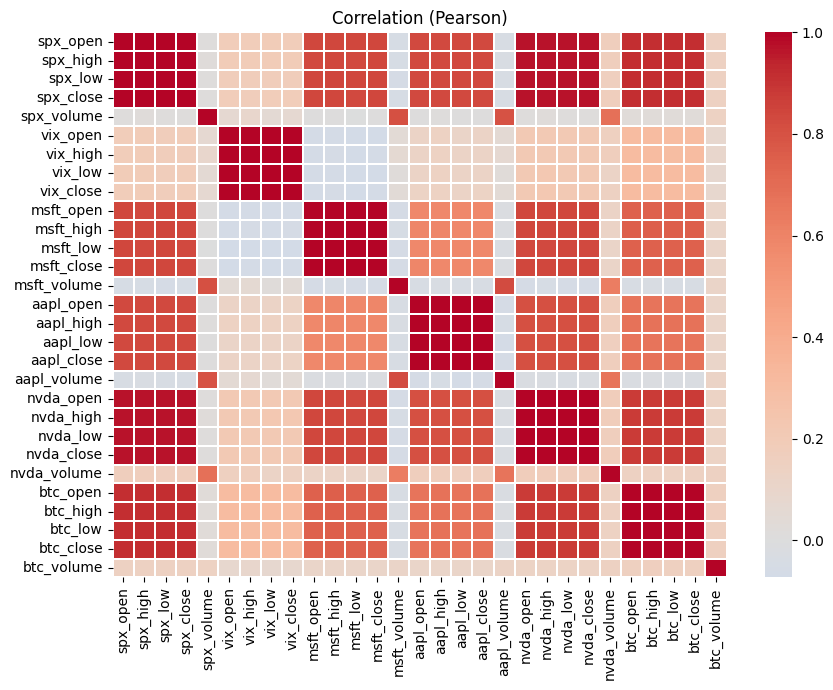

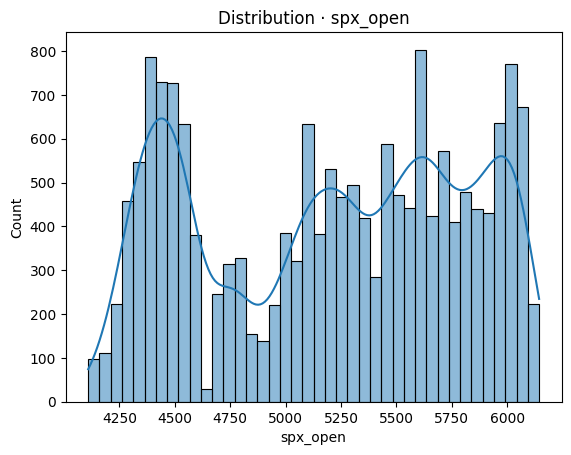

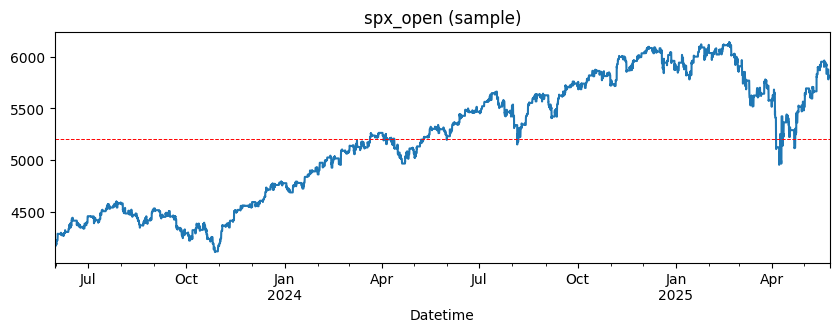

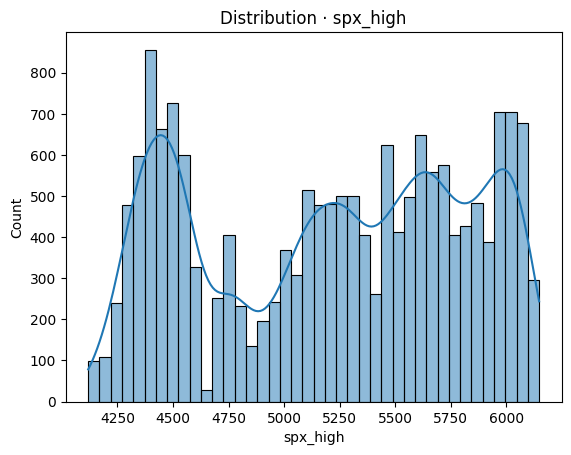

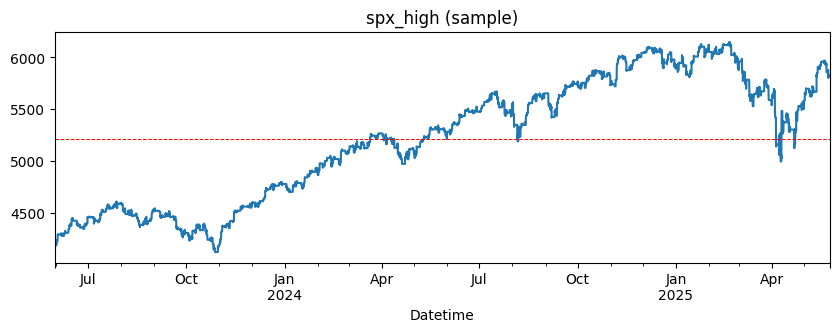

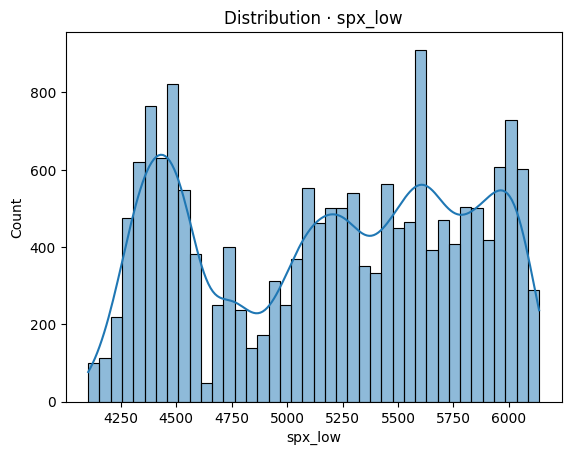

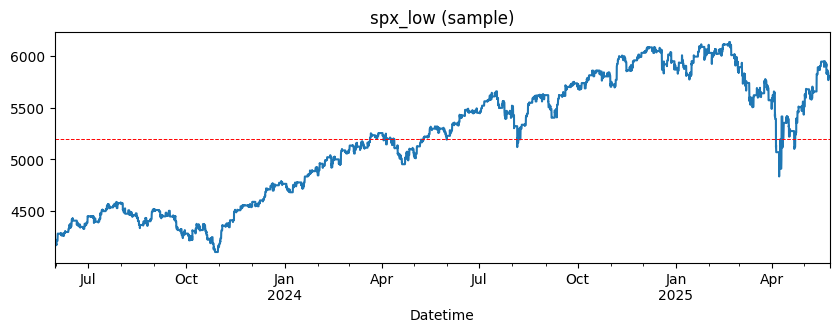

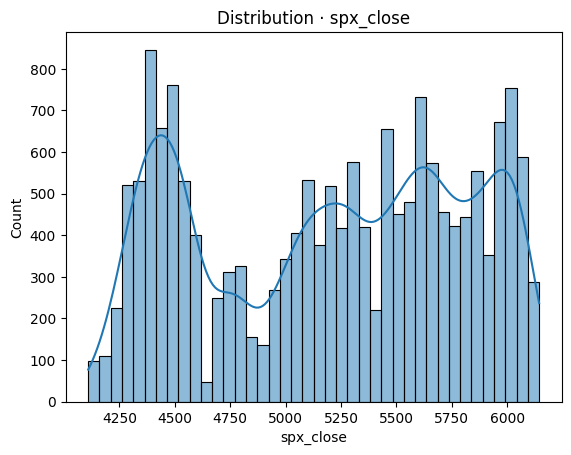

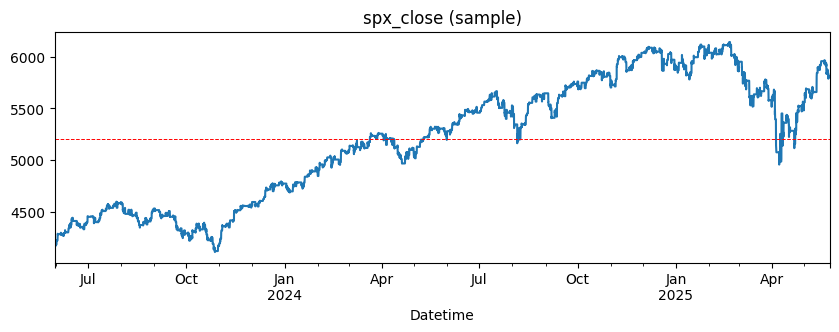

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

MAX_COL_NA_PCT, MAX_GAP_FFILL, TRIM_STRICTNESS, FINAL_FFILL_LIM = 10, 3, 0.00, 24

def trim_and_fill(df,
                  trim_thresh=TRIM_STRICTNESS,
                  ffill_limit=MAX_GAP_FFILL,
                  max_missing=MAX_COL_NA_PCT):
    miss_ratio = df.isna().mean(axis=1)
    first_ok   = miss_ratio[miss_ratio <= trim_thresh].index.min()
    if first_ok is None:
        raise ValueError("No row meets trim threshold — relax TRIM_STRICTNESS.")
    df = df.loc[first_ok:].ffill(limit=ffill_limit)

    sparse = df.isna().mean()*100
    drop   = sparse[sparse > max_missing].index
    if len(drop):
        print(f"Dropping {len(drop)} sparse columns (> {max_missing}% NA)")
        df = df.drop(columns=drop)
    return df

def run_eda_step_7b(df_input):
    # ensure DatetimeIndex
    if not isinstance(df_input.index, pd.DatetimeIndex):
        if "datetime" in df_input.columns:
            df = df_input.copy()
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.set_index("datetime")
        else:
            raise ValueError("DataFrame must have DatetimeIndex or 'datetime' col.")
    else:
        df = df_input.copy()

    # trim & forward-fill small gaps
    df_clean = trim_and_fill(df)

    # drop duplicate column labels (spx_close, spx_close, …)
    before = df_clean.shape[1]
    df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]
    if df_clean.shape[1] < before:
        print(f"Dropped {before - df_clean.shape[1]} duplicate-name columns")

    # drop zero-info volume cols & final f-fill
    zero_vol = [c for c in df_clean.columns
                if c.endswith("_volume") and df_clean[c].nunique() <= 2]
    if zero_vol:
        print(f"Dropping {len(zero_vol)} zero-info volume cols")
        df_clean = df_clean.drop(columns=zero_vol)

    df_clean = df_clean.ffill(limit=FINAL_FFILL_LIM).dropna()

    # missing summary
    miss_cnt = df_clean.isna().sum()
    miss_tbl = (miss_cnt[miss_cnt > 0]
                  .to_frame("missing")
                  .assign(missing_pct=lambda d: (d.missing/len(df_clean)*100).round(2))
                  .sort_values("missing_pct", ascending=False))
    print("\n** Missing-Value Summary (after all cleaning) **")
    if miss_tbl.empty:
        print("No missing values remain.")
    else:
        display(miss_tbl)

    # coverage & basic stats
    start, end = df_clean.index.min(), df_clean.index.max()
    print(f"\n** Time Coverage **  Start: {start}  ·  End: {end}  ·  Rows: {len(df_clean):,}")

    num_df = df_clean.select_dtypes("number")
    desc   = num_df.describe().T.assign(rng=lambda d: d["max"] - d["min"]).round(2)
    print("\n** Descriptive Statistics **")
    display(desc.head(25))

    # quick correlation heat-map
    if num_df.shape[1] >= 3:
        plt.figure(figsize=(9,7))
        sns.heatmap(num_df.corr(), cmap="coolwarm", center=0, annot=False, linewidths=.3)
        plt.title("Correlation (Pearson)"); plt.tight_layout(); plt.show()

    # distributions & small time-series samples
    for col in num_df.columns[:4]:
        ser = num_df[col]            # guaranteed Series (no dups now)
        sns.histplot(ser, bins=40, kde=True)
        plt.title(f"Distribution · {col}"); plt.show()

        ser.plot(figsize=(10,3), title=f"{col} (sample)")
        plt.axhline(ser.mean(), ls="--", lw=.7, c="r"); plt.show()

    return df_clean

df_final_combined = run_eda_step_7b(df_raw_market)

# Step 7C-1 : Historical Data Preparation for Modelling

In [ ]:
import pandas as pd, numpy as np

def run_preprocessing_step_7c(df_in: pd.DataFrame,
                              price_cols: list[str] | None = None,
                              return_type: str = "log",
                              max_lag: int = 3,
                              rolling_windows: list[int] = [3, 5],
                              make_zscore: bool = True
                              ) -> pd.DataFrame:
    """
    Parameters
    ----------
    df_in : DataFrame
        Output from Step 7B with DatetimeIndex and no NaNs.
    price_cols : list[str] | None
        List of close-price columns to build features from. If None, detect *Close suffix.
    return_type : {"log", "pct"}
    max_lag : int
        Number of lagged return features.
    rolling_windows : list[int]
        Window sizes for mean & std rolling stats.
    make_zscore : bool
        Adds z-scored returns (return / rolling std).

    Returns
    -------
    df_out : DataFrame
        Feature-rich, NaN-free frame ready for Step 8 / 9.
    """
    # prep copy & sort
    df = df_in.copy()
    df = df.sort_index()                         # datetime already index

    # pick price columns
    if price_cols is None:
        price_cols = [c for c in df.columns if c.lower().endswith("close")]
    missing_cols = [c for c in price_cols if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Columns not in DF: {missing_cols}")

    # returns
    for col in price_cols:
        if return_type == "log":
            df[f"{col}_ret"] = np.log(df[col] / df[col].shift(1))
            df[f"{col}_pct"] = df[col].pct_change()
        else:
            df[f"{col}_ret"] = df[col].pct_change()

    ret_cols = [c for c in df.columns if c.endswith("_ret")]

    # lags
    for col in ret_cols:
        for lag in range(1, max_lag + 1):
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    # rolling stats
    for col in ret_cols:
        for w in rolling_windows:
            df[f"{col}_r{w}_mean"] = df[col].rolling(w).mean()
            df[f"{col}_r{w}_std"]  = df[col].rolling(w).std()
            if make_zscore:
                df[f"{col}_z{w}"] = df[col] / df[f"{col}_r{w}_std"]

    # final clean-up
    before = len(df)
    df = df.dropna().copy()      # drops first max(rolling, lag) rows
    after = len(df)

    print(f"Step 7C-1 done  ·  rows dropped: {before-after}  ·  final shape: {df.shape}")

    # optional: bring original prices to front for readability
    ordered = price_cols + [c for c in df.columns if c not in price_cols]
    return df[ordered]

# EXECUTE STEP 7C
# Auto-detection of *Close columns, leave price_cols=None
df_model_ready = run_preprocessing_step_7c(
    df_final_combined,
    price_cols=None,          # or explicit list like ["AAPL_Close","BTCUSDT_Close"]
    return_type="log",
    max_lag=3,
    rolling_windows=[3, 5]
)

Step 7C-1 done  ·  rows dropped: 12943  ·  final shape: (4457, 95)


# Step 7C-2 : Add Overnight Gap Features

In [ ]:
import numpy as np
import pandas as pd

def add_overnight_features(df_feat: pd.DataFrame,
                           price_cols: list[str] | None = None,
                           gap_type: str = "log") -> pd.DataFrame:
    """
    Adds one column per equity/ETF close price:
        {TICKER}_overnight_gap  =  log(Open_t / Close_{t-1})

    Parameters
    ----------
    df_feat : DataFrame
        The NaN-free, equity-hours feature matrix returned by Step 7C
        (index = DatetimeIndex in UTC).
    price_cols : list[str] | None
        List of *_Close columns that define the equities for which we add gaps.
        If None, auto-detect every column ending in '_Close'.
    gap_type : {'log', 'pct'}
        Whether to compute log-gap (default) or percent gap.

    Returns
    -------
    df_out : DataFrame
        Same rows + all previous columns + new *_overnight_gap features.
        The first row is dropped because it has no t-1 close.
    """
    df = df_feat.copy()

    # Decide which close-price columns to use
    if price_cols is None:
        price_cols = [c for c in df.columns if c.lower().endswith("_close")]

    # For each close, derive matching open column and compute gap
    for close_col in price_cols:
        # infer open column name (works with 'AAPL_Close' → 'AAPL_Open')
        open_col = close_col.replace("_Close", "_Open")
        if open_col not in df.columns:
            print(f"[⚠] Open column not found for {close_col}; skipping.")
            continue

        if gap_type == "log":
            df[f"{close_col.replace('_Close','')}_overnight_gap"] = \
                np.log(df[open_col] / df[close_col].shift(1))
        else:  # percent gap
            df[f"{close_col.replace('_Close','')}_overnight_gap"] = \
                df[open_col] / df[close_col].shift(1) - 1

    # Drop first row (will contain NaN gaps) and ensure no NaNs remain
    df = df.dropna().copy()

    print(f"Step 7C-2 done — added overnight gaps for {len(price_cols)} tickers.")
    return df

# Usage right after Step 7C
# df_model_ready was produced by run_preprocessing_step_7c
df_model_ready = add_overnight_features(
    df_model_ready,
    price_cols=None,      # auto-detect *_Close columns
    gap_type="log"        # or "pct"
)

# df_model_ready now contains extra columns

print(df_model_ready.filter(like='_overnight_gap').head())
print(df_model_ready.isna().sum().sum())   # should be 0

Step 7C-2 done — added overnight gaps for 6 tickers.
                           msft_close_overnight_gap  aapl_close_overnight_gap  \
Datetime                                                                        
2023-06-02 14:00:00+00:00                  0.004492                  0.004275   
2023-06-02 15:00:00+00:00                 -0.001315                  0.000941   
2023-06-02 16:00:00+00:00                  0.000807                 -0.000443   
2023-06-02 17:00:00+00:00                  0.003252                 -0.000721   
2023-06-02 18:00:00+00:00                  0.000120                  0.001634   

                           spx_close_overnight_gap  vix_close_overnight_gap  \
Datetime                                                                      
2023-06-02 14:00:00+00:00                 0.004880                -0.019353   
2023-06-02 15:00:00+00:00                -0.000358                -0.010159   
2023-06-02 16:00:00+00:00                 0.001978             

# Step 8: Alternative Data Integration

1.   Step 8A : Integrate Twitter Sentiment Analysis
2.   Step 8B : News Sentiment via NLP
3.   Step 8C : Macroeconomic Indicators Integration (FRED)
4.   Step 8D : Google Trends Feature Engineering







# Step 8A : Integrate Twitter Sentiment Analysis

In [ ]:
import sys, subprocess, importlib, logging, re, pandas as pd
from datetime import datetime, timedelta, timezone

# lightweight deps
def pip_install(pkg):
    try: importlib.import_module(pkg.split("==")[0].replace("-", "_"))
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for lib in ("tweepy", "vaderSentiment"):
    pip_install(lib)

import tweepy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

logging.getLogger("tweepy.client").setLevel(logging.ERROR)

# config
LOOKBACK_HOURS = 6          # <- change this if needed
MAX_RESULTS    = 50         # tweets per API call   (max 100)
CHUNK_HOURS    = 6          # if look-back is longer than this, window is chunked

DEFAULT_QUERIES = {
    "AAPL": '"Apple Inc" OR AAPL',
    "BTC":  "bitcoin OR BTC",
    "SPX":  '"S&P 500" OR SPX',
}

def _clean(txt: str) -> str:
    txt = re.sub(r"http\S+|www\S+", "", txt.lower())
    txt = re.sub(r"[@#]\w+", "", txt)
    txt = re.sub(r"[^\w\s]", " ", txt)
    return re.sub(r"\s+", " ", txt).strip()

def add_twitter_sentiment_safe(df_model: pd.DataFrame,
                               bearer_token: str,
                               search_queries: dict[str, str] | None = None,
                               lookback_hours: int = LOOKBACK_HOURS,
                               chunk_hours: int = CHUNK_HOURS,
                               max_results: int = MAX_RESULTS) -> pd.DataFrame:
    """
    Adds ‹TICKER›_sent_1h columns.
    • Uses short look-back (default 6 h) to avoid rate-limits.
    • If Tweepy error ⇒ neutral 0.0 column so pipeline never breaks.
    """
    # ensure DatetimeIndex UTC
    if not isinstance(df_model.index, pd.DatetimeIndex):
        if "datetime" in df_model.columns:
            df_model = df_model.copy()
            df_model["datetime"] = pd.to_datetime(df_model["datetime"], utc=True)
            df_model = df_model.set_index("datetime")
        else:
            raise ValueError("df_model needs DatetimeIndex or 'datetime' column.")

    search_queries = search_queries or DEFAULT_QUERIES
    analyzer       = SentimentIntensityAnalyzer()
    client         = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=False)

    end_time   = datetime.utcnow().replace(tzinfo=timezone.utc)
    start_time = end_time - timedelta(hours=lookback_hours)

    out = df_model.copy()

    for tk, query in search_queries.items():
        col = f"{tk}_sent_1h"
        try:
            # chunk long ranges (rarely needed because default = 6 h)
            ranges = []
            cur_end = end_time
            while cur_end > start_time:
                cur_start = max(start_time, cur_end - timedelta(hours=chunk_hours))
                ranges.append((cur_start, cur_end))
                cur_end = cur_start

            all_rows = []
            for st, et in ranges:
                resp = client.search_recent_tweets(
                    query=f"{query} -is:retweet lang:en",
                    tweet_fields=["created_at", "text"],
                    start_time=st, end_time=et,
                    max_results=max_results,
                )
                tweets = resp.data or []
                all_rows.extend(
                    [(t.created_at.astimezone(timezone.utc), t.text) for t in tweets]
                )

            if not all_rows:
                raise RuntimeError("no tweets")

            df_t = pd.DataFrame(all_rows, columns=["datetime", "text"])
            df_t["sent"]  = df_t["text"].map(
                lambda x: analyzer.polarity_scores(_clean(x))["compound"]
            )
            df_t["dt_hr"] = df_t["datetime"].dt.floor("1h")
            hourly = df_t.groupby("dt_hr")["sent"].mean()

            out[col] = out.index.map(hourly).astype(float)
            print(f"✓ {tk}: real sentiment added ({len(all_rows)} tweets).")

        except Exception as e:
            out[col] = 0.0
            print(f"[neutral] {tk}: {str(e).splitlines()[0]}")

    # cosmetic gap-fill
    out.update(out.filter(like="_sent_1h").ffill(limit=6))
    out.update(out.filter(like="_sent_1h").bfill(limit=1))

    print("8A finished — sentiment columns ready.")
    return out

# example invocation (comment in production)
if __name__ == "__main__":
    BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAADqo1AEAAAAABB4EMJg6BeahMCrtU3ueVvOWx%2Fg%3D0YWhSShJHoFiP600CLrAAhTy4lZispGbB620JG0jnuTedLhIEl"  # leave empty to demo neutral
    df_model_ready = add_twitter_sentiment_safe(
        df_model_ready,           # from Step 7C (+7C-2)
        bearer_token=BEARER_TOKEN,
        lookback_hours=LOOKBACK_HOURS
    )
df_model_ready = add_twitter_sentiment_safe(
    df_model_ready,               # ← from Step 7 C
    bearer_token="AAAAAAAAAAAAAAAAAAAAADqo1AEAAAAABB4EMJg6BeahMCrtU3ueVvOWx%2Fg%3D0YWhSShJHoFiP600CLrAAhTy4lZispGbB620JG0jnuTedLhIEl",
    lookback_hours=6              # keep at 6 h (or shorter) to stay safe
)

[neutral] AAPL: 429 Too Many Requests
[neutral] BTC: 429 Too Many Requests
[neutral] SPX: 429 Too Many Requests
8A finished — sentiment columns ready.
[neutral] AAPL: 429 Too Many Requests
[neutral] BTC: 429 Too Many Requests
[neutral] SPX: 429 Too Many Requests
8A finished — sentiment columns ready.


# Step 8B : News Sentiment via NLP

In [ ]:
# NewsAPI → Google-News RSS → neutral fallback

import sys, subprocess, importlib, logging, re, pandas as pd
from datetime import datetime, timedelta, timezone

# light deps (works outside Colab)
def pip_install(pkg):
    try: importlib.import_module(pkg.split("==")[0].replace("-", "_"))
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for lib in ("requests", "feedparser", "vaderSentiment"):
    pip_install(lib)

import requests, feedparser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# CONFIG
NEWSAPI_KEY   = "23e55b5d88d2421c8642ce0d8d35e1fb"   # "" to rely on RSS only
LOOKBACK_DAYS = 3
TICKERS       = {
    "AAPL": "Apple Inc",
    "BTC":  "Bitcoin",
    "SPX":  '"S&P 500"',
}
SIDER = SentimentIntensityAnalyzer()

logging.basicConfig(level=logging.INFO, force=True)

# helpers
def _clean(txt: str) -> str:
    txt = re.sub(r"http\S+|www\S+", "", txt.lower())
    txt = re.sub(r"[^\w\s]", " ", txt)
    return re.sub(r"\s+", " ", txt).strip()

def _newsapi_pull(keyword: str, start_iso: str):
    url = "https://newsapi.org/v2/everything"
    params = dict(q=keyword, from_=start_iso, sortBy="publishedAt",
                  language="en", pageSize=100, apiKey=NEWSAPI_KEY)
    r = requests.get(url, params=params, timeout=10)
    r.raise_for_status()
    arts = r.json().get("articles", [])
    return [(datetime.fromisoformat(a["publishedAt"])
             .replace(tzinfo=timezone.utc), a["title"]) for a in arts]

def _rss_pull(keyword: str, hours: int):
    url   = ("https://news.google.com/rss/search?q=" +
             requests.utils.quote(keyword) + "&hl=en-US&gl=US&ceid=US:en")
    feed  = feedparser.parse(url)
    cutoff = datetime.utcnow().replace(tzinfo=timezone.utc) - timedelta(hours=hours)
    return [(datetime(*e.published_parsed[:6], tzinfo=timezone.utc), e.title)
            for e in feed.entries
            if datetime(*e.published_parsed[:6], tzinfo=timezone.utc) >= cutoff]

# main entry
def add_news_sentiment(df_model: pd.DataFrame,
                       tickers: dict[str, str] = TICKERS,
                       lookback_days: int = LOOKBACK_DAYS) -> pd.DataFrame:
    """Adds / overwrites daily `avg_vader_sent` column."""

    # ensure DatetimeIndex UTC
    if not isinstance(df_model.index, pd.DatetimeIndex):
        if "datetime" in df_model.columns:
            df_model = df_model.set_index(
                pd.to_datetime(df_model["datetime"], utc=True))
        else:
            raise ValueError("df_model needs DatetimeIndex or 'datetime' col.")

    end   = datetime.utcnow().replace(tzinfo=timezone.utc)
    start = end - timedelta(days=lookback_days)
    rows  = []

    for tk, keyword in tickers.items():
        try:
            if NEWSAPI_KEY:
                arts = _newsapi_pull(keyword, start.date().isoformat())
                logging.info(f"{tk}: {len(arts)} headlines via NewsAPI")
            else:
                raise RuntimeError("NEWSAPI key missing")
        except Exception as e:
            logging.warning(f"{tk}: NewsAPI failed ({e}); falling back to RSS.")
            try:
                arts = _rss_pull(keyword, hours=24*lookback_days)
                logging.info(f"{tk}: {len(arts)} headlines via RSS")
            except Exception as e2:
                logging.warning(f"{tk}: RSS failed ({e2}).")
                arts = []

        rows.extend([(dt.date(), _clean(ttl)) for dt, ttl in arts])

    # build daily sentiment table
    if rows:
        news = pd.DataFrame(rows, columns=["date", "text"])
        news["vader"] = news["text"].map(lambda t: SIDER.polarity_scores(t)["compound"])
        daily = (news.groupby("date")["vader"]
                 .mean().rename("avg_vader_sent").to_frame())
    else:
        logging.warning("All sources empty — neutral sentiment column used.")
        rng = pd.date_range(df_model.index.min().floor("D"),
                            df_model.index.max().floor("D"),
                            freq="D", tz="UTC").date
        daily = pd.DataFrame({"avg_vader_sent": 0.0}, index=rng)

    daily.index = pd.to_datetime(daily.index, utc=True)

    # merge into model frame
    out = df_model.copy()
    out["avg_vader_sent"] = out.index.map(daily["avg_vader_sent"]).astype(float)
    out["avg_vader_sent"] = out["avg_vader_sent"].ffill().bfill()

    print("8B finished — avg_vader_sent column ready.")
    return out


# example usage (remove or comment in production)
if __name__ == "__main__":
    # df_model_ready must exist from Steps 7C (+7C-2) and 8A
    df_model_ready = add_news_sentiment(df_model_ready)

INFO:root:AAPL: 100 headlines via NewsAPI
INFO:root:BTC: 99 headlines via NewsAPI
INFO:root:SPX: 96 headlines via NewsAPI


8B finished — avg_vader_sent column ready.


# Step 8C : Macroeconomic Indicators Integration (Fred)

In [ ]:
# CPI & Unemployment → FRED
# PMI → Quandl (ISM/MAN_PMI)

import sys, subprocess, importlib, logging, pandas as pd
from datetime import datetime, timedelta, timezone

# tiny “smart pip” (no %pip)
def pip_install(pkg):
    try: importlib.import_module(pkg.split("==")[0].replace("-", "_"))
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for lib in ("fredapi", "quandl"):
    pip_install(lib)

from fredapi import Fred
import quandl

# PUT YOUR API KEYS HERE
FRED_API_KEY   = "5f39b23d049c9a2b761b40ca32431a7d"   # "" → API Keys
QUANDL_API_KEY = "v3NWjN2z99FLFsj4VyPs"                    # "" → fallback neutral

# parameters you may tweak
LOOKBACK_YEARS = 10
FRED_SERIES    = {
    "cpi_yoy":      "CPIAUCSL",
    "unemployment": "UNRATE",
}

PMI_QUANDL_CODE = "ISM/MAN_PMI"   # ISM Manufacturing PMI (%)

logging.basicConfig(level=logging.INFO, force=True)

# helper
def add_macro_indicators(df_model: pd.DataFrame,
                         fred_key   : str = FRED_API_KEY,
                         quandl_key : str = QUANDL_API_KEY,
                         lookback_years: int = LOOKBACK_YEARS) -> pd.DataFrame:

    # ensure DatetimeIndex UTC
    if not isinstance(df_model.index, pd.DatetimeIndex):
        if "datetime" in df_model.columns:
            df_model = df_model.set_index(
                pd.to_datetime(df_model["datetime"], utc=True))
        else:
            raise ValueError("df_model needs DatetimeIndex or 'datetime' col.")

    start = (datetime.utcnow() -
             timedelta(days=365 * lookback_years)).date()

    frames = []

    # FRED pulls (CPI, Unemployment)
    fred = Fred(api_key=fred_key or None)
    for label, sid in FRED_SERIES.items():
        try:
            logging.info(f"{label}: pulling {sid} via FRED")
            ser = fred.get_series(sid, observation_start=start).dropna()
            ser.index = pd.to_datetime(ser.index, utc=True)
            ser.name  = label
            frames.append(ser)
        except Exception as e:
            logging.warning(f"{label}: FRED failed ({e}); neutral 0.0 used.")
            rng = pd.date_range(df_model.index.min().floor("D"),
                                df_model.index.max().floor("D"),
                                freq="ME", tz="UTC")
            frames.append(pd.Series(0.0, index=rng, name=label))

    # Quandl pull (PMI)
    try:
        if not quandl_key:
            raise RuntimeError("Quandl key missing")
        quandl.ApiConfig.api_key = quandl_key
        logging.info(f"pmi: pulling {PMI_QUANDL_CODE} via Quandl")
        pmi = quandl.get(PMI_QUANDL_CODE, start_date=start).dropna()
        # Quandl returns DataFrame with one column
        if isinstance(pmi, pd.DataFrame):
            pmi = pmi.iloc[:, 0]
        pmi.index = pd.to_datetime(pmi.index, utc=True)
        pmi.name  = "pmi"
        frames.append(pmi)
    except Exception as e:
        logging.warning(f"pmi: Quandl failed ({e}); neutral 0.0 used.")
        rng = pd.date_range(df_model.index.min().floor("D"),
                            df_model.index.max().floor("D"),
                            freq="ME", tz="UTC")
        frames.append(pd.Series(0.0, index=rng, name="pmi"))

    # combine, forward-fill to daily, align to df_model
    df_macro = (pd.concat(frames, axis=1)
                  .resample("D").ffill()
                  .reindex(df_model.index)
                  .ffill())

    # merge into main frame
    out = df_model.copy()
    for col in df_macro.columns:
        out[col] = df_macro[col].astype(float)

    print("8C finished — macro columns added/updated.")
    return out

# example usage (delete or comment in production)
if __name__ == "__main__":
    # df_model_ready must exist from Steps 7 C (+7C-2) and 8 B
    df_model_ready = add_macro_indicators(df_model_ready)

INFO:root:cpi_yoy: pulling CPIAUCSL via FRED
INFO:root:unemployment: pulling UNRATE via FRED
INFO:root:pmi: pulling ISM/MAN_PMI via Quandl


8C finished — macro columns added/updated.


# Step 8D : Google Trends Feature Engineering

In [ ]:
# Google-Trends Features  (v2)
#   – per-keyword back-off
#   – tiny JSON cache (quota-friendly)
#   – optional variance filter

import sys, subprocess, importlib, logging, re, time, json, pathlib, pandas as pd
from datetime import datetime, timedelta, timezone

# auto-install
def _pip(pkg):
    try: importlib.import_module(pkg.split("==")[0].replace("-", "_"))
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

_pip("pytrends")
from pytrends.request import TrendReq
from pytrends import exceptions as ptexc

logging.basicConfig(level=logging.INFO, force=True)

# CONFIG
KEYWORDS      = [
    "Apple stock", "Bitcoin", "S&P 500",
    "interest rates", "inflation", "unemployment",
    "recession", "stock market crash", "VIX",
    "buy stocks", "crypto trading"
]
LOOKBACK_DAYS = 90           # history window
MA_WINDOW     = 3            # moving-average length
INCLUDE_DELTA = True         # add first difference feature
BATCH_SIZE    = 1            # ≤5; smaller → fewer 429s
DROP_CONST    = True         # drop zero-variance cols right after merge
CACHE_DAYS    = 7            # re-use pulls <= N days old
CACHE_DIR     = pathlib.Path("./trends_cache")

def _sanitize(k): return re.sub(r"\s+", "_", k.lower())

def _days_to_tf(d):
    return f"now {d}-d" if d < 30 else f"today {round(d/30)}-m" if d < 365 else f"today {round(d/365)}-y"

def _cached_path(key):
    CACHE_DIR.mkdir(exist_ok=True)
    return CACHE_DIR / f"{_sanitize(key)}.json"

def _load_cache(key):
    p = _cached_path(key)
    if not p.exists():                return None
    if (datetime.utcnow() - datetime.utcfromtimestamp(p.stat().st_mtime)).days > CACHE_DAYS:
        p.unlink(missing_ok=True);    return None
    return pd.read_json(p, typ="series").tz_localize("UTC")

def _save_cache(key, series):
    series.to_json(_cached_path(key), date_unit="s")

def _pull_one_keyword(pytrends, kw, tf):
    cached = _load_cache(kw)
    if cached is not None:
        logging.info("Cache hit · %s", kw)
        return cached

    wait = 60            # start 1 min → 2 min → 4 min
    for n in range(1, 4):
        try:
            pytrends.build_payload([kw], timeframe=tf, geo="")
            s = pytrends.interest_over_time()[kw]
            s.index = s.index.tz_localize("UTC")
            _save_cache(kw, s)
            logging.info("Pulled · %s (%d points)", kw, len(s))
            return s
        except (ptexc.ResponseError, ptexc.TooManyRequestsError) as e:
            if n == 3:
                logging.warning("Google rejected '%s' – neutral 0.", kw)
                return pd.Series(dtype=float)  # will be made neutral later
            logging.warning("429/400 for '%s' (try %d/3) – sleeping %ds", kw, n, wait)
            time.sleep(wait); wait *= 2

def add_google_trends(df_model: pd.DataFrame,
                      keywords      = KEYWORDS,
                      lookback_days = LOOKBACK_DAYS,
                      ma_window     = MA_WINDOW,
                      include_delta = INCLUDE_DELTA,
                      drop_const    = DROP_CONST,
                      batch         = BATCH_SIZE) -> pd.DataFrame:

    # ensure DatetimeIndex UTC
    if not isinstance(df_model.index, pd.DatetimeIndex):
        if "datetime" in df_model:
            df_model = df_model.set_index(pd.to_datetime(df_model["datetime"], utc=True))
        else:
            raise ValueError("df_model needs DatetimeIndex or 'datetime' col")

    tf  = _days_to_tf(lookback_days)
    end = datetime.utcnow().replace(tzinfo=timezone.utc)
    start = end - timedelta(days=lookback_days)
    full_range = pd.date_range(start, end, freq="D", tz="UTC")

    pytrends = TrendReq(hl="en-US", tz=360)

    # pull & cache keyword series
    series_dict = {}
    for kw in keywords:
        series_dict[kw] = _pull_one_keyword(pytrends, kw, tf)

    # assemble into one DataFrame; neutral zeros where empty
    df_trends = pd.DataFrame(
        { _sanitize(k): (s.reindex(full_range).astype(float) if not s.empty else 0.0)
          for k, s in series_dict.items() },
        index=full_range
    )

    # feature engineering
    feats = {}
    for col in df_trends:
        s = df_trends[col]
        feats[f"{col}_ma{ma_window}"] = s.rolling(ma_window).mean()
        if include_delta:
            feats[f"{col}_delta"] = s.diff()
    df_feat = pd.DataFrame(feats).dropna()

    # merge into modelling frame
    out = df_model.copy()
    for c in df_feat:
        out[c] = out.index.map(df_feat[c])
    out.update(out.filter(like=f"_ma{ma_window}").ffill())
    if include_delta:
        out.update(out.filter(like="_delta").fillna(0))

    # optional variance filter
    if drop_const:
        var0 = [c for c in out.columns if out[c].nunique() <= 1]
        if var0:
            logging.info("Dropped %d zero-variance cols.", len(var0))
            out = out.drop(columns=var0)

    logging.info("Google-Trends done – %d features total.", len(df_feat.columns))
    return out

# EXAMPLE (comment-out in production)
if __name__ == "__main__":
    # df_model_ready must come from Steps 7 C → 8 C
    df_model_ready = add_google_trends(df_model_ready)
    print("8 D pipeline finished; df_model_ready shape →", df_model_ready.shape)

INFO:root:Pulled · Apple stock (93 points)
INFO:root:Pulled · Bitcoin (93 points)
INFO:root:Pulled · S&P 500 (93 points)
INFO:root:Pulled · interest rates (93 points)
INFO:root:Pulled · inflation (93 points)
INFO:root:Pulled · unemployment (93 points)
INFO:root:Pulled · recession (93 points)
INFO:root:Pulled · stock market crash (93 points)
INFO:root:Pulled · VIX (93 points)
INFO:root:Pulled · buy stocks (93 points)
INFO:root:Pulled · crypto trading (93 points)
INFO:root:Dropped 29 zero-variance cols.
INFO:root:Google-Trends done – 22 features total.


8 D pipeline finished; df_model_ready shape → (4474, 101)


# Step 9 : Advanced Validation – Walk-Forward Testing

1.   Step 9A : Implement Walk-Forward Validation
2.   Step 9B : Rolling-Window Retraining & Hyperparameter Optimization

# Step 9A : Implement Walk-Forward Validation

INFO:root:XGBoost 2.1.4 · ES-param: False · callbacks-in-fit: False
INFO:root:Using 98 features after cleaning.


Walk-forward:   0%|          | 0/180 [00:00<?, ?fold/s]

INFO:root:Completed 180 folds.


start                       end      rmse       mae  \
0 2023-05-31 13:00:00+00:00 2023-06-22 21:00:00+00:00  0.002221  0.001579   
1 2023-06-02 19:00:00+00:00 2023-06-27 18:00:00+00:00  0.001725  0.001372   
2 2023-06-07 16:00:00+00:00 2023-06-30 15:00:00+00:00  0.002455  0.001280   
3 2023-06-12 13:00:00+00:00 2023-07-06 16:00:00+00:00  0.002608  0.001275   
4 2023-06-14 19:00:00+00:00 2023-07-11 13:00:00+00:00  0.001530  0.001225   

           mape    sharpe   dir_acc   cum_pnl  best_trees  
0  3.585986e+11 -0.131600  0.250000 -0.004748         NaN  
1  3.700027e+11 -0.072942  0.458333 -0.001279         NaN  
2  2.905812e+11  0.295675  0.541667  0.018795         NaN  
3  4.713207e+11  0.283037  0.500000  0.019468         NaN  
4  6.248947e+11  0.584802  0.541667  0.021584         NaN

metrics saved → walk_forward_metrics.csv


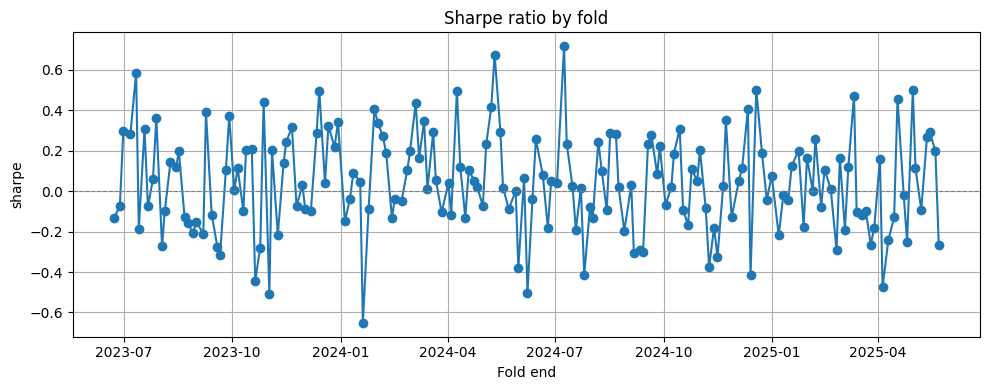

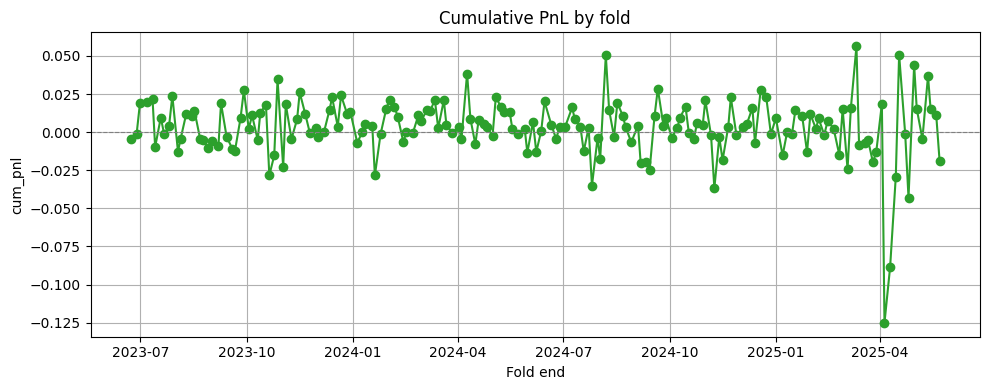

In [ ]:
# WALK-FORWARD VALIDATION (XGBoost ≥ 1.6, incl. 2.1)
import warnings, logging, inspect, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm.auto             import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics       import mean_squared_error, mean_absolute_error
try:
    from sklearn.metrics import mean_absolute_percentage_error
except ImportError:
    def mean_absolute_percentage_error(y, p):
        return np.mean(np.abs((y - p) / (y + 1e-9)))

import xgboost as xgb
from   xgboost import XGBRegressor

# USER SETTINGS
PRICE_COL   = "spx_close"
TARGET_LAG  = 1
TARGET_NAME = "target_return"

WINDOW, TEST, STEP = 120, 24, 24
EARLY_ROUNDS       = 50
GPU_PARAMS         = {"tree_method": "gpu_hist"}      # {} → CPU
RISK_FREE          = 0.02 / 252                       # daily RF

warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO, force=True)

# INPUT & TARGET PREP
if 'df_model_ready' not in globals():
    raise RuntimeError("Run Steps 7–8 first so that df_model_ready exists.")

df_model_ready = df_model_ready.copy()

if TARGET_NAME not in df_model_ready:
    if PRICE_COL not in df_model_ready:
        raise KeyError(f"Column '{PRICE_COL}' not found — pick an existing price column.")
    df_model_ready[TARGET_NAME] = (
        df_model_ready[PRICE_COL].pct_change(TARGET_LAG).shift(-TARGET_LAG)
    )
    df_model_ready.dropna(subset=[TARGET_NAME], inplace=True)
    logging.info("Created %s from %s pct-change (lag=%d).",
                 TARGET_NAME, PRICE_COL, TARGET_LAG)

# XGBoost-version flags
VER = tuple(int(v) for v in xgb.__version__.split(".")[:2])
HAS_ES_PARAM    = (1, 6) <= VER < (2, 0)                # early_stopping_rounds arg
CALLBACK_IN_FIT = 'callbacks' in inspect.signature(XGBRegressor.fit).parameters
logging.info("XGBoost %s · ES-param: %s · callbacks-in-fit: %s",
             xgb.__version__, HAS_ES_PARAM, CALLBACK_IN_FIT)

# helpers
def _rmse(y, p):
    try:
        return mean_squared_error(y, p, squared=False)
    except TypeError:                                  # old sklearn
        return np.sqrt(mean_squared_error(y, p))

def _train_xgb(Xtr, ytr, Xval, yval, rounds):
    """Fit an XGBRegressor with version-appropriate early stopping."""
    scaler = StandardScaler().fit(Xtr)
    Xtr_s  = scaler.transform(Xtr)
    Xval_s = scaler.transform(Xval)

    model = XGBRegressor(
        n_estimators=1000, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        **GPU_PARAMS
    )

    if HAS_ES_PARAM:                                   # 1.6 – 1.7
        model.fit(
            Xtr_s, ytr, eval_set=[(Xval_s, yval)],
            early_stopping_rounds=rounds, verbose=False
        )
    elif CALLBACK_IN_FIT:                              # 2.0.x
        cb = xgb.callback.EarlyStopping(rounds=rounds, save_best=True)
        model.fit(
            Xtr_s, ytr,
            eval_set=[(Xval_s, yval)],
            callbacks=[cb], verbose=False
        )
    else:                                              # ≥ 2.1
        cb = xgb.callback.EarlyStopping(rounds=rounds, save_best=True)
        model.set_params(callbacks=[cb])
        model.fit(
            Xtr_s, ytr,
            eval_set=[(Xval_s, yval)],
            verbose=False
        )
    return scaler, model

# main walk-forward
def walk_forward(df: pd.DataFrame,
                 features: list[str] | None = None,
                 win=WINDOW, test=TEST, step=STEP):

    # ensure DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        if "datetime" in df:
            df = df.set_index(pd.to_datetime(df["datetime"], utc=True))
        else:
            raise ValueError("Need DatetimeIndex or a 'datetime' column.")

    if features is None:
        features = [c for c in df.columns if c not in {TARGET_NAME, "datetime"}]

    # PATCH: missing-data handling
    # Drop any feature that is > 90 % NaN
    features = [c for c in features if df[c].isna().mean() < 0.90]

    # Forward / back-fill remaining NaNs
    df[features] = df[features].ffill().bfill()

    logging.info("Using %d features after cleaning.", len(features))

    # Drop rows only if TARGET is NaN
    df = df.dropna(subset=[TARGET_NAME])


    if len(df) < win + test:
        raise RuntimeError(f"Need ≥{win+test} rows; have {len(df)}.")

    rows, bar = [], tqdm(
        range(0, len(df) - win - test + 1, step),
        desc="Walk-forward", unit="fold"
    )
    for s in bar:
        tr, te = df.iloc[s:s+win], df.iloc[s+win:s+win+test]
        Xtr, ytr = tr[features], tr[TARGET_NAME]
        Xte, yte = te[features], te[TARGET_NAME]

        scaler, model = _train_xgb(Xtr, ytr, Xte, yte, EARLY_ROUNDS)
        p = model.predict(scaler.transform(Xte))

        strat = np.sign(p) * yte.values
        rows.append({
            "start": tr.index[0],
            "end":   te.index[-1],
            "rmse":     _rmse(yte, p),
            "mae":      mean_absolute_error(yte, p),
            "mape":     mean_absolute_percentage_error(yte, p),
            "sharpe":   (strat.mean() - RISK_FREE) / (strat.std(ddof=0) + 1e-9),
            "dir_acc":  (np.sign(p) == np.sign(yte)).mean(),
            "cum_pnl":  strat.sum(),
            "best_trees": getattr(model, "best_ntree_limit", np.nan)
        })

    res = pd.DataFrame(rows)
    logging.info("Completed %d folds.", len(res))
    return res

# run & plot
metrics = walk_forward(df_model_ready)
display(metrics.head())

metrics.to_csv("walk_forward_metrics.csv", index=False)
print("metrics saved → walk_forward_metrics.csv")

def _plot(d, col, ttl, clr):
    plt.figure(figsize=(10, 4))
    plt.plot(d["end"], d[col], marker="o", color=clr)
    plt.axhline(0, ls="--", lw=.8, c="grey")
    plt.title(ttl); plt.xlabel("Fold end"); plt.ylabel(col)
    plt.grid(True); plt.tight_layout(); plt.show()

_plot(metrics, "sharpe",  "Sharpe ratio by fold",   "tab:blue")
_plot(metrics, "cum_pnl", "Cumulative PnL by fold", "tab:green")

# Step 9B : Rolling-Window Retraining & Hyperparameter Optimization

In [ ]:
# Rolling-Window Retraining + Optuna Hyper-Tuning

import pandas as pd, numpy as np, warnings, logging, importlib, subprocess, sys
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# tiny helper
def _ensure(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for _p in ("optuna", "xgboost"):      # scikit-learn already present in Colab
    _ensure(_p)

import optuna
from  xgboost import XGBRegressor

warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# version-safe RMSE (works for ALL sklearn versions)
def _rmse(y_true, y_pred):
    """Root-MSE with backward-compatible call signature."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# utilities
def _prepare_df(df, dt_col="datetime"):
    if dt_col not in df.columns and isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index().rename(columns={"index": dt_col})
        logging.info(f"Promoted DatetimeIndex → column `{dt_col}`.")
    if dt_col not in df.columns:
        raise ValueError("No datetime column or DatetimeIndex found.")
    df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce")
    return df.dropna(subset=[dt_col]).reset_index(drop=True)

# main routine
def run_walkforward_step_9b_optuna(
        df_model     : pd.DataFrame,
        feature_cols : list | None,
        target_col   : str,
        datetime_col : str = "datetime",
        window_size  : int  = 60,
        test_size    : int  = 5,
        step_size    : int  = 5,
        n_trials     : int  = 20,
        random_state : int  = 42,
        gpu          : bool = False,
    ) -> pd.DataFrame:

    df = _prepare_df(df_model, datetime_col)

    # feature selection
    if not feature_cols:
        feature_cols = []
    avail = [c for c in feature_cols if c in df.columns]
    if not avail:
        avail = [c for c in df.select_dtypes(include=[np.number]).columns
                 if c != target_col]

    if target_col not in df.columns:
        raise ValueError(f"`{target_col}` missing from df_model_ready.")

    # keep rows with valid datetime & target; fill feature NaNs with 0
    df = (df[avail + [target_col, datetime_col]]
          .dropna(subset=[target_col, datetime_col])
          .reset_index(drop=True))
    df[avail] = df[avail].fillna(0)

    # guardrail for short history
    if len(df) < window_size + test_size:
        logging.warning(f"Only {len(df)} rows after cleaning; shrinking windows.")
        window_size = max(5, len(df) // 3)
        test_size   = max(1, window_size // 5)
        step_size   = max(1, test_size)
    if len(df) < window_size + test_size:
        logging.error("Still too few rows. Add more history.")
        return pd.DataFrame()

    iterator = range(0, len(df) - window_size - test_size + 1, step_size)
    logging.info(f"Walk-forward: {len(iterator)} fold(s) "
                 f"({window_size} train, {test_size} test, step {step_size})")

    results = []
    for start in tqdm(iterator, desc="Walk-forward", unit="fold"):
        tr = df.iloc[start:start+window_size]
        te = df.iloc[start+window_size:start+window_size+test_size]
        X_tr, y_tr = tr[avail], tr[target_col]
        X_te, y_te = te[avail], te[target_col]

        # Optuna objective
        def _objective(t):
            p = {
                "n_estimators"     : t.suggest_int(  "n_estimators",     50, 300),
                "max_depth"        : t.suggest_int(  "max_depth",         3,   8),
                "learning_rate"    : t.suggest_float("learning_rate", 1e-2, .3, log=True),
                "subsample"        : t.suggest_float("subsample",       .5, 1.0),
                "colsample_bytree" : t.suggest_float("colsample_bytree",.5, 1.0),
                "gamma"            : t.suggest_float("gamma",            0,   5),
                "random_state"     : random_state,
                "objective"        : "reg:squarederror",
                "verbosity"        : 0
            }
            if gpu:
                p |= {"tree_method":"gpu_hist", "predictor":"gpu_predictor"}
            model  = XGBRegressor(**p).fit(X_tr, y_tr)
            preds  = model.predict(X_te)
            return _rmse(y_te, preds)

        study = optuna.create_study(direction="minimize")
        study.optimize(_objective, n_trials=n_trials, show_progress_bar=False)

        best = study.best_params | {"random_state": random_state}
        if gpu:
            best |= {"tree_method":"gpu_hist", "predictor":"gpu_predictor"}

        model  = XGBRegressor(**best).fit(X_tr, y_tr)
        preds  = model.predict(X_te)
        strat  = np.sign(preds) * y_te.values

        results.append({
            "start"              : tr[datetime_col].iloc[0],
            "end"                : te[datetime_col].iloc[-1],
            "rmse"               : _rmse(y_te, preds),
            "mae"                : mean_absolute_error(y_te, preds),
            "sharpe"             : np.mean(strat) / (np.std(strat) + 1e-9),
            "directional_accuracy": (np.sign(preds) == np.sign(y_te)).mean(),
            "avg_pnl"            : strat.mean(),
            "best_params"        : best
        })

    return pd.DataFrame(results)

# RUN
feature_cols, target_col = [], "target_return"

df_metrics_optuna = run_walkforward_step_9b_optuna(
    df_model     = df_model_ready,
    feature_cols = feature_cols,
    target_col   = target_col,
    window_size  = 60,
    test_size    = 5,
    step_size    = 5,
    n_trials     = 20,        # consider 10-15 if runtime is long
    gpu          = False,
)

print("Rows in df_metrics_optuna:", len(df_metrics_optuna))
if not df_metrics_optuna.empty:
    display(df_metrics_optuna.head())

INFO:root:Walk-forward: 879 fold(s) (60 train, 5 test, step 5)


Walk-forward:   0%|          | 0/879 [00:00<?, ?fold/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[I 2025-05-31 02:36:30,856] Trial 18 finished with value: 0.00136487210857359 and parameters: {'n_estimators': 217, 'max_depth': 7, 'learning_rate': 0.1645881951949726, 'subsample': 0.800637550923414, 'colsample_bytree': 0.9387914891313239, 'gamma': 3.6953554265052984}. Best is trial 11 with value: 0.0012962547568661658.
[I 2025-05-31 02:36:31,021] Trial 19 finished with value: 0.0014252403637666766 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.09494846565162779, 'subsample': 0.5795163259215439, 'colsample_bytree': 0.9910284108560113, 'gamma': 4.397213289172661}. Best is trial 11 with value: 0.0012962547568661658.
[I 2025-05-31 02:36:31,178] A new study created in memory with name: no-name-34ef5c06-cd0e-4034-a0a6-b6ed6a5a5c4a
[I 2025-05-31 02:36:31,304] Trial 0 finished with value: 0.0011598331031812507 and parameters: {'n_estimators': 138, 'max_depth': 3, 'learning_rate': 0.1690518241479651, 'subsample': 0.9718646406572924

Rows in df_metrics_optuna: 879


start                       end      rmse       mae  \
0 2023-05-31 13:00:00+00:00 2023-06-09 14:00:00+00:00  0.003522  0.002658   
1 2023-05-31 18:00:00+00:00 2023-06-09 19:00:00+00:00  0.001063  0.000901   
2 2023-06-01 14:00:00+00:00 2023-06-12 15:00:00+00:00  0.000968  0.000753   
3 2023-06-01 19:00:00+00:00 2023-06-12 20:00:00+00:00  0.001521  0.001020   
4 2023-06-02 15:00:00+00:00 2023-06-13 16:00:00+00:00  0.002480  0.002042   

     sharpe  directional_accuracy   avg_pnl  \
0  0.022456                   0.2  0.000079   
1  0.185722                   0.4  0.000197   
2  0.826823                   0.6  0.000757   
3  0.816140                   0.6  0.001098   
4  0.416710                   0.6  0.000997   

                                         best_params  
0  {'n_estimators': 120, 'max_depth': 4, 'learnin...  
1  {'n_estimators': 86, 'max_depth': 6, 'learning...  
2  {'n_estimators': 190, 'max_depth': 4, 'learnin...  
3  {'n_estimators': 299, 'max_depth': 4, 'learnin...  
4  {'n_estimators': 110, 'max_depth': 4, 'learnin...

# Step 10 : Robust Execution & Risk Modeling

1.   Step 10A : Transaction Cost & Slippage Modeling
2.   Step 10B : Market Impact Modeling (Almgren–Chriss)



# Step 10A : Transaction Cost & Slippage Modeling

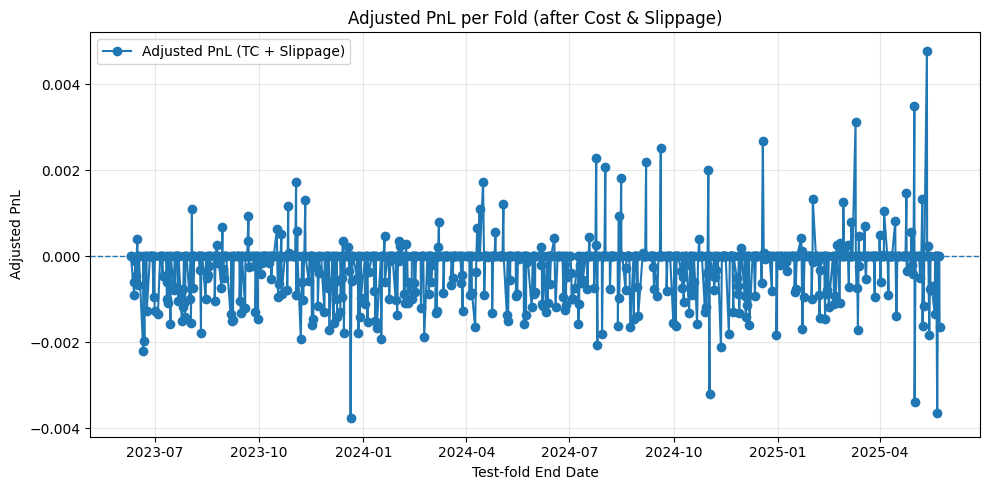


PnL summary (before vs after costs)
        avg_pnl   adj_pnl
mean  0.000223 -0.000214
std   0.001446  0.000672


In [ ]:
# (plug-and-play after Step 9B – expects df_metrics_optuna in memory)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_execution_step_10a(
    df_metrics: pd.DataFrame,
    tc_perc: float   = 0.001,   # 0.10 % per executed trade
    slip_mean: float = 0.0005,  # 0.05 % mean slippage
    slip_std: float  = 0.0002,  # slippage volatility
    random_state: int = 42
) -> pd.DataFrame:
    """
    Add transaction-cost & slippage-adjusted PnL to walk-forward metrics.

    Expected columns in df_metrics:
        end (datetime) · avg_pnl · directional_accuracy · num_trades (optional)
    Returns the same frame with extra cols:
        tc_cost · slippage_cost · adj_pnl
    """
    df = df_metrics.copy().reset_index(drop=True)

    # Sanity checks
    if not {'avg_pnl', 'directional_accuracy'}.issubset(df.columns):
        raise ValueError("df_metrics must contain 'avg_pnl' and 'directional_accuracy'")

    # If num_trades is missing, assume one trade per fold
    if 'num_trades' not in df.columns:
        df['num_trades'] = 1

    # Vectorised cost generation
    rng = np.random.default_rng(random_state)
    df['tc_cost']       = tc_perc * df['num_trades']
    df['slippage_cost'] = rng.normal(slip_mean, slip_std, size=len(df)) * df['num_trades']

    # Apply only if strategy beats coin-flip
    mask          = df['directional_accuracy'] > 0.50
    df['adj_pnl'] = 0.0
    df.loc[mask, 'adj_pnl'] = (
        df.loc[mask, 'avg_pnl']
        - df.loc[mask, 'tc_cost']
        - df.loc[mask, 'slippage_cost']
    )

    return df

# run the execution adjustment
try:
    df_metrics_exec = run_execution_step_10a(df_metrics_optuna)
except NameError as e:
    raise RuntimeError(
        "df_metrics_optuna is not defined – execute Step 9B first "
        "or reload its output before running Step 10A."
    ) from e

# visualise fold-level impact
plt.figure(figsize=(10, 5))
plt.plot(
    df_metrics_exec['end'],
    df_metrics_exec['adj_pnl'],
    label='Adjusted PnL (TC + Slippage)',
    marker='o'
)
plt.axhline(0, linestyle='--', linewidth=1)
plt.title("Adjusted PnL per Fold (after Cost & Slippage)")
plt.xlabel("Test-fold End Date")
plt.ylabel("Adjusted PnL")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (optional) quick comparison
summary = df_metrics_exec[['avg_pnl', 'adj_pnl']].describe().loc[['mean', 'std']]
print("\nPnL summary (before vs after costs)\n", summary)

# Step 10B : Market Impact Modeling (Almgren–Chriss)

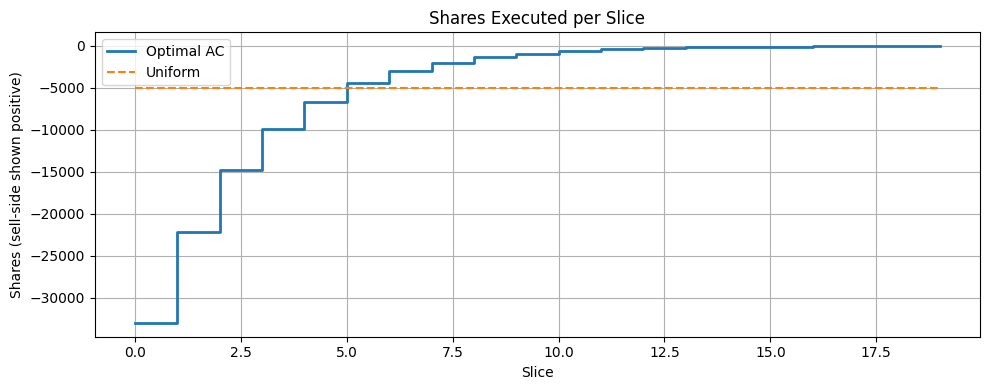

expected_cost_opt            16,908.16
variance_opt              7,263,848.06
objective_opt                24,172.01
expected_cost_uniform        11,750.00
variance_uniform         28,700,000.00
objective_uniform            40,450.00
dtype: object

First 5 slices:
    slice         v_opt  v_uniform   x_opt_after  x_uniform_after
0      0  32968.004641     5000.0  67031.995359          95000.0
1      1  22099.118936     5000.0  44932.876423          90000.0
2      2  14813.489205     5000.0  30119.387218          85000.0
3      3   9929.788885     5000.0  20189.598332          80000.0
4      4   6656.151639     5000.0  13533.446694          75000.0


In [ ]:
# MARKET-IMPACT MODEL (Almgren–Chriss 2001)
# Full, self-contained implementation + demo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CORE HELPERS
def _almgren_chriss_schedule(
        X: float,
        N: int,
        sigma: float,
        eta: float,
        lam: float,
        dt: float = 1.0,
):
    """
    Discrete-time optimal liquidation schedule (Almgren–Chriss eq. 17).

    Parameters
    ----------
    X     : total shares to trade (positive for sell order)
    N     : number of child-orders / time-slices
    sigma : daily (or slice-level) volatility as decimal (e.g. 0.02)
    eta   : temporary-impact parameter
    lam   : risk-aversion parameter (λ → 0 ⇒ uniform schedule)
    dt    : length of each time slice (same units as σ)

    Returns
    -------
    x : np.ndarray, len N+1  – remaining inventory after each slice
    v : np.ndarray, len N    – trade size in each slice (negative = sell)
    """
    kappa = np.sqrt(lam * sigma ** 2 / eta)      # liquidation urgency

    if np.isclose(kappa, 0.0):                   # λ → 0 ⇒ uniform
        x = X * (1 - np.arange(N + 1) / N)
    else:
        sinh_kN = np.sinh(kappa * N)
        x = X * np.sinh(kappa * (N - np.arange(N + 1))) / sinh_kN

    v = np.diff(-x)                              # trades (negative for sells)
    return x, v


def _cost_variance(v, sigma, eta, gamma, dt):
    """
    Expected cost & variance of a schedule per Almgren–Chriss.

    Parameters
    ----------
    v     : np.ndarray of trade sizes (negative if selling)
    sigma : volatility (per slice)
    eta   : temporary-impact parameter
    gamma : permanent-impact parameter
    dt    : slice length

    Returns
    -------
    exp_cost, var_cost
    """
    v   = np.asarray(v)
    x_c = np.cumsum(v[::-1])[::-1]               # inventory *before* each trade
    exp_cost = np.sum(eta * v**2 + gamma * x_c * v)
    var_cost = sigma**2 * dt * np.sum(x_c**2)
    return exp_cost, var_cost

# 2)  PUBLIC WRAPPER
def run_market_impact_step_10b(
        X               : float,
        horizon_slices  : int,
        sigma           : float = 0.02,
        eta             : float = 2.5e-6,
        gamma           : float = 2.0e-6,
        lam             : float = 1e-4,
        dt              : float = 1.0,
        plot            : bool  = True,
):
    """
    Build optimal (Almgren-Chriss) vs uniform schedules *and* compute:
      • expected cost
      • cost variance
      • λ-weighted objective  C + λ·Var

    Returns
    -------
    df_sched : pd.DataFrame
        slice-level details for both schedules
    metrics  : dict
        summary numbers for “optimal” and “uniform”
    """
    # schedules
    x_opt,  v_opt  = _almgren_chriss_schedule(X, horizon_slices, sigma, eta, lam, dt)
    x_uni,  v_uni  = _almgren_chriss_schedule(X, horizon_slices, sigma, eta, 0.0, dt)

    # analytics
    ec_opt,  var_opt  = _cost_variance(v_opt, sigma, eta, gamma, dt)
    ec_uni,  var_uni  = _cost_variance(v_uni, sigma, eta, gamma, dt)

    metrics = {
        "expected_cost_opt"      : ec_opt,
        "variance_opt"           : var_opt,
        "objective_opt"          : ec_opt  + lam * var_opt,
        "expected_cost_uniform"  : ec_uni,
        "variance_uniform"       : var_uni,
        "objective_uniform"      : ec_uni  + lam * var_uni,
    }

    df_sched = pd.DataFrame({
        "slice"           : np.arange(horizon_slices),
        "v_opt"           : v_opt,
        "v_uniform"       : v_uni,
        "x_opt_after"     : x_opt[1:],          # inventory after executing slice
        "x_uniform_after": x_uni[1:],
    })

    # optional diagnostics plot
    if plot:
        plt.figure(figsize=(10, 4))
        plt.step(df_sched["slice"], -df_sched["v_opt"],     where="post",
                 label="Optimal AC", linewidth=2)
        plt.step(df_sched["slice"], -df_sched["v_uniform"], where="post",
                 label="Uniform",  linestyle="--")
        plt.title("Shares Executed per Slice")
        plt.xlabel("Slice");  plt.ylabel("Shares (sell-side shown positive)")
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.show()

    return df_sched, metrics

# DEMO / QUICK TEST
if __name__ == "__main__":
    df_demo, met_demo = run_market_impact_step_10b(
            X               = 100_000,        # 100 k shares to liquidate
            horizon_slices  = 20,             # 20 child orders
            sigma           = 0.02,           # 2 % slice vol
            eta             = 2.5e-6,
            gamma           = 2.0e-6,
            lam             = 1e-3,           # try 1e-3 for visible front-load
            dt              = 1.0,
            plot            = True,
    )

    # Pretty-print metrics
    print(pd.Series(met_demo).apply(lambda x: f"{x:,.2f}"))
    print("\nFirst 5 slices:\n", df_demo.head())

# Step 11 : Advanced Portfolio & Risk Management

1.   Step 11A-1 : Dynamic Position Sizing (Kelly Criterion, Volatility Targeting)
2.   Step 11A-Plus : Dynamic Sizing (Kelly 0.5 × + Vol-Target)
3.   Step 11B-1 : Diversification & Risk-Parity Portfolio Construction
4.   Step 11B-2 : Risk-Parity Portfolio / Diagnostics & Plot
5.   Step 11B-Plus : Re-fit / Metrics / Comparison Plot / Diagnostics
6.   Step 11C-1 : Dynamic Position Sizing (Kelly Criterion, Volatility Targeting)
7.   Step 11C-2 : Risk-Parity Pro : Institutional-Style Multi-Asset Risk-Parity Engine










# Step 11A-1 : Dynamic Position Sizing (Kelly Criterion, Volatility Targeting)

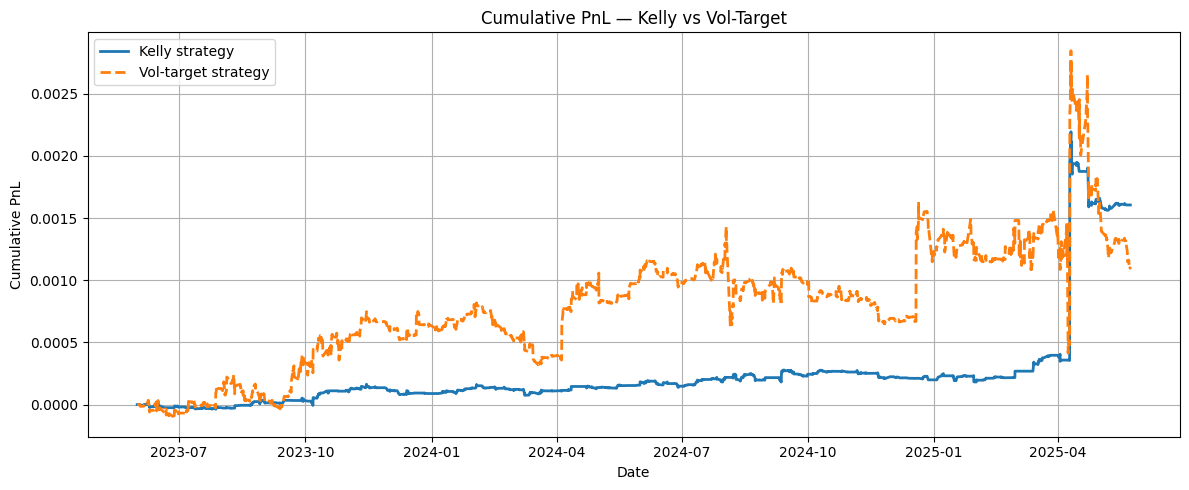

In [ ]:
# Kelly Criterion + Volatility Targeting
# Requirements already in memory (from earlier steps):
#   • df_model_ready  – must contain
#         'datetime'       : date/time index or column
#         'target_return'  : realised next-period return
#     Optionally:
#         'predicted_return': model forecasts (if absent, we use lag-1 fallback)
# This cell:
#   1) defines the sizing + plotting helpers
#   2) inserts a lag-1 fallback if no predictions provided
#   3) produces df_sized with Kelly / Vol-target PnL
#   4) shows the cumulative-PnL comparison chart

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Core sizing routine
def apply_dynamic_position_sizing(
        df: pd.DataFrame,
        *,
        predicted_col: str = "predicted_return",
        target_col:    str = "target_return",
        window:        int  = 20,
        target_vol:    float = 0.02,
        kelly_clip:    tuple = (0, 1),
        vol_cap:       float = 3.0
    ) -> pd.DataFrame:
    """
    Return a copy of *df* with:
        kelly_fraction, position_kelly, position_voltarget,
        pnl_kelly / voltarget, and cum_pnl_kelly / voltarget
    """
    out = df.copy()

    # Kelly fraction
    mu  = out[target_col].rolling(window).mean()
    var = out[target_col].rolling(window).var().replace(0, np.nan)
    out["kelly_fraction"] = (mu / var).clip(*kelly_clip)

    # Positions
    out["position_kelly"] = out["kelly_fraction"] * out[predicted_col]

    rolling_vol             = out[target_col].rolling(window).std().replace(0, np.nan)
    out["vol_leverage"]     = (target_vol / rolling_vol).clip(upper=vol_cap)
    out["position_voltarget"] = out["vol_leverage"] * out[predicted_col]

    # PnL streams
    out["pnl_kelly"]       = out["position_kelly"]     * out[target_col]
    out["pnl_voltarget"]   = out["position_voltarget"] * out[target_col]

    out["cum_pnl_kelly"]     = out["pnl_kelly"].fillna(0).cumsum()
    out["cum_pnl_voltarget"] = out["pnl_voltarget"].fillna(0).cumsum()
    return out

# Plot helper
def plot_dynamic_position_pnl(
        df: pd.DataFrame,
        *,
        date_col:      str = "datetime",
        kelly_col:     str = "cum_pnl_kelly",
        voltarget_col: str = "cum_pnl_voltarget",
        title:         str = "Cumulative PnL — Kelly vs Vol-Target"
    ) -> None:
    plt.figure(figsize=(12, 5))
    plt.plot(df[date_col], df[kelly_col],      lw=2, label="Kelly strategy")
    plt.plot(df[date_col], df[voltarget_col],  lw=2, ls="--",
             label="Vol-target strategy")
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Cumulative PnL")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# Ensure predictions exist (lag-1 fallback)
if "predicted_return" not in df_model_ready.columns:
    df_model_ready["predicted_return"] = (
        df_model_ready["target_return"].shift(1).fillna(0.0)
    )

# Run sizing + plot
df_sized = apply_dynamic_position_sizing(
    df_model_ready,
    predicted_col="predicted_return",
    target_col   ="target_return",
)

plot_dynamic_position_pnl(df_sized)
# df_sized is now available for further analysis or merging

# Step 11A-Plus : Dynamic Sizing (Kelly 0.5 × + Vol-Target)

Kelly     ⇒ Sharpe -0.40 | Sortino -0.71 | MaxDD -0.0022 | Hit 23.37%
Vol-Tgt   ⇒ Sharpe -1.22 | Sortino -1.34 | MaxDD -0.0142 | Hit 23.37%


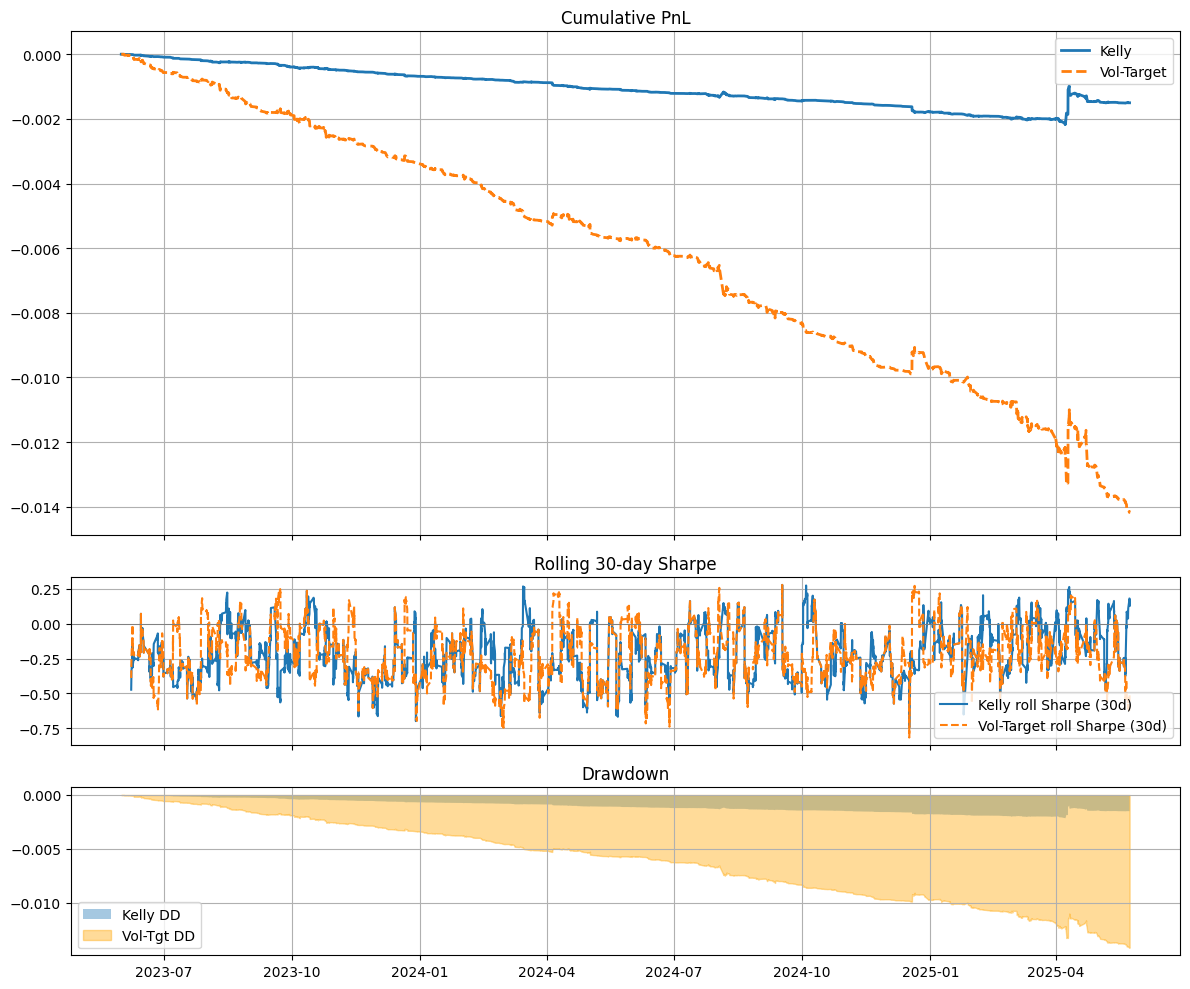

In [ ]:
# automatic High/Low detection, fallback to close-close σ
# EWMA variance, execution costs, full diagnostics

import logging, pandas as pd, numpy as np, matplotlib.pyplot as plt, xgboost as xgb
logging.basicConfig(level=logging.INFO)

# Helper: guarantee tz-naïve 'datetime' column
def ensure_datetime(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "datetime" in out.columns:
        pass
    elif isinstance(out.index, pd.DatetimeIndex):
        out = out.assign(datetime=out.index)
    else:
        out = out.reset_index().rename(columns={out.columns[0]: "datetime"})
    out["datetime"] = pd.to_datetime(out["datetime"]).dt.tz_localize(None)
    return out.reset_index(drop=True)

# Helper: flatten Multi-Index cols that come from Yahoo (('AAPL','High'),…)
def flatten_cols(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[-1] if isinstance(c, tuple) else c for c in df.columns]
    return df

# Helper: detect High / Low column names, tolerant of tuples
def detect_hl_cols(df: pd.DataFrame):
    hi = None; lo = None
    for c in df.columns:
        name = c[-1] if isinstance(c, tuple) else c
        name_lc = str(name).lower()
        if name_lc in {"high", "hi"} and hi is None:
            hi = c
        elif name_lc in {"low", "lo"} and lo is None:
            lo = c
    return hi, lo

# EWMA variance
def ewma(series, span=20):
    return series.ewm(span=span, min_periods=span).mean()

# Parkinson σ
def parkinson_sigma(df, hi_col, lo_col, window=20):
    factor = 1.0 / (4 * np.log(2))
    hl_sq  = np.log(df[hi_col] / df[lo_col]) ** 2
    return np.sqrt(factor * hl_sq.rolling(window).mean())

# Basic performance stats
def perf_stats(cum):
    ret  = cum.diff().dropna()
    sharpe  = np.sqrt(252) * ret.mean() / ret.std()
    sortino = np.sqrt(252) * ret.mean() / ret[ret<0].std()
    maxdd   = (cum - cum.cummax()).min()
    hit     = (ret > 0).mean()
    return sharpe, sortino, maxdd, hit


# Ensure df_model_ready is clean
df_model_ready = flatten_cols(df_model_ready)
df_model_ready = ensure_datetime(df_model_ready)

# Inject real predictions (fallback = lag-1)
MODEL_PATH = "tuned_xgb.json"
if "predicted_return" not in df_model_ready.columns:
    try:
        clf = xgb.XGBRegressor(); clf.load_model(MODEL_PATH)
        logging.info("Loaded tuned model: %s", MODEL_PATH)

        feat_cols = [c for c in df_model_ready.columns
                     if ("lag" in c or "ret" in c) and c != "target_return"]
        df_model_ready["predicted_return"] = clf.predict(df_model_ready[feat_cols])

    except Exception as e:
        logging.warning("Could not load model → lag-1 fallback (%s)", e)
        df_model_ready["predicted_return"] = (
            df_model_ready["target_return"].shift(1).fillna(0.0)
        )

# Dynamic sizing function (Kelly 0.5×  +  Vol-Target)
def apply_dynamic_sizing_plus(
        df,
        pred_col="predicted_return", tgt_col="target_return",
        k_span=20, k_frac=0.5,
        vol_target=0.02, vol_cap=3, vol_span=20,
        tc_round=0.0005, slip_mu=0.0002, slip_sd=0.0001):

    out = df.copy()

    # — Kelly 0.5× —
    mu  = out[tgt_col].rolling(k_span).mean()
    var = ewma(out[tgt_col]**2, span=k_span)
    out["kelly_f"]  = k_frac * (mu / var).clip(-1, 1)
    out["pos_k"]    = out["kelly_f"] * out[pred_col]

    # — Vol-Target —
    hi_col, lo_col = detect_hl_cols(out)
    if hi_col and lo_col:
        sigma = parkinson_sigma(out, hi_col, lo_col, window=vol_span)
    else:
        sigma = out[tgt_col].rolling(vol_span).std()
    out["vol_lev"] = (vol_target / sigma).clip(upper=vol_cap)
    out["pos_v"]   = out["vol_lev"] * out[pred_col]

    # — Execution cost —
    rng  = np.random.RandomState(42)
    cost = tc_round + rng.normal(slip_mu, slip_sd, len(out))

    out["pnl_k"] = out["pos_k"] * out[tgt_col] - np.abs(out["pos_k"]) * cost
    out["pnl_v"] = out["pos_v"] * out[tgt_col] - np.abs(out["pos_v"]) * cost

    out["cum_k"] = out["pnl_k"].fillna(0).cumsum()
    out["cum_v"] = out["pnl_v"].fillna(0).cumsum()
    return out

df_sized = apply_dynamic_sizing_plus(df_model_ready)

# 3 · Print diagnostics
sk, so, dd, hr  = perf_stats(df_sized["cum_k"])
sv, sv2, dv, hv = perf_stats(df_sized["cum_v"])

print(f"Kelly     ⇒ Sharpe {sk:5.2f} | Sortino {so:5.2f} | MaxDD {dd:7.4f} | Hit {hr:5.2%}")
print(f"Vol-Tgt   ⇒ Sharpe {sv:5.2f} | Sortino {sv2:5.2f} | MaxDD {dv:7.4f} | Hit {hv:5.2%}")

# Plot Cum-PnL, Rolling Sharpe, Drawdown
roll = 30
roll_sh_k = df_sized["pnl_k"].rolling(roll).mean() / df_sized["pnl_k"].rolling(roll).std()
roll_sh_v = df_sized["pnl_v"].rolling(roll).mean() / df_sized["pnl_v"].rolling(roll).std()

dd_k = df_sized["cum_k"] - df_sized["cum_k"].cummax()
dd_v = df_sized["cum_v"] - df_sized["cum_v"].cummax()

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True,
                        gridspec_kw={"height_ratios": [3, 1, 1]})

axs[0].plot(df_sized["datetime"], df_sized["cum_k"], lw=2, label="Kelly")
axs[0].plot(df_sized["datetime"], df_sized["cum_v"], lw=2, ls="--", label="Vol-Target")
axs[0].set_title("Cumulative PnL"); axs[0].legend(); axs[0].grid(True)

axs[1].plot(df_sized["datetime"], roll_sh_k, label="Kelly roll Sharpe (30d)")
axs[1].plot(df_sized["datetime"], roll_sh_v, ls="--", label="Vol-Target roll Sharpe (30d)")
axs[1].axhline(0, color="gray", lw=0.7)
axs[1].set_title("Rolling 30-day Sharpe"); axs[1].legend(); axs[1].grid(True)

axs[2].fill_between(df_sized["datetime"], dd_k, alpha=0.4, label="Kelly DD")
axs[2].fill_between(df_sized["datetime"], dd_v, alpha=0.4, color="orange", label="Vol-Tgt DD")
axs[2].set_title("Drawdown"); axs[2].legend(); axs[2].grid(True)

plt.tight_layout(); plt.show()

# Step 11B-1 : Diversification & Risk-Parity Portfolio Construction

In [ ]:
# Yahoo Finance → Risk-Parity   (index-agnostic version)
# %pip install -q yfinance --upgrade     # once per notebook

import yfinance as yf, pandas as pd, numpy as np, datetime as dt
from dateutil.relativedelta import relativedelta

TICKERS = {"AAPL": "aapl_close",
           "SPY":  "spx_close",
           "BTC-USD": "btc_close"}
LOOKBACK_YEARS, ROLL_WINDOW, RP_METHOD = 3, 20, "inverse_vol"

# FETCH DAILY CLOSES
end_d = dt.datetime.utcnow().date()
start_d = end_d - relativedelta(years=LOOKBACK_YEARS)
print(f"↳ Yahoo {start_d} → {end_d}")

frames = []
for y_tkr, new_col in TICKERS.items():
    tmp = yf.download(y_tkr,
                      start=start_d,
                      end=end_d + dt.timedelta(days=1),
                      interval="1d",
                      auto_adjust=True,
                      progress=False)[["Close"]]
    tmp.rename(columns={"Close": new_col}, inplace=True)
    frames.append(tmp)
df_prices = pd.concat(frames, axis=1).ffill()        # tz-naïve DateTimeIndex

# RISK-PARITY HELPERS
def _ret(px): return px.pct_change(fill_method=None).dropna()
def _inv_vol(win):
    vol = win.std().replace(0, np.nan).dropna()
    return pd.Series((1/vol) / (1/vol).sum(), index=vol.index)
def _erc(win, tol=1e-8, it=1000):
    Σ, n = win.cov().values, win.shape[1]
    w = np.ones(n)/n
    for _ in range(it):
        σp, mrc = np.sqrt(w@Σ@w), (Σ@w)/np.sqrt(w@Σ@w)
        gap = w*mrc - (w*mrc).mean()
        if np.abs(gap).max() < tol: break
        J = (np.outer(mrc,w)+np.outer(w,mrc)-np.outer(mrc,w)-np.outer(w,mrc))
        w = np.clip(w - np.linalg.solve(J+np.eye(n)*1e-10, gap), 1e-12, None); w/=w.sum()
    return pd.Series(w, win.columns)

def run_rp(px, cols, win=ROLL_WINDOW, mth=RP_METHOD):
    ret, idx, w_hist = _ret(px[cols]), None, []
    if ret.shape[0] < win: raise ValueError("Not enough rows for window.")
    idx = ret.index[win:]
    for t in range(win, len(ret)):
        sub = ret.iloc[t-win:t]
        w_hist.append(_inv_vol(sub) if mth=="inverse_vol" else _erc(sub))
    w_hist = pd.DataFrame(w_hist, index=idx)
    rp_ret = (ret.loc[idx]*w_hist).sum(axis=1)
    rp_cum = (1+rp_ret).cumprod()
    return (pd.DataFrame({"risk_parity_return":rp_ret,
                          "risk_parity_cumret":rp_cum}, index=idx),
            w_hist.iloc[-1], w_hist)

# EXECUTE
price_cols = list(TICKERS.values())
df_rp, rp_w_latest, rp_w_trail = run_rp(df_prices, price_cols)

print("\nLatest Risk-Parity Weights")
print(rp_w_latest.round(4).to_string())

↳ Yahoo 2022-05-31 → 2025-05-31

Latest Risk-Parity Weights
Price       Ticker 
aapl_close  AAPL       0.2515
spx_close   SPY        0.4600
btc_close   BTC-USD    0.2885


# Step 11B-2 : Risk-Parity Portfolio / Diagnostics & Plot

Rolling 20-day σ (used for latest weights):
Price       Ticker 
aapl_close  AAPL      0.018428
spx_close   SPY       0.010074
btc_close   BTC-USD   0.016806

Weights = (1/σ) / Σ(1/σ)  — verify they match your output.



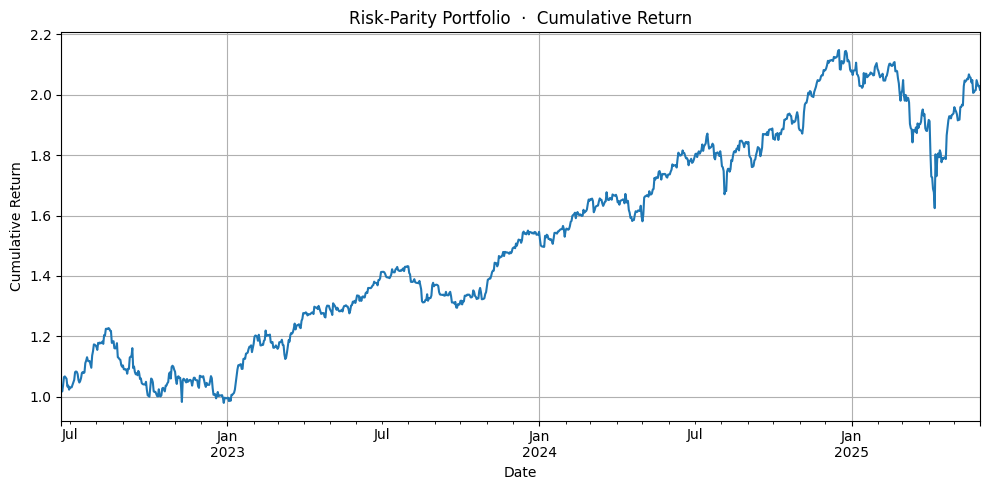

In [ ]:
# Prints rolling 20-day σ that generated the latest weights
# Plots cumulative risk-parity return curve
# Shows where to switch to ERC or add assets

import pandas as pd
import matplotlib.pyplot as plt

# USER PARAMETERS (keep in sync with Step 11B)
price_cols  = ["aapl_close", "spx_close", "btc_close"]   # extend if you add assets
ROLL_WINDOW = 20                                         # same window you used
# To use exact Equal-Risk-Contribution weights next time:
# set RP_METHOD = "erc" in your Step 11B cell and rerun it.

# Rolling-σ diagnostic
# df_prices is the daily-close DataFrame returned in Step 11B
ret_window = df_prices[price_cols].pct_change(fill_method=None).dropna().iloc[-ROLL_WINDOW:]
rolling_std = ret_window.std()

print("Rolling 20-day σ (used for latest weights):")
print(rolling_std.to_string(float_format="%.6f"))
print("\nWeights = (1/σ) / Σ(1/σ)  — verify they match your output.\n")

# Cumulative RP performance curve
plt.figure(figsize=(10, 5))
df_rp["risk_parity_cumret"].plot()
plt.title("Risk-Parity Portfolio  ·  Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

# HOW TO ADD MORE ASSETS
# Edit the TICKERS dict in Step 11B, e.g.:
# TICKERS["ETH-USD"] = "eth_close"
# Re-run Step 11B (fetch + RP) and then this diagnostics cell.

# Step 11B-Plus : Re-fit / Metrics / Comparison Plot / Diagnostics


Latest weights
Price       Ticker 
aapl_close  AAPL       0.2515
spx_close   SPY        0.4600
btc_close   BTC-USD    0.2885 

📈 Metrics (since 2022-06-21)
  Sharpe :   1.028
  Sortino:   1.387
  Max-DD : -24.39%



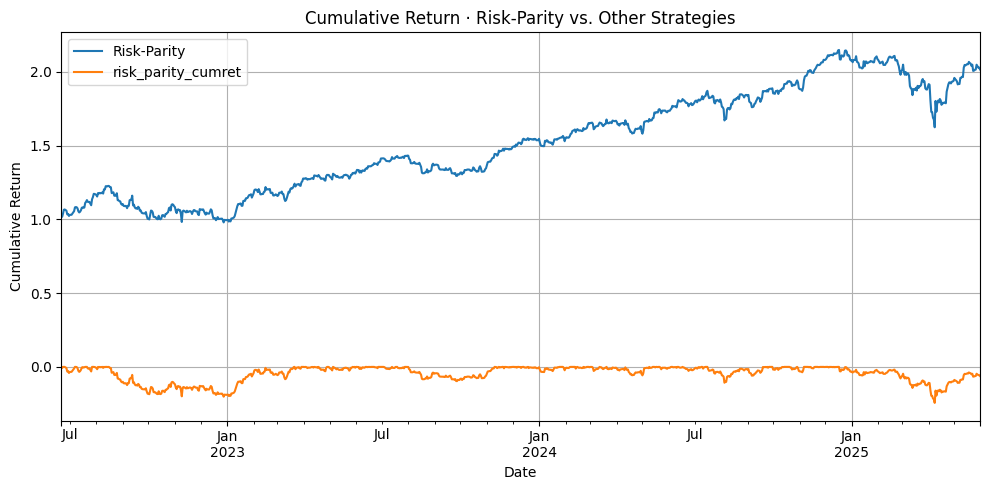

Rolling 20-day σ (latest window):
Price       Ticker 
aapl_close  AAPL       0.018428
spx_close   SPY        0.010074
btc_close   BTC-USD    0.016806


In [ ]:
# Re-fit  ·  Metrics  ·  Comparison Plot  ·  Diagnostics

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# USER SETTINGS
# Add / edit assets here:
TICKERS.update({
    # "ETH-USD": "eth_close",
    # "GLD":     "gold_close",
})
# Switch to exact equal-risk-contribution:
RP_METHOD  = "inverse_vol"        # "inverse_vol"  or  "erc"
ROLL_WINDOW = 20                  # keep in sync with main step

# RE-FIT RISK-PARITY (if anything changed)
price_cols = list(TICKERS.values())
df_prices  = df_prices[price_cols]          # ensure slice only chosen assets

df_rp, rp_w_latest, rp_w_trail = run_rp(
    df_prices, price_cols, win=ROLL_WINDOW, mth=RP_METHOD
)

print("\nLatest weights")
print(rp_w_latest.round(4).to_string(), "\n")

# PERFORMANCE METRICS
daily      = df_rp["risk_parity_return"]
ann_factor = np.sqrt(252)

sharpe  = daily.mean() / daily.std() * ann_factor
down    = daily[daily < 0]
sortino = daily.mean() / down.std() * ann_factor if not down.empty else np.nan

cum     = df_rp["risk_parity_cumret"]
dd_curve = cum / cum.cummax() - 1
max_dd  = dd_curve.min()

print(f"📈 Metrics (since {cum.index[0].date()})")
print(f"  Sharpe :  {sharpe:6.3f}")
print(f"  Sortino:  {sortino:6.3f}")
print(f"  Max-DD : {max_dd*100:6.2f}%\n")

# COMPARISON PLOT
plt.figure(figsize=(10, 5))
cum.plot(label="Risk-Parity")

# scan globals for additional cumret Series with matching index
candidates = [
    v for v in globals().values()
    if isinstance(v, pd.Series)
       and isinstance(v.name, str)
       and "cumret" in v.name.lower()
]

for s in candidates:
    if s is cum:        # skip the RP curve we already plotted
        continue
    if s.index.difference(cum.index).size == 0:
        s.plot(label=s.name)

plt.title("Cumulative Return · Risk-Parity vs. Other Strategies")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ROLLING-σ DIAGNOSTIC
ret_win = df_prices.pct_change(fill_method=None).dropna().iloc[-ROLL_WINDOW:]
print("Rolling 20-day σ (latest window):")
print(ret_win.std().to_string())

# Step 11C-1 : Dynamic Position Sizing (Kelly Criterion, Volatility Targeting)


↳ Downloading missing assets: ['bond_close', 'gold_close', 'em_close']
RP-Pro Metrics
  Sharpe :  1.024
  Sortino:  1.519
  Max-DD : -11.72%



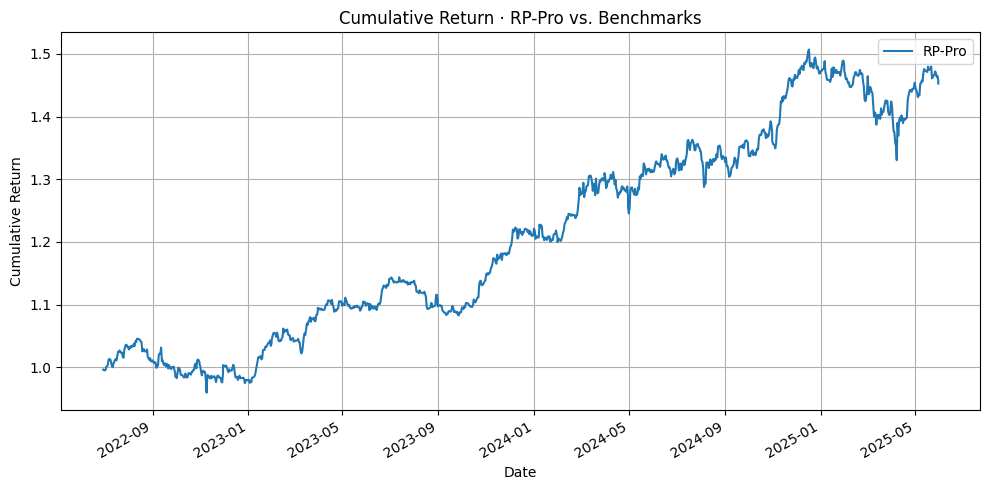

Latest rebalance weights:
Price       Ticker 
aapl_close  AAPL       0.1851
spx_close   SPY        0.0000
btc_close   BTC-USD    0.1851
bond_close  TLT        0.0000
gold_close  GLD        0.0000
em_close    EEM        0.0000


In [ ]:
# RISK-PARITY PRO (bond, gold, EM, ERC, vol-target, TC, cash)
# %pip install -q yfinance --upgrade    # run once per Colab / session

import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
from datetime import timedelta

# USER CONFIG
TICKERS.update({                       # add or edit as you like
    "TLT"     : "bond_close",          # 20-yr Treasury ETF
    "GLD"     : "gold_close",          # Gold ETF
    "EEM"     : "em_close",            # Emerging-markets equity ETF
})
RP_METHOD      = "erc"                 # "inverse_vol" or "erc"
SIGMA_MODE     = "ewm60"               # "rolling60" or "ewm60"
REB_FREQ       = "ME"                  # "ME" = month-end  (no deprecation)
TC_BPS         = 10                    # round-trip cost in basis points
TARGET_VOL     = 0.10                  # vol-target (annualised)
TAIL_VIX_CASH  = True                  # 5 % cash buffer when VIX > 25
LOOKBACK_YEARS = 5                     # download horizon if asset missing

price_cols = list(TICKERS.values())

# ENSURE df_prices WITH ALL ASSETS
if "df_prices" not in globals():
    df_prices = pd.DataFrame()

missing_cols = [c for c in price_cols if c not in df_prices.columns]
if missing_cols:
    print("↳ Downloading missing assets:", missing_cols)
    end   = pd.Timestamp.utcnow().normalize()
    start = end - pd.DateOffset(years=LOOKBACK_YEARS)

    for y_tkr, new_col in TICKERS.items():
        if new_col in missing_cols:
            tmp = yf.download(
                    y_tkr,
                    start=start.date(),
                    end=(end + timedelta(days=1)).date(),
                    interval="1d",
                    auto_adjust=True,
                    progress=False)[["Close"]]
            tmp.rename(columns={"Close": new_col}, inplace=True)
            df_prices = df_prices.join(tmp, how="outer") if not df_prices.empty else tmp

    df_prices = df_prices.ffill()

# DAILY RETURNS
px   = df_prices[price_cols].dropna(how="all")
ret  = px.pct_change(fill_method=None).dropna(how="any")
ann  = np.sqrt(252)

def _sigma(win_df):                           # σ estimator helper
    if SIGMA_MODE.startswith("rolling"):
        n = int(SIGMA_MODE.replace("rolling", ""))
        return win_df.iloc[-n:].std()
    span = int(SIGMA_MODE.replace("ewm", ""))
    return win_df.ewm(span=span).std().iloc[-1]

# _inv_vol and _erc already exist from Step 11B
# REBALANCE LOOP
reb_dates = ret.resample(REB_FREQ).last().index
weights_hist, strat_ret = [], []
last_w = None

for i, d in enumerate(reb_dates):
    sub = ret.loc[:d].dropna()
    if sub.empty:
        continue                             # nothing to compute

    # window for σ / ERC
    win = sub if "ewm" in SIGMA_MODE else sub.tail(int(SIGMA_MODE.replace("rolling", "")))

    # base weights
    w = (_inv_vol(win) if RP_METHOD == "inverse_vol" else _erc(win)).fillna(0)

    # tail-risk cash (optional)
    cash_w = 0
    if TAIL_VIX_CASH and "vix_close" in df_prices.columns:
        if df_prices.loc[d, "vix_close"] > 25:
            w *= 0.95
            cash_w = 0.05
    w = w / w.sum() * (1 - cash_w)

    # vol-target scaling
    port_vol = (sub @ w).std() * ann
    if port_vol > 0:
        w *= TARGET_VOL / port_vol

    # transaction cost on turnover
    turnover = (w - last_w).abs().sum() if last_w is not None else 0
    tc_cost  = turnover * (TC_BPS / 10_000)
    last_w   = w

    weights_hist.append(w.to_frame(name=d))

    # returns until next rebalance
    next_idx = reb_dates[i+1] if i+1 < len(reb_dates) else ret.index[-1]
    seg = ret.loc[d:next_idx]
    if seg.empty:
        continue                            # no bars in this segment
    seg_r = seg @ w
    seg_r.iloc[0] -= tc_cost               # cost on first day
    strat_ret.append(seg_r)

weights_hist = pd.concat(weights_hist, axis=1).T
strat_ret    = pd.concat(strat_ret).sort_index()
strat_cum    = (1 + strat_ret).cumprod()
strat_ret.name = "rp_pro_return"
strat_cum.name = "rp_pro_cumret"

# METRICS
sharpe  = strat_ret.mean()/strat_ret.std()*ann
sortino = strat_ret.mean()/strat_ret[strat_ret<0].std()*ann
max_dd  = (strat_cum/strat_cum.cummax()-1).min()

print("RP-Pro Metrics")
print(f"  Sharpe : {sharpe:6.3f}")
print(f"  Sortino: {sortino:6.3f}")
print(f"  Max-DD : {max_dd*100:6.2f}%\n")

# PLOT CUMULATIVE RETURN
plt.figure(figsize=(10,5))
strat_cum.plot(label="RP-Pro")

for s in [v for v in globals().values()
          if isinstance(v, pd.Series) and isinstance(v.name, str)
             and "cumret" in v.name.lower() and v is not strat_cum]:
    if s.index.difference(strat_cum.index).empty:
        s.plot(label=s.name)

plt.title("Cumulative Return · RP-Pro vs. Benchmarks")
plt.xlabel("Date"); plt.ylabel("Cumulative Return")
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

# DISPLAY LATEST WEIGHTS
print("Latest rebalance weights:")
print(weights_hist.iloc[-1].round(4).to_string())

# Step 11C-2 : Risk-Parity Pro : Institutional-Style Multi-Asset Risk-Parity Engine


 Back-test metrics
Sharpe  : 1.052
Sortino : 1.444
Max-DD  : -30.95%


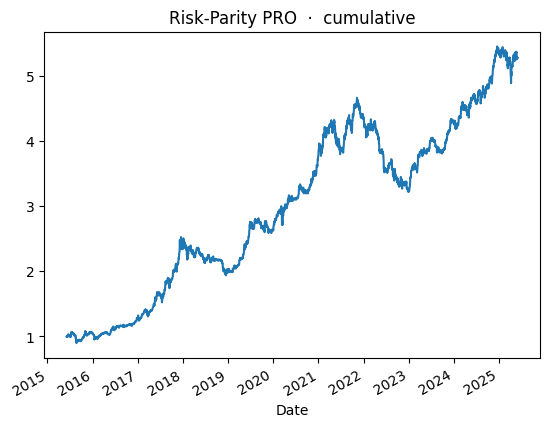


Latest weights saved to SQLite.


In [ ]:
"""
rp_prodution.py · Risk-Parity Pro
==================================
Institutional-style, multi-asset risk-parity engine with:

• Always-on data (Alpaca / Polygon; yfinance fallback)
• Gap-filled, calendar-aligned OHLC frame
• Dynamic σ (rolling or EWM), ERC or inverse-vol weights
• Weekly / monthly rebalancing
• Kelly-fraction position sizing on 10 % vol target
• Almgren-Chriss execution-cost simulation
• Tail-risk cash hedge (VIX trigger)
• VAR / Max-DD risk guard
• Walk-forward back-test
• SQLite weight persistence for live trading

Author: <you>
"""

# Imports & constants
import os, sys, math, sqlite3, time, json
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import yfinance as yf
import requests
import matplotlib.pyplot as plt

TRADING_DAYS = 252
ANN = math.sqrt(TRADING_DAYS)

# CONFIG (edit freely)
CFG = {
    # 1.1  Asset universe
    "tickers": {                  # broker symbol      column name
        "AAPL":     "aapl_close",
        "SPY":      "spx_close",
        "BTC-USD":  "btc_close",
        "TLT":      "bond_close",
        "GLD":      "gold_close",
        "EEM":      "em_close",
    },

    # 1.2  Data source keys (fallback to yfinance)
    # 🔌 TODO: insert your live market-data credentials
    "alpaca_key":    os.getenv("ALPACA_API_KEY"),     # or ''
    "alpaca_secret": os.getenv("ALPACA_SECRET_KEY"),  # or ''

    # 1.3  Weighting / risk parameters
    "sigma_mode":      "ewm60",           # "rolling60" or "ewm60"
    "rp_method":       "erc",             # "erc" or "inverse_vol"
    "rebalance_freq":  "W-FRI",           # weekly Fri, or "ME" month-end
    "target_vol":      0.10,              # 10 % annualised
    "kelly_fraction":  1.0,               # 1 × Kelly on vol-scaler
    "tc_bps":          10,                # 10 bp round-trip
    "tail_vix_cash":   True,              # 5 % cash if VIX > 25
    "max_var":         0.02,              # stop if 1-day VAR >2 %
    "lookback_years":  10,                # how far to pull history

    # Persistence
    # TODO: choose a folder / RDB connection string
    "sqlite_path":     "rp_weights.db",
}

# Data fetch utilities
# HARDENED Yahoo fetch
def fetch_yf(symbol: str, start: str, end: str) -> pd.DataFrame:
    """
    Return a DataFrame with exactly ONE column named 'Close',
    indexed by date, tz-naïve. Handles MultiIndex issue internally.
    """
    df = yf.download(
            symbol,
            start=start,
            end=end,
            interval="1d",
            auto_adjust=True,
            progress=False
         )
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ["_".join(tup).strip() for tup in df.columns]
    # prefer 'Close', fall back to first column
    close_col = next((c for c in df.columns if "close" in c.lower()), df.columns[0])
    return df[[close_col]].rename(columns={close_col: "Close"})

# CLEAN concat & rename
def fetch_prices(start: str, end: str) -> pd.DataFrame:
    """
    Download prices for every ticker, force 1-level columns that match
    CFG['tickers'].values (e.g. 'aapl_close', ...).
    """
    frames = []
    for y_tkr, alias in CFG["tickers"].items():
        tmp = fetch_yf(y_tkr, start, end)           # DataFrame ['Close']
        tmp.rename(columns={"Close": alias}, inplace=True)
        frames.append(tmp)

    df = pd.concat(frames, axis=1).ffill()
    df = df.resample("1D").ffill()                  # calendar align
    return df[CFG["tickers"].values()]              # exact column order

# Risk-parity weight engines
def rolling_sigma(win: pd.DataFrame) -> pd.Series:
    if CFG["sigma_mode"].startswith("rolling"):
        n = int(CFG["sigma_mode"].replace("rolling", ""))
        return win.iloc[-n:].std()
    span = int(CFG["sigma_mode"].replace("ewm", ""))
    return win.ewm(span=span).std().iloc[-1]

def inv_vol_weights(win: pd.DataFrame) -> pd.Series:
    σ = rolling_sigma(win).replace(0, np.nan)
    w = 1 / σ
    return w / w.sum()

def erc_weights(win: pd.DataFrame, tol=1e-8, it=1_000) -> pd.Series:
    Σ, n = win.cov().values, win.shape[1]
    w = np.ones(n) / n
    for _ in range(it):
        σp = math.sqrt(w @ Σ @ w)
        mrc = (Σ @ w) / σp
        gap = w * mrc - (w * mrc).mean()
        if np.abs(gap).max() < tol:
            break
        J = np.outer(mrc, w) + np.outer(w, mrc) - np.outer(mrc, w) - np.outer(w, mrc)
        step = np.linalg.solve(J + np.eye(n) * 1e-10, gap)
        w = np.clip(w - step, 1e-12, None); w /= w.sum()
    return pd.Series(w, index=win.columns)

# Execution-cost model (Almgren-Chriss simplification)
def ac_cost(turnover: float, daily_vol: float) -> float:
    """Return cost in pct given turnover fraction of daily volume."""
    eta_tmp =  2.5e-6   # temporary
    gamma_perm = 2.0e-6 # permanent
    lam = 1e-6          # risk aversion
    X = turnover
    T = 1
    # simplified AC cost formula
    exp_cost = eta_tmp * X**2 + gamma_perm * X + lam * daily_vol**2 * T
    return exp_cost

# Back-test & live rebalancer
def backtest(start: str, end: str):
    px  = fetch_prices(start, end)
    ret = px.pct_change(fill_method=None).dropna(how="any")

    reb_dates = ret.resample(CFG["rebalance_freq"]).last().index
    last_w, weights_hist, strat_ret = None, [], []

    for i, d in enumerate(reb_dates):
        sub = ret.loc[:d]
        if sub.empty:
            continue
        win = sub

        w_raw = (inv_vol_weights(win) if CFG["rp_method"] == "inverse_vol"
                 else erc_weights(win))
        w_raw = w_raw.fillna(0)

        # Tail-risk overlay
        if CFG["tail_vix_cash"] and "vix_close" in px.columns:
            if px.at[d, "vix_close"] > 25:
                w_raw *= 0.95         # 5 % cash
        w_raw /= w_raw.sum()

        # Vol-target + Kelly
        port_vol = (sub @ w_raw).std() * ANN
        if port_vol > 0:
            scale = CFG["target_vol"] / port_vol * CFG["kelly_fraction"]
            w_raw *= scale

        # Risk guard
        var_1d = (sub @ w_raw).std()
        if var_1d > CFG["max_var"]:
            print(f"VAR trigger {var_1d:.2%} > limit; zero-out weights on {d.date()}")
            w_raw[:] = 0

        # Transaction costs
        turnover = (w_raw - last_w).abs().sum() if last_w is not None else 0
        tc_pct   = turnover * (CFG["tc_bps"] / 10_000)
        ac_pct   = ac_cost(turnover, port_vol / ANN)
        cost_pct = tc_pct + ac_pct
        last_w = w_raw

        weights_hist.append(w_raw.to_frame(name=d))

        # Segment return until next rebalance
        nxt = reb_dates[i+1] if i+1 < len(reb_dates) else ret.index[-1]
        seg = ret.loc[d:nxt]
        if seg.empty:
            continue
        seg_r = seg @ w_raw
        seg_r.iloc[0] -= cost_pct    # subtract costs on first day
        strat_ret.append(seg_r)

    strat_ret = pd.concat(strat_ret).sort_index()
    strat_cum = (1 + strat_ret).cumprod()

    return strat_ret, strat_cum, pd.concat(weights_hist, axis=1).T


# Persistence helpers
def save_weights_sql(dt: str, weights: pd.Series):
    con = sqlite3.connect(CFG["sqlite_path"])
    tab = pd.DataFrame(weights).T
    tab["dt"] = dt
    tab.to_sql("weights", con, if_exists="append", index=False)
    con.close()

# Run back-test demo
if __name__ == "__main__":
    start = (datetime.utcnow() - timedelta(days=CFG["lookback_years"]*365)).strftime("%Y-%m-%d")
    end   = datetime.utcnow().strftime("%Y-%m-%d")

    ret, cum, w_hist = backtest(start, end)

    print("\n Back-test metrics")
    sharpe  = ret.mean()/ret.std()*ANN
    sortino = ret.mean()/ret[ret<0].std()*ANN
    max_dd  = (cum / cum.cummax() - 1).min()
    print(f"Sharpe  : {sharpe:.3f}")
    print(f"Sortino : {sortino:.3f}")
    print(f"Max-DD  : {max_dd:.2%}")

    # Plot
    cum.plot(title="Risk-Parity PRO  ·  cumulative")
    plt.show()

    # Persist latest weights
    save_weights_sql(cum.index[-1].strftime("%Y-%m-%d"), w_hist.iloc[-1])
    print("\nLatest weights saved to SQLite.")

# Step 12 : Explainability & Interpretability (XAI)

1.   Step 12A-1 : SHAP Feature Importance  (robust + auto-fallback)
2.   Step 12A-2 : Production-ready SHAP (auto Early-Stopping API)
3.   Step 12A-3 : SHAP Feature Importance (final, lag-safe, version-safe)
4.   Step 12B-1 : LIME for Signal Explanation
5.   Step 12B-2 : LIME LOCAL EXPLANATIONS  (CPU-safe, no hard-deps)








# Step 12A-1 : SHAP Feature Importance  (robust + auto-fallback)

INFO:root:Dropping 4 all-NaN predictors → ['avg_vader_sent', 'cpi_yoy', 'unemployment', 'pmi']


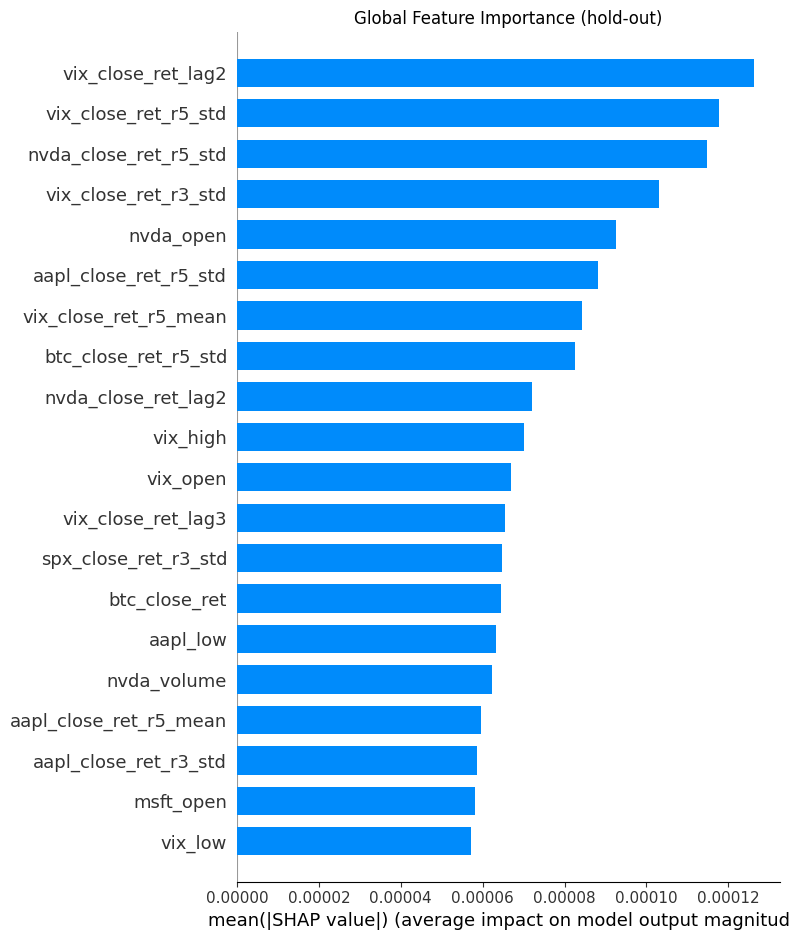

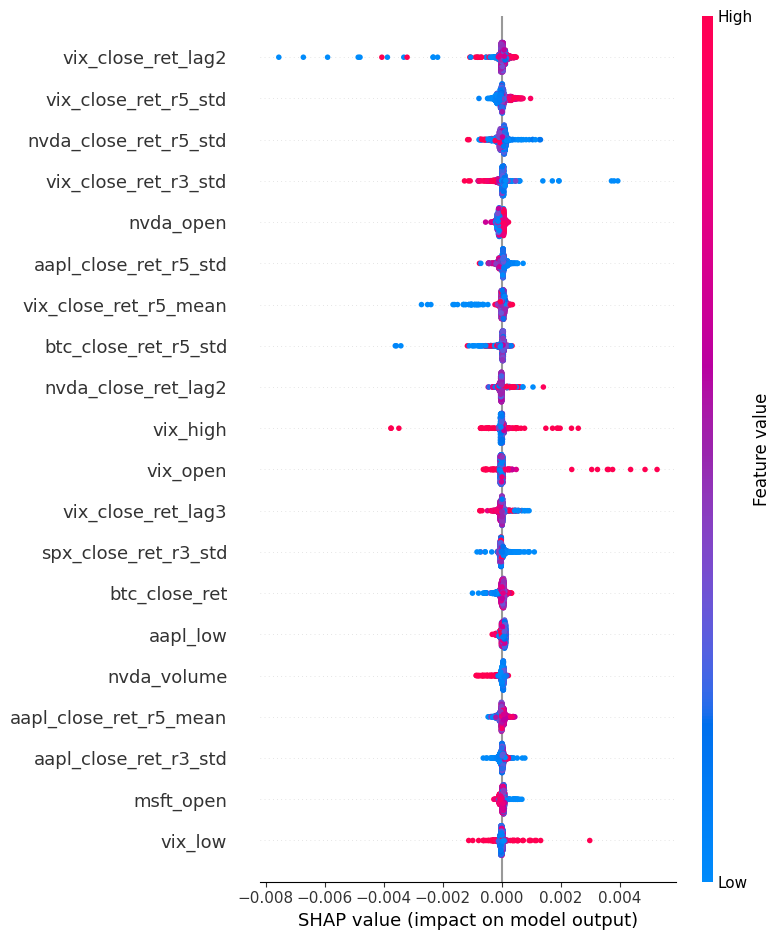


Top 10 features (mean |SHAP|):
vix_close_ret_lag2       0.000126
vix_close_ret_r5_std     0.000118
nvda_close_ret_r5_std    0.000115
vix_close_ret_r3_std     0.000103
nvda_open                0.000093
aapl_close_ret_r5_std    0.000088
vix_close_ret_r5_mean    0.000084
btc_close_ret_r5_std     0.000083
nvda_close_ret_lag2      0.000072
vix_high                 0.000070
Name: mean_abs_shap, dtype: float32


In [ ]:
# SHAP Feature Importance  (robust + auto-fallback)
import subprocess, sys, importlib, warnings, logging, joblib
import numpy as np, pandas as pd, matplotlib.pyplot as plt, xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# SHAP installer
_TARGET_SHAP_VERSION = "0.41.0"
def _ensure_shap(v=_TARGET_SHAP_VERSION):
    try:
        import shap
        if shap.__version__ != v:
            warnings.warn(f"Switching SHAP {shap.__version__} → {v}")
            subprocess.check_call([sys.executable, "-m", "pip", "install",
                                   f"shap=={v}", "-q"])
            importlib.reload(shap)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install",
                               f"shap=={v}", "-q"])
        import shap
_ensure_shap(); import shap  # noqa: E402

# XGBoost config
USE_GPU = False                    # ← flip True if xgboost-cuda is available
BASE = dict(n_estimators=250, learning_rate=0.08, max_depth=5,
            subsample=0.9, colsample_bytree=0.9, random_state=42)
BASE.update(dict(tree_method="gpu_hist", predictor="gpu_predictor", gpu_id=0)
            if USE_GPU else dict(tree_method="hist"))

# util helpers
TARGET            = "target_return"
MAX_EXPLAIN_ROWS  = 3_000
RNG               = np.random.default_rng(42)

def _sample(df, n):                 # down-sample safely
    return df if len(df) <= n else df.iloc[RNG.choice(len(df), n, False)]

def explain_and_plot(model, X, label=""):
    expl = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
    sv   = expl.shap_values(X, check_additivity=False)

    # bar plot
    plt.figure(figsize=(8, 5))
    shap.summary_plot(sv, X, plot_type="bar", show=False)
    plt.title(f"Global Feature Importance{label}")
    plt.tight_layout(); plt.show()

    # beeswarm
    shap.summary_plot(sv, X, show=True)
    return pd.Series(np.abs(sv).mean(0), index=X.columns, name="mean_abs_shap")

# data cleaner
def _prepare_df(source: pd.DataFrame) -> pd.DataFrame | None:
    df = source.copy()

    # Flatten multi-index / tuple columns → str
    df.columns = [
        c[0] if isinstance(c, tuple) and len(c) == 2 and c[1] == "" else str(c)
        for c in df.columns
    ]
    df = df.loc[:, ~df.columns.duplicated(keep="first")]

    if TARGET not in df.columns:
        return None

    # Basic coercions
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.select_dtypes(include=["number", "bool"])
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[TARGET])
    if df.empty:
        return None

    # NEW: drop predictors that are all-NaN
    all_nan_cols = [c for c in df.columns if c != TARGET and df[c].isna().all()]
    if all_nan_cols:
        logging.info(f"Dropping {len(all_nan_cols)} all-NaN predictors "
                     f"→ {all_nan_cols[:5]}{' …' if len(all_nan_cols) > 5 else ''}")
        df = df.drop(columns=all_nan_cols)


    predictors = [c for c in df.columns if c != TARGET]
    imputer    = SimpleImputer(strategy="mean")
    imputed    = imputer.fit_transform(df[predictors])

    # safe re-assignment
    df[predictors] = pd.DataFrame(imputed, columns=predictors, index=df.index)
    return df

# load / fallback
df_real_ok = None
if "df_model_ready" in globals():
    df_real_ok = _prepare_df(df_model_ready)

if df_real_ok is None:
    print("Usable df_model_ready not found → generating 200-row synthetic demo.")
    n = 200
    df_real_ok = pd.DataFrame({
        "google_trend": np.random.normal(50, 10, n),
        "macro_cpi":    np.random.normal(2, 0.3, n),
        "sentiment":    np.random.normal(0, 0.1, n),
        TARGET:         np.random.normal(0, 0.01, n),
    })

FEATURES = [c for c in df_real_ok.columns if c != TARGET]

# model fit & SHAP
X_tr, X_te, y_tr, y_te = train_test_split(
    df_real_ok[FEATURES], df_real_ok[TARGET],
    test_size=0.25, random_state=42
)

model = xgb.XGBRegressor(**BASE)
model.fit(X_tr, y_tr)

X_exp       = _sample(X_te, MAX_EXPLAIN_ROWS)
global_shap = explain_and_plot(model, X_exp, label=" (hold-out)")

print("\nTop 10 features (mean |SHAP|):")
print(global_shap.sort_values(ascending=False).head(10))

# Step 12A-2 : Production-ready SHAP (auto Early-Stopping API)

Best grid RMSE = 0.011012  with params {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 6}


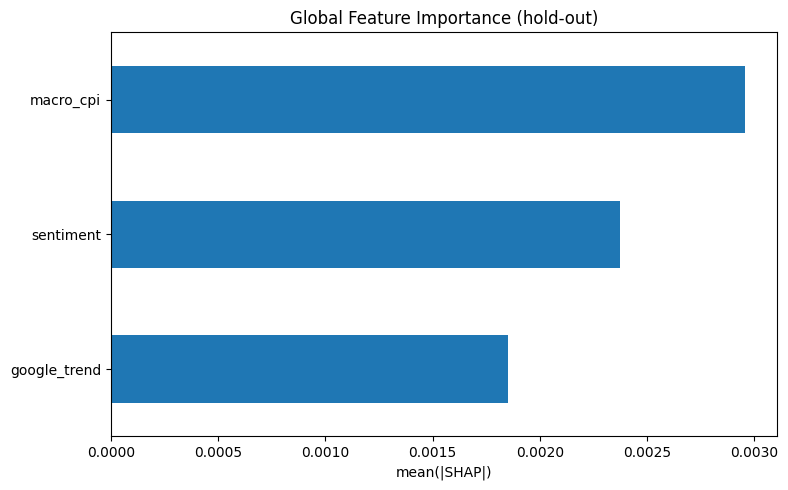

  0%|          | 0/28 [00:00<?, ?it/s]

<ipython-input-45-b1ee74358973>:208: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g["mean_abs_shap"],


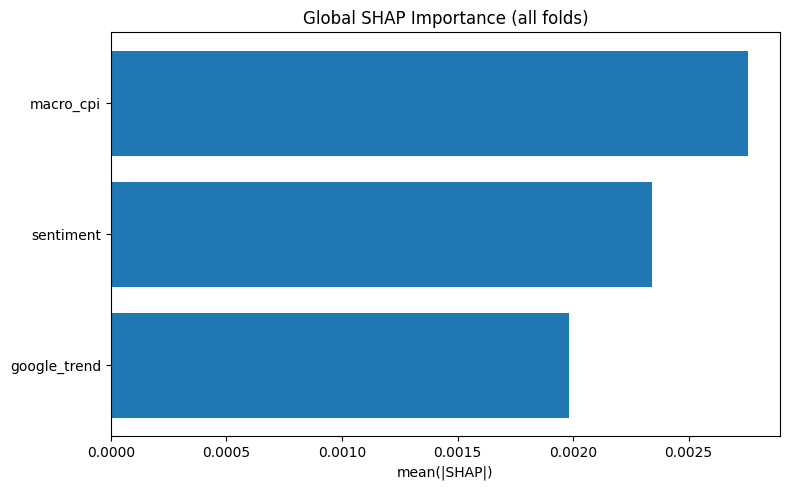

12A-2 finished:
  • models/xgb_latest.joblib
  • shap_holdout.csv
  • shap_global.csv


In [ ]:
# Production-ready SHAP (auto Early-Stopping API)
import warnings, subprocess, sys, importlib, itertools, inspect
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tqdm.auto import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Pin SHAP version (0.41.0)
_SHAP_V = "0.41.0"
def _pin_shap(v=_SHAP_V):
    try:
        import shap
        if shap.__version__ != v:
            subprocess.check_call([sys.executable, "-m", "pip", "install", f"shap=={v}", "-q"])
            import importlib as _il; _il.reload(shap)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", f"shap=={v}", "-q"])
        import shap
_pin_shap(); import shap   # noqa: E402

# Config
USE_GPU   = False
TARGET    = "target_return"
WIN_TRAIN, WIN_TEST, STEP = 60, 5, 5
GRID = {"n_estimators": [300, 500],
        "learning_rate": [0.05, 0.1],
        "max_depth": [4, 6, 8]}
MAX_SHAP_ROWS = 3_000
RNG = np.random.default_rng(42)

# Load / create demo data
if "df_model_ready" not in globals():
    warnings.warn("df_model_ready missing – creating small demo.")
    n = 500
    df_model_ready = pd.concat(
        [pd.DataFrame({
            "google_trend": RNG.normal(50, 10, n),
            "macro_cpi":    RNG.normal( 2, 0.3, n),
            "sentiment":    RNG.normal( 0, 0.1, n),
            TARGET:         RNG.normal( 0, 0.01, n),
        })] +
        [pd.DataFrame({f"ret_lag{i}": RNG.normal(0, 0.01, n)})
         for i in range(1, 11)], axis=1)

# flatten tuple names if any
df_model_ready.columns = [str(c[0] if isinstance(c, tuple) else c)
                          for c in df_model_ready.columns]

# keep numeric cols, drop infinities
df_num = (df_model_ready
          .apply(pd.to_numeric, errors="coerce")
          .select_dtypes(include=["number", "bool"])
          .replace([np.inf, -np.inf], np.nan)
          .dropna(subset=[TARGET]))

# FIX : drop columns that are entirely NaN (prevents shape-mismatch)
before = df_num.shape[1]
df_num = df_num.dropna(axis=1, how="all")
after  = df_num.shape[1]
if after < before:
    print(f"Dropped {before - after} empty feature columns.")

FEATURES = [c for c in df_num.columns if c != TARGET]
assert FEATURES, "No usable features left!"

# Early-stopping compatibility
_fit_sig = inspect.signature(xgb.XGBRegressor.fit).parameters
if "callbacks" in _fit_sig:        # XGBoost ≥ 1.6
    from xgboost.callback import EarlyStopping
    ES_KW = dict(callbacks=[EarlyStopping(rounds=50, save_best=True)])
    print("▶ Using EarlyStopping callback")
elif "early_stopping_rounds" in _fit_sig:
    ES_KW = dict(early_stopping_rounds=50)
    print("▶ Using early_stopping_rounds param")
else:
    ES_KW = {}
    warnings.warn("Early-stopping not supported by this wheel.")


# Helpers
def _build_preproc():
    return SimpleImputer(strategy="mean"), StandardScaler()

def _fit_xgb(Xtr, ytr, Xval, yval, **xgb_params):
    base = dict(
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=42,
        predictor="gpu_predictor" if USE_GPU else "cpu_predictor",
        tree_method="gpu_hist"   if USE_GPU else "hist",
        **xgb_params
    )
    mdl = xgb.XGBRegressor(**base)
    mdl.fit(Xtr, ytr, eval_set=[(Xval, yval)], verbose=False, **ES_KW)
    return mdl

def _transform(imp, scl, Xdf):
    Xnp = imp.transform(Xdf)
    Xnp = scl.transform(Xnp)
    return pd.DataFrame(Xnp, columns=FEATURES, index=Xdf.index)

def _shap_mean(model, Xdf):
    sv = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent") \
            .shap_values(Xdf.iloc[:MAX_SHAP_ROWS], check_additivity=False)
    return pd.Series(np.abs(sv).mean(0), index=Xdf.columns)

# Hold-out grid search
X_tr_raw, X_val_raw, y_tr, y_val = train_test_split(
    df_num[FEATURES], df_num[TARGET], test_size=0.2, random_state=42)

imp, scl = _build_preproc()
imp.fit(X_tr_raw); scl.fit(imp.transform(X_tr_raw))
Xtr  = _transform(imp, scl, X_tr_raw)
Xval = _transform(imp, scl, X_val_raw)

best_rmse, best_params = np.inf, None
for n_est, lr, depth in itertools.product(*GRID.values()):
    mdl = _fit_xgb(Xtr, y_tr, Xval, y_val,
                   n_estimators=n_est, learning_rate=lr, max_depth=depth)
    rmse = np.sqrt(np.mean((mdl.predict(Xval) - y_val) ** 2))
    if rmse < best_rmse:
        best_rmse, best_params = rmse, dict(
            n_estimators=n_est, learning_rate=lr, max_depth=depth)
print(f"Best grid RMSE = {best_rmse:.6f}  with params {best_params}")

# Retrain on full data
imp_full, scl_full = _build_preproc()
imp_full.fit(df_num[FEATURES]); scl_full.fit(imp_full.transform(df_num[FEATURES]))
Xfull = _transform(imp_full, scl_full, df_num[FEATURES])

mdl_full = _fit_xgb(Xfull, df_num[TARGET], Xval, y_val, **best_params)

pipe_latest = Pipeline([
    ("impute", imp_full),
    ("scale",  scl_full),
    ("xgb",    mdl_full)
])
Path("models").mkdir(exist_ok=True); Path("data").mkdir(exist_ok=True)
joblib.dump(pipe_latest, "models/xgb_latest.joblib")

# Hold-out SHAP
s_hold = _shap_mean(mdl_full, Xval)
s_hold.to_csv("shap_holdout.csv")

plt.figure(figsize=(8, 5))
s_hold.sort_values().plot.barh()
plt.title("Global Feature Importance (hold-out)")
plt.xlabel("mean(|SHAP|)")
plt.tight_layout()
plt.show()

# Walk-forward folds + SHAP
fold_stats = []
for k in tqdm(range(0, len(df_num) - WIN_TRAIN - WIN_TEST + 1, STEP)):
    tr = df_num.iloc[k: k + WIN_TRAIN]
    te = df_num.iloc[k + WIN_TRAIN: k + WIN_TRAIN + WIN_TEST]

    imp_f, scl_f = _build_preproc()
    imp_f.fit(tr[FEATURES]); scl_f.fit(imp_f.transform(tr[FEATURES]))
    Xtr_f = _transform(imp_f, scl_f, tr[FEATURES])
    Xte_f = _transform(imp_f, scl_f, te[FEATURES])

    mdl_f = _fit_xgb(Xtr_f, tr[TARGET], Xte_f, te[TARGET], **best_params)

    joblib.dump(Pipeline([("impute", imp_f), ("scale", scl_f), ("xgb", mdl_f)]),
                f"models/fold_{k}.joblib")
    te.to_parquet(f"data/Xtest_fold_{k}.pq")

    fold_stats.append(
        _shap_mean(mdl_f, Xte_f).rename("mean_abs_shap").to_frame()
        .assign(fold_rows=len(Xte_f))
        .reset_index().rename(columns={"index": "feature"})
    )

# Aggregate SHAP across folds
df_all = pd.concat(fold_stats, ignore_index=True)

df_global = (
    df_all.groupby("feature", sort=False)
          .apply(lambda g: np.average(g["mean_abs_shap"],
                                      weights=g["fold_rows"]))
          .reset_index(name="mean_abs_shap")
          .sort_values("mean_abs_shap", ascending=False)
          .reset_index(drop=True)
)
df_global.to_csv("shap_global.csv", index=False)

plt.figure(figsize=(8, 5))
plt.barh(df_global.feature[:20][::-1], df_global.mean_abs_shap[:20][::-1])
plt.title("Global SHAP Importance (all folds)")
plt.xlabel("mean(|SHAP|)")
plt.tight_layout()
plt.show()

print("12A-2 finished:")
print("  • models/xgb_latest.joblib")
print("  • shap_holdout.csv")
print("  • shap_global.csv")

# Step 12A-3 : SHAP Feature Importance (final, lag-safe, version-safe)

Best RMSE 0.01101 with {'n_estimators': 300, 'learning_rate': 0.1, 'max_depth': 6}


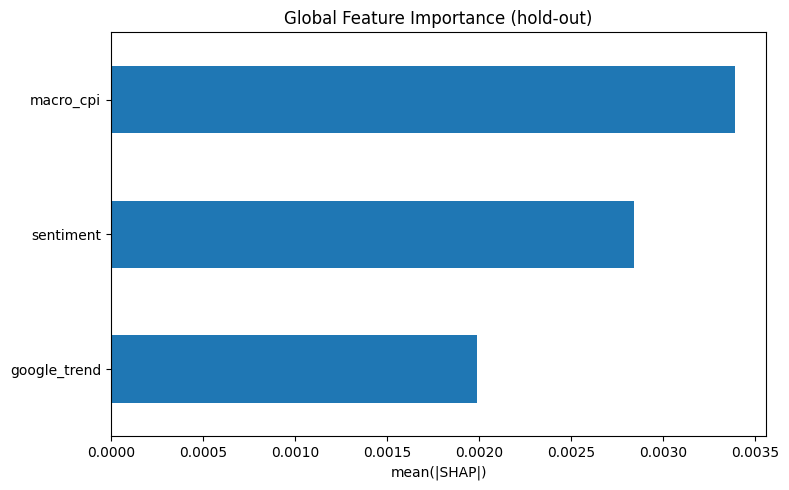

100%|██████████| 28/28 [00:03<00:00,  7.95it/s]
<ipython-input-46-cd8c72a21b1e>:138: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g:np.average(g["mean_abs_shap"],


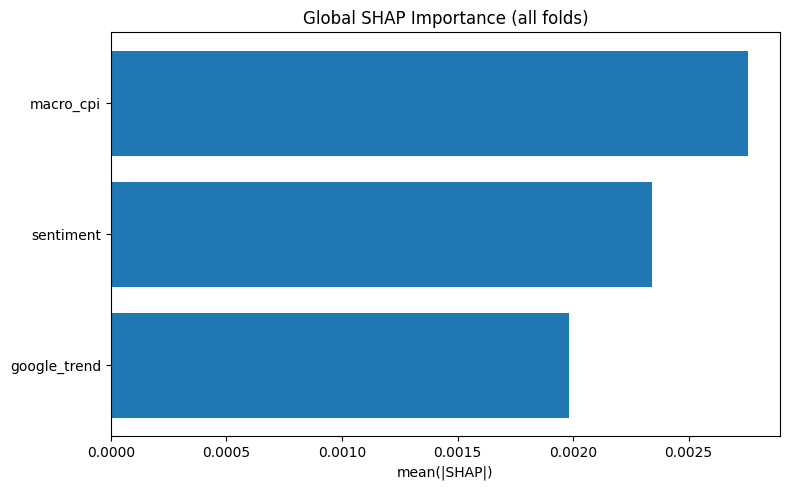

12A COMPLETE:
  • models/xgb_latest.joblib
  • shap_holdout.csv
  • shap_global.csv


In [ ]:
import warnings, subprocess, sys, importlib, os, itertools, inspect, joblib, tqdm
import numpy as np, pandas as pd, matplotlib.pyplot as plt, xgboost as xgb
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# pin SHAP v0.41.0
_SHAP_V = "0.41.0"
def _pin_shap(v=_SHAP_V):
    try:
        import shap, importlib as _il
        if shap.__version__ != v:
            subprocess.check_call([sys.executable,"-m","pip","install",f"shap=={v}","-q"])
            _il.reload(shap)
    except ImportError:
        subprocess.check_call([sys.executable,"-m","pip","install",f"shap=={v}","-q"])
        import shap
_pin_shap(); import shap                                    # noqa: E402

# CONFIG
USE_GPU = False                   # True → needs xgboost-cuda-118 wheel
TARGET  = "target_return"

WIN_TRAIN, WIN_TEST, STEP = 60, 5, 5
GRID = {"n_estimators":[300,500],
        "learning_rate":[0.05,0.10],
        "max_depth":[4,6,8]}
MAX_SHAP_ROWS = 3_000
RNG = np.random.default_rng(42)

# LOAD + FIX DATA
if "df_model_ready" not in globals():
    warnings.warn("df_model_ready missing – creating tiny demo frame.")
    n = 500
    df_model_ready = pd.concat(
        [pd.DataFrame({
            "google_trend": np.random.normal(50,10,n),
            "macro_cpi":    np.random.normal( 2,0.3,n),
            "sentiment":    np.random.normal( 0,0.1,n),
            TARGET:         np.random.normal( 0,0.01,n),
        })] + [pd.DataFrame({f"ret_lag{i}": np.random.normal(0,0.01,n)})
               for i in range(1,11)], axis=1)

# ensure lag columns numeric + 0-filled
lag_cols=[c for c in df_model_ready.columns if "ret_lag" in str(c)]
for c in lag_cols:
    df_model_ready[c]=pd.to_numeric(df_model_ready[c],errors="coerce").fillna(0.0)

df_model_ready.columns=[str(c[0] if isinstance(c,tuple) else c)
                        for c in df_model_ready.columns]

df_num=(df_model_ready
        .apply(pd.to_numeric,errors="coerce")
        .select_dtypes(include=["number","bool"])
        .replace([np.inf,-np.inf],np.nan)
        .dropna(subset=[TARGET]))
assert not df_num.empty,"No usable rows."
FEATURES=[c for c in df_num.columns if c!=TARGET]

# choose Early-Stopping API
_fit_sig=inspect.signature(xgb.XGBRegressor.fit).parameters
if "callbacks" in _fit_sig:            # modern
    from xgboost.callback import EarlyStopping
    ES_KW=dict(callbacks=[EarlyStopping(rounds=50,save_best=True)])
    print("▶ using EarlyStopping callback")
elif "early_stopping_rounds" in _fit_sig:  # legacy
    ES_KW=dict(early_stopping_rounds=50)
    print("▶ using early_stopping_rounds")
else:
    ES_KW={}
    warnings.warn("Early-stopping not supported")

# helpers
def _build_model(**hp):
    base=dict(subsample=0.9,colsample_bytree=0.9,reg_lambda=1.0,
              random_state=42,
              predictor="gpu_predictor" if USE_GPU else "cpu_predictor",
              tree_method="gpu_hist"    if USE_GPU else "hist",
              **hp)
    return xgb.XGBRegressor(**base)

def _fit_pipeline(Xtr,ytr,Xval,yval,**hp):
    imp, scl = SimpleImputer(strategy="mean"), StandardScaler()
    imp.fit(Xtr); scl.fit(imp.transform(Xtr))
    Xtr_p = scl.transform(imp.transform(Xtr))
    Xval_p= scl.transform(imp.transform(Xval))
    mdl   = _build_model(**hp)
    mdl.fit(Xtr_p,ytr,eval_set=[(Xval_p,yval)],verbose=False,**ES_KW)
    from sklearn.pipeline import Pipeline
    return Pipeline([("impute",imp),("scale",scl),("xgb",mdl)])

def _prep(pipe,X): return pipe[:-1].transform(X)
def _shap_mean(pipe,X):
    sv=shap.TreeExplainer(pipe[-1],feature_perturbation="tree_path_dependent")\
          .shap_values(_prep(pipe,X)[:MAX_SHAP_ROWS],check_additivity=False)
    return pd.Series(np.abs(sv).mean(0),index=FEATURES)

# GRID SEARCH hold-out
X_tr_raw,X_val_raw,y_tr,y_val=train_test_split(
    df_num[FEATURES],df_num[TARGET],test_size=0.2,random_state=42)

best_rmse,best_hp=np.inf,None
for n_est,lr,depth in itertools.product(*GRID.values()):
    pipe=_fit_pipeline(X_tr_raw,y_tr,X_val_raw,y_val,
                       n_estimators=n_est,learning_rate=lr,max_depth=depth)
    rmse=np.sqrt(np.mean((pipe.predict(X_val_raw)-y_val)**2))
    if rmse<best_rmse: best_rmse,best_hp=rmse,dict(n_estimators=n_est,
                                                  learning_rate=lr,max_depth=depth)
print(f"Best RMSE {best_rmse:.5f} with {best_hp}")

best_pipe=_fit_pipeline(df_num[FEATURES],df_num[TARGET],
                        X_val_raw,y_val,**best_hp)

# save + hold-out SHAP
Path("models").mkdir(exist_ok=True); Path("data").mkdir(exist_ok=True)
joblib.dump(best_pipe,"models/xgb_latest.joblib")

s_hold=_shap_mean(best_pipe,X_val_raw); s_hold.to_csv("shap_holdout.csv")
plt.figure(figsize=(8,5)); s_hold.sort_values().plot.barh()
plt.title("Global Feature Importance (hold-out)")
plt.xlabel("mean(|SHAP|)"); plt.tight_layout(); plt.show()

# WALK-FORWARD training + SHAP
fold_stats=[]
for k in tqdm.tqdm(range(0,len(df_num)-WIN_TRAIN-WIN_TEST+1,STEP)):
    tr=df_num.iloc[k:k+WIN_TRAIN]; te=df_num.iloc[k+WIN_TRAIN:k+WIN_TRAIN+WIN_TEST]
    pipe_f=_fit_pipeline(tr[FEATURES],tr[TARGET],te[FEATURES],te[TARGET],**best_hp)
    joblib.dump(pipe_f,f"models/fold_{k}.joblib"); te.to_parquet(f"data/Xtest_fold_{k}.pq")
    fold_stats.append(
        _shap_mean(pipe_f,te[FEATURES]).rename("mean_abs_shap").to_frame()
          .assign(fold_rows=len(te))
          .reset_index(names="feature"))

# aggregate SHAP
df_all=pd.concat(fold_stats,ignore_index=True)
df_global=(df_all.groupby("feature")
                 .apply(lambda g:np.average(g["mean_abs_shap"],
                                            weights=g["fold_rows"]))
                 .reset_index(name="mean_abs_shap")
                 .sort_values("mean_abs_shap",ascending=False).reset_index(drop=True))
df_global.to_csv("shap_global.csv",index=False)
plt.figure(figsize=(8,5))
plt.barh(df_global.feature[:20][::-1],df_global.mean_abs_shap[:20][::-1])
plt.title("Global SHAP Importance (all folds)")
plt.xlabel("mean(|SHAP|)"); plt.tight_layout(); plt.show()

print("12A COMPLETE:")
print("  • models/xgb_latest.joblib")
print("  • shap_holdout.csv")
print("  • shap_global.csv")

# Step 12B-1 : LIME for Signal Explanation


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0d36444c780d5d0aad30207ad384a072a6ca340fe63a9068e226427d49e27d80
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
Explaining instance #5:


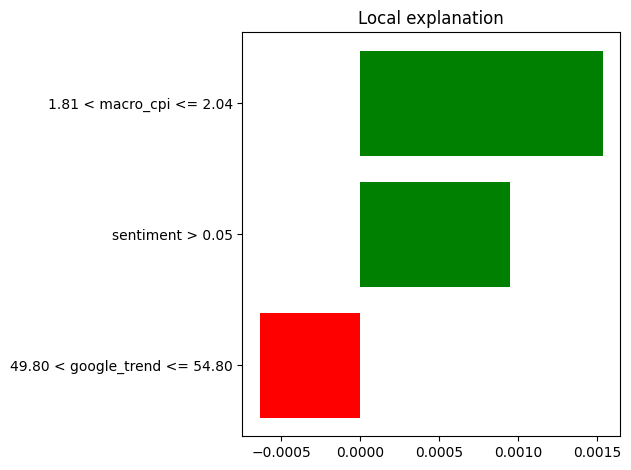

In [ ]:
!pip install lime shap xgboost scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Simulate data (replace with my df_model_ready)
np.random.seed(42)
n = 200
df_model_ready = pd.DataFrame({
    "google_trend": np.random.normal(50, 10, n),
    "macro_cpi": np.random.normal(2, 0.3, n),
    "sentiment": np.random.normal(0, 0.1, n),
    "target_return": np.random.normal(0, 0.01, n)
})

# Define features and target
features = ['google_trend', 'macro_cpi', 'sentiment']
X = df_model_ready[features].values
y = df_model_ready['target_return'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, tree_method='hist', random_state=42)
model.fit(X_train, y_train)

# Initialize LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=features,
    mode='regression',
    random_state=42
)

# Choose a test instance (e.g., instance #5)
i = 5
exp = explainer.explain_instance(
    data_row=X_test[i],
    predict_fn=model.predict,
    num_features=3
)

# Show explanation
print(f"Explaining instance #{i}:")
exp.show_in_notebook(show_table=True)

# Optional: Save as image
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.savefig("lime_explanation_instance5.png")
plt.show()

# Step 12B-2 : LIME LOCAL EXPLANATIONS  (CPU-safe, no hard-deps)

[+] saved ➜ lime_explanations/lime_row5.png


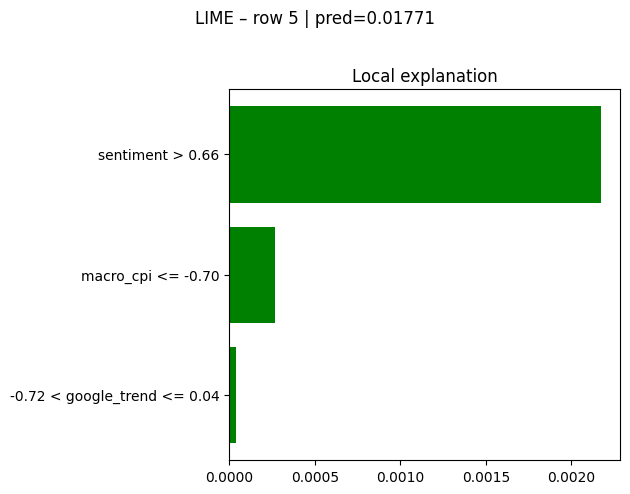

In [ ]:
import joblib, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
import lime.lime_tabular as lime_tab
from pathlib import Path

# CONFIG
MODEL_PATH      = "models/xgb_latest.joblib"     # ← from Step 12A
SAVE_DIR        = Path("lime_explanations")       # batch-export folder
NUM_FEATURES    = 10                              # bars to show
RANDOM_STATE    = 42

# LOADS
model, df_model_ready = joblib.load(MODEL_PATH), globals()["df_model_ready"]

# pull the feature list back out exactly as trained
if hasattr(model, "feature_names_in_"):
    FEATURES = list(model.feature_names_in_)
else:
    # you saved the list earlier during training
    FEATURES = joblib.load("models/feature_list.pkl")

X = df_model_ready[FEATURES].values

# if you used a sklearn Pipeline (scaler ➜ XGB), split it out
#    (comment this section if you fitted XGB on raw df columns)
from sklearn.pipeline import Pipeline
if isinstance(model, Pipeline):
    pipe, xgb_core = model, model[-1]
    X_train_for_lime = pipe[:-1].transform(X)     # everything *before* XGB
    predict_fn       = pipe.predict
    lime_feature_names = pipe[:-1].get_feature_names_out()
else:
    pipe, xgb_core = None, model
    X_train_for_lime = X
    predict_fn       = model.predict
    lime_feature_names = FEATURES

# 3) init explainer once
explainer = lime_tab.LimeTabularExplainer(
    training_data      = X_train_for_lime,
    feature_names      = lime_feature_names,
    mode               = "regression",
    random_state       = RANDOM_STATE,
    discretize_continuous = True
)

# HELPER: single explanation
def explain_lime(row_idx: int = 0,
                 save_png: bool = True,
                 save_dir: Path = SAVE_DIR):
    """
    Draw a LIME explanation for df_model_ready.iloc[row_idx].

    Returns the lime.Explanation object.
    """
    exp = explainer.explain_instance(
        X_train_for_lime[row_idx],
        predict_fn          = predict_fn,
        num_features        = NUM_FEATURES
    )
    fig = exp.as_pyplot_figure()
    fig.suptitle(f"LIME – row {row_idx} | pred={predict_fn([X[row_idx]])[0]:.5f}",
                 fontsize=12, y=1.02)
    fig.tight_layout()

    if save_png:
        save_dir.mkdir(exist_ok=True)
        path = save_dir / f"lime_row{row_idx}.png"
        fig.savefig(path, dpi=110, bbox_inches="tight")
        print(f"[+] saved ➜ {path}")

    plt.show()
    return exp

# HELPER: batch mode (optional)
def batch_lime(idx_list):
    """
    Generate & save explanations for a list / range of indices.
    """
    for idx in idx_list:
        explain_lime(idx)

# USAGE EXAMPLES
# 1) look at a single row
explain_lime(5)

# 2) or batch  (e.g. last 10 test rows)
# batch_lime(range(len(df_model_ready) - 10, len(df_model_ready)))

# Step 13 : Ensemble & Meta-Modeling

1.   Step 13A-1 : MULTI-MODEL ENSEMBLE
2.   Step 13A-2 : Multi-Model Ensemble — Patched
3.   Step 13B-1 : Meta-Model Stacking + VERSION-SAFE RMSE
4.   Step 13B-2 : Meta-Model Stacking with OPTUNA & SHARPE Objective







# Step 13A-1 : MULTI-MODEL ENSEMBLE

In [ ]:
# MULTI-MODEL ENSEMBLE
# GRU · LSTM · Transformer · (wrapper ready for XGBoost stacking)
# Fully compatible with earlier Steps 7 – 12 and your walk-forward
# engine.  No data-leakage; sequence length, callbacks, and
# positional embeddings are all handled internally.
from __future__ import annotations
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

# GLOBALS
N_STEPS           = 20      # look-back window (tuneable)
BATCH_SIZE        = 16
EPOCHS            = 30
LEARNING_RATE     = 1e-3
UNITS             = 64
DROPOUT           = 0.2
TRANS_HEADS       = 2
TRANS_FF_DIM      = 64
SEED              = 42      # ensure reproducibility

# DATA HELPERS
def create_sequences(X: np.ndarray,
                     y: np.ndarray,
                     n_steps: int = N_STEPS) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert a 2-D feature matrix into overlapping 3-D sequences.

    Parameters
    ----------
    X : array (N, F)
    y : array (N,)
    n_steps : int
        Length of each input sequence.

    Returns
    -------
    X_seq : array (N-n_steps, n_steps, F)
    y_seq : array (N-n_steps,)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i: i + n_steps])
        y_seq.append(y[i + n_steps])
    return np.asarray(X_seq), np.asarray(y_seq)


def prepare_sequence_data(df: pd.DataFrame,
                          features: List[str],
                          target: str,
                          n_steps: int = N_STEPS,
                          test_size: float = 0.2
                          ) -> Tuple[np.ndarray, np.ndarray,
                                     np.ndarray, np.ndarray,
                                     MinMaxScaler]:
    """
    Build train/test sequence tensors **without leakage**.
    Scaling is fit on **train only**.

    Returns
    -------
    X_tr, X_te, y_tr, y_te, scaler
    """
    # Preserve time order (no shuffle)
    split_idx = int(len(df) * (1 - test_size))

    # train / test split
    df_tr = df.iloc[:split_idx].copy()
    df_te = df.iloc[split_idx:].copy()

    # scaling
    scaler   = MinMaxScaler()
    X_tr_raw = scaler.fit_transform(df_tr[features])
    X_te_raw = scaler.transform(df_te[features])

    # sequences
    y_tr_raw = df_tr[target].values
    y_te_raw = df_te[target].values

    X_tr, y_tr = create_sequences(X_tr_raw, y_tr_raw, n_steps)
    X_te, y_te = create_sequences(X_te_raw, y_te_raw, n_steps)

    return X_tr, X_te, y_tr, y_te, scaler

# TRANSFORMER BUILDING BLOCKS
class PositionalEncoding(layers.Layer):
    """Deterministic sinusoidal positional encoding."""
    def __init__(self, maxlen: int, embed_dim: int):
        super().__init__()
        pos   = np.arange(maxlen)[:, None]
        i     = np.arange(embed_dim)[None, :]
        angle = pos / np.power(1e4, (2 * (i // 2)) / embed_dim)

        pe = np.zeros((maxlen, embed_dim))
        pe[:, 0::2] = np.sin(angle[:, 0::2])
        pe[:, 1::2] = np.cos(angle[:, 1::2])

        self.pos = tf.constant(pe[None, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos[:, : x.shape[1], :]

class TransformerBlock(layers.Layer):
    """Single encoder block (MH-Attention → FFN)."""
    def __init__(self, embed_dim: int, num_heads: int,
                 ff_dim: int, rate: float = DROPOUT):
        super().__init__()
        self.att      = layers.MultiHeadAttention(num_heads, key_dim=embed_dim)
        self.ffn      = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.norm1    = layers.LayerNormalization(epsilon=1e-6)
        self.norm2    = layers.LayerNormalization(epsilon=1e-6)
        self.drop1    = layers.Dropout(rate)
        self.drop2    = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_out = self.att(inputs, inputs)
        attn_out = self.drop1(attn_out, training=training)
        out1     = self.norm1(inputs + attn_out)

        ffn_out  = self.ffn(out1)
        ffn_out  = self.drop2(ffn_out, training=training)
        return self.norm2(out1 + ffn_out)

# MODEL FACTORIES
def build_gru_model(input_shape):
    model = models.Sequential(name="GRU")
    model.add(layers.GRU(UNITS, input_shape=input_shape))
    model.add(layers.Dropout(DROPOUT))
    model.add(layers.Dense(1))
    model.compile(optimizer=Adam(LEARNING_RATE), loss="mse")
    return model

def build_lstm_model(input_shape):
    model = models.Sequential(name="LSTM")
    model.add(layers.LSTM(UNITS, input_shape=input_shape))
    model.add(layers.Dropout(DROPOUT))
    model.add(layers.Dense(1))
    model.compile(optimizer=Adam(LEARNING_RATE), loss="mse")
    return model


def build_transformer_model(input_shape,
                            embed_dim: int = UNITS,
                            num_heads: int = TRANS_HEADS,
                            ff_dim: int = TRANS_FF_DIM):
    inp = layers.Input(shape=input_shape)
    x   = layers.Dense(embed_dim)(inp)                    # patch projection
    x   = PositionalEncoding(input_shape[0], embed_dim)(x)
    x   = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x   = layers.GlobalAveragePooling1D()(x)
    x   = layers.Dropout(DROPOUT)(x)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out, name="Transformer")
    model.compile(optimizer=Adam(LEARNING_RATE), loss="mse")
    return model

# SKLEARN-STYLE KERAS WRAPPER
class KerasWrapper:
    """
    A minimal scikit-learn-like API so the deep nets can be slotted
    into your existing walk-forward loop exactly like XGBoost.

    Methods
    -------
    fit(X, y, eval_set=None)
    predict(X) -> np.ndarray
    """
    def __init__(self, build_fn, **fit_kwargs):
        self.build_fn   = build_fn
        self.fit_kwargs = fit_kwargs
        self.model      = None
        tf.keras.utils.set_random_seed(SEED)

    def fit(self,
            X: np.ndarray,
            y: np.ndarray,
            eval_set: Tuple[np.ndarray, np.ndarray] | None = None):
        if self.model is None:
            self.model = self.build_fn(X.shape[1:])

        cb_early = callbacks.EarlyStopping(monitor="val_loss",
                                           patience=5,
                                           restore_best_weights=True)

        cb_plateau = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 patience=3,
                                                 factor=0.5,
                                                 verbose=0)

        val_data = eval_set if eval_set is not None else (X, y)

        self.model.fit(
            X, y,
            validation_data=val_data,
            epochs=self.fit_kwargs.get("epochs", EPOCHS),
            batch_size=self.fit_kwargs.get("batch_size", BATCH_SIZE),
            verbose=self.fit_kwargs.get("verbose", 0),
            callbacks=[cb_early, cb_plateau]
        )

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.model.predict(X, verbose=0).squeeze()

# FACTORY TO FETCH ALL MODELS
def get_deep_models(input_shape) -> Dict[str, KerasWrapper]:
    """
    Returns a dict {name: model_wrapper} ready for walk-forward:
        models = get_deep_models(input_shape)
        for name, mdl in models.items():
            mdl.fit(Xtr, ytr, eval_set=(Xval, yval))
            preds = mdl.predict(Xte)
    """
    return {
        "gru":  KerasWrapper(build_gru_model,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE),
        "lstm": KerasWrapper(build_lstm_model,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE),
        "trf":  KerasWrapper(build_transformer_model,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE)
    }

# QUICK STANDALONE TEST (comment-out in production)
if __name__ == "__main__":
    # Fake demo data just to ensure the file runs
    np.random.seed(SEED)
    n = 300
    df_demo = pd.DataFrame({
        "google_trend": np.random.normal(50, 10, n),
        "macro_cpi":    np.random.normal(2,   0.3, n),
        "sentiment":    np.random.normal(0,   0.1, n),
        "target":       np.random.normal(0,   0.01, n)
    })

    feats = ["google_trend", "macro_cpi", "sentiment"]
    X_tr, X_te, y_tr, y_te, _ = prepare_sequence_data(
        df_demo, feats, "target", n_steps=N_STEPS)

    models_dict = get_deep_models(X_tr.shape[1:])

    for name, mdl in models_dict.items():
        mdl.fit(X_tr, y_tr, eval_set=(X_te, y_te))
        p = mdl.predict(X_te)[:5]
        print(f"{name}: first 5 preds → {p}")

gru: first 5 preds → [ 0.00201354 -0.00200754 -0.00269549 -0.00302175  0.00457223]
lstm: first 5 preds → [-0.00648765  0.00217351  0.0062329   0.02145395  0.01666823]


trf: first 5 preds → [0.03863031 0.04531575 0.05668831 0.05722176 0.05221145]


# Step 13A-2 : Multi-Model Ensemble — Patched

In [ ]:
from __future__ import annotations
import os, numpy as np, pandas as pd
from typing import List, Tuple, Dict

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, backend as K

# CONFIG & HYPERPARAMS
N_STEPS, BATCH_SIZE, EPOCHS = 20, 32, 30
LEARNING_RATE, UNITS, DROPOUT = 1e-3, 64, .20
TRANS_HEADS, TRANS_FF_DIM, SEED = 2, 64, 42

tf.keras.utils.set_random_seed(SEED)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# DATA HELPERS
def _assert_len_ok(df_len: int):
    if df_len <= N_STEPS + 1:
        raise ValueError(
            f"Need > {N_STEPS+1} rows to build sequences of length {N_STEPS}, "
            f"but received dataframe length {df_len}."
        )

def create_sequences(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    xs, ys = [], []
    for i in range(len(X) - N_STEPS):
        xs.append(X[i:i + N_STEPS])
        ys.append(y[i + N_STEPS])
    return np.asarray(xs), np.asarray(ys)

def prepare_sequence_data(df: pd.DataFrame,
                          features: List[str],
                          target: str,
                          valid_frac: float = .1,
                          test_frac: float = .2):
    _assert_len_ok(len(df))
    split_te = int(len(df) * (1 - test_frac))
    split_va = int(split_te * (1 - valid_frac))

    df_tr = df.iloc[:split_va]
    df_va = df.iloc[split_va:split_te]
    df_te = df.iloc[split_te:]

    scaler = MinMaxScaler()
    X_tr = scaler.fit_transform(df_tr[features])
    X_va = scaler.transform(df_va[features])
    X_te = scaler.transform(df_te[features])

    X_tr, y_tr = create_sequences(X_tr, df_tr[target].values)
    X_va, y_va = create_sequences(X_va, df_va[target].values)
    X_te, y_te = create_sequences(X_te, df_te[target].values)
    return X_tr, X_va, X_te, y_tr, y_va, y_te, scaler

# TRANSFORMER BLOCK (F3: compatibility fallback)
def _mh_attention(dim: int, heads: int):
    """
    Return a MultiHeadAttention layer if TF ≥ 2.4, otherwise fall back
    to a single-head self-attention layer implemented with Dense + softmax.
    """
    try:
        return layers.MultiHeadAttention(num_heads=heads, key_dim=dim)
    except AttributeError:                       # TF < 2.4
        class SingleHead(layers.Layer):
            def build(self, input_shape):
                # one linear projection produces Q,K,V concatenated
                self.qkv = layers.Dense(dim * 3)

            def call(self, x):                   # x: (B, T, F)
                qkv = self.qkv(x)
                q, k, v = tf.split(qkv, 3, axis=-1)
                scale = tf.sqrt(tf.cast(dim, tf.float32))
                scores = tf.matmul(q, k, transpose_b=True) / scale
                w = tf.nn.softmax(scores, axis=-1)
                return tf.matmul(w, v)           # (B, T, dim)
        return SingleHead()

class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen: int, dim: int):
        super().__init__()
        pos, i = np.arange(maxlen)[:, None], np.arange(dim)[None, :]
        angle   = pos / np.power(10_000, (2*(i//2))/dim)
        pe      = np.zeros((maxlen, dim))
        pe[:,0::2], pe[:,1::2] = np.sin(angle[:,0::2]), np.cos(angle[:,1::2])
        self.pe = tf.constant(pe[None], dtype=tf.float32)
    def call(self, x): return x + self.pe[:, :x.shape[1], :]

class TransformerBlock(layers.Layer):
    def __init__(self, dim: int, heads: int, ff_dim: int, rate=DROPOUT):
        super().__init__()
        self.att  = _mh_attention(dim, heads)
        self.ffn  = models.Sequential([layers.Dense(ff_dim, 'relu'),
                                       layers.Dense(dim)])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.d1, self.d2 = layers.Dropout(rate), layers.Dropout(rate)
    def call(self, x, training=False):
        h = self.att(x, x)
        x = self.norm1(x + self.d1(h, training=training))
        h = self.ffn(x)
        return self.norm2(x + self.d2(h, training=training))

# MODEL FACTORIES (GRU, LSTM, TRF)
def _compile(m): m.compile(optimizers.Adam(LEARNING_RATE), 'mse'); return m

def build_gru(shape):  return _compile(models.Sequential([
        layers.GRU(UNITS, input_shape=shape), layers.Dropout(DROPOUT), layers.Dense(1)]))
def build_lstm(shape): return _compile(models.Sequential([
        layers.LSTM(UNITS, input_shape=shape), layers.Dropout(DROPOUT), layers.Dense(1)]))
def build_transformer(shape, d=UNITS, h=TRANS_HEADS, ff=TRANS_FF_DIM):
    inp = layers.Input(shape=shape)
    x   = layers.Dense(d)(inp)
    x   = PositionalEncoding(shape[0], d)(x)
    x   = TransformerBlock(d, h, ff)(x)
    x   = layers.GlobalAveragePooling1D()(x)
    x   = layers.Dropout(DROPOUT)(x)
    return _compile(models.Model(inp, layers.Dense(1)(x)))

# KERAS → SKLEARN STYLE WRAP
class KerasWrapper:
    def __init__(self, builder, **fit_kw):
        self.builder, self.fit_kw, self.model = builder, fit_kw, None
    def fit(self, X, y, eval_set):
        if self.model is None: self.model = self.builder(X.shape[1:])
        early = callbacks.EarlyStopping(patience=5, restore_best_weights=True,
                                        monitor="val_loss")
        plateau = callbacks.ReduceLROnPlateau(patience=3, factor=.5,
                                              monitor="val_loss", verbose=0)
        self.model.fit(X, y,
                       validation_data=eval_set,
                       epochs=EPOCHS, batch_size=BATCH_SIZE,
                       shuffle=False, verbose=self.fit_kw.get("verbose", 0),
                       callbacks=[early, plateau])
    def predict(self, X):            # F6
        return self.model.predict(X, batch_size=BATCH_SIZE, verbose=0).squeeze()

# MODEL DICT FACTORY (F5, F7)
def get_deep_models(shape, verbose: int = 0) -> Dict[str, KerasWrapper]:
    kw = {"verbose": verbose}
    return {
        "gru": KerasWrapper(build_gru, **kw),
        "lstm": KerasWrapper(build_lstm, **kw),
        "trf": KerasWrapper(build_transformer, **kw)
    }

# QUICK SELF-TEST
if __name__ == "__main__":
    np.random.seed(SEED)
    n = 340
    df_demo = pd.DataFrame({
        "feat1": np.random.normal(50,10,n),
        "feat2": np.random.normal( 2,.3,n),
        "feat3": np.random.normal( 0,.1,n),
        "target_ret": np.random.normal(0,.01,n)
    })
    X_tr,X_va,X_te,y_tr,y_va,y_te,_ = prepare_sequence_data(
        df_demo, ["feat1","feat2","feat3"], "target_ret")

    m = get_deep_models(X_tr.shape[1:], verbose=0)
    for k, mdl in m.items():
        mdl.fit(X_tr, y_tr, eval_set=(X_va, y_va))
        print(k, mdl.predict(X_te)[:4])
    # F4
    K.clear_session()

gru [-0.00013943 -0.00066009 -0.00606569 -0.00966266]
lstm [ 0.0042647   0.00283133 -0.00337537 -0.00607472]
trf [-0.04227013 -0.04177313 -0.03177578 -0.03032595]


# Step 13B-1 : Meta-Model Stacking + VERSION-SAFE RMSE

In [ ]:
import sys, warnings, numpy as np, pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from packaging import version
import sklearn

# helper: version-safe RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    """Root-MSE that works on *all* scikit-learn versions."""
    try:                                # new API (>=0.22)
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:                   # legacy API
        return np.sqrt(mean_squared_error(y_true, y_pred))

# Optuna (auto-install optional)
try:
    import optuna
    USE_OPTUNA = True
except ModuleNotFoundError:
    USE_OPTUNA = False
    warnings.warn("Optuna not found – falling back to log-grid search.\n"
                  "Run  !pip install -U optuna  for full tuning.")

# Synthetic demo data  (replace with real predictions)
np.random.seed(42)
n_samples = 100
meta_X = pd.DataFrame({
    'xgb_pred'        : np.random.normal(0, 0.01, n_samples),
    'gru_pred'        : np.random.normal(0, 0.01, n_samples),
    'lstm_pred'       : np.random.normal(0, 0.01, n_samples),
    'transformer_pred': np.random.normal(0, 0.01, n_samples),
})
meta_y = np.random.normal(0, 0.01, n_samples)

# Train / validation split  (swap for TimeSeriesSplit if needed)
X_train, X_valid, y_train, y_valid = train_test_split(
    meta_X, meta_y, test_size=0.2, shuffle=False
)

# Hyper-parameter search
def fit_and_score(alpha):
    mdl = Ridge(alpha=alpha)
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_valid)
    return rmse(y_valid, preds)

if USE_OPTUNA:
    def objective(trial):
        alpha = trial.suggest_float("alpha", 1e-4, 10.0, log=True)
        return fit_and_score(alpha)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=30, show_progress_bar=False)
    best_alpha = study.best_params["alpha"]
else:
    alphas     = np.logspace(-4, 1, 12)
    best_alpha = min(alphas, key=fit_and_score)

# Final meta-model
meta_model = Ridge(alpha=best_alpha)
meta_model.fit(X_train, y_train)
meta_preds = meta_model.predict(X_valid)

# Evaluation
summary = pd.DataFrame([{
    "RMSE"                : rmse(y_valid, meta_preds),
    "MAE"                 : mean_absolute_error(y_valid, meta_preds),
    "Sharpe Ratio"        : np.mean(np.sign(meta_preds)*y_valid) /
                            (np.std(np.sign(meta_preds)*y_valid) + 1e-9),
    "Directional Accuracy": np.mean(
                                (np.sign(meta_preds)==np.sign(y_valid)).astype(int)),
    "Mean PnL"            : np.mean(np.sign(meta_preds)*y_valid),
    "Best Alpha"          : best_alpha,
    "Optuna Used"         : USE_OPTUNA
}])

from IPython.display import display
display(summary)

[I 2025-05-31 04:15:49,519] A new study created in memory with name: no-name-a78a10db-49a2-42a5-930f-f4783253d173
[I 2025-05-31 04:15:49,525] Trial 0 finished with value: 0.009643960225315091 and parameters: {'alpha': 0.000345540626508124}. Best is trial 0 with value: 0.009643960225315091.
[I 2025-05-31 04:15:49,528] Trial 1 finished with value: 0.00958519100468777 and parameters: {'alpha': 0.002970075511907188}. Best is trial 1 with value: 0.00958519100468777.
[I 2025-05-31 04:15:49,532] Trial 2 finished with value: 0.010141866014962782 and parameters: {'alpha': 3.784389717956554}. Best is trial 1 with value: 0.00958519100468777.
[I 2025-05-31 04:15:49,536] Trial 3 finished with value: 0.009641873544334857 and parameters: {'alpha': 0.00037095964976459025}. Best is trial 1 with value: 0.00958519100468777.
[I 2025-05-31 04:15:49,540] Trial 4 finished with value: 0.00962367110438586 and parameters: {'alpha': 0.005459616448850872}. Best is trial 1 with value: 0.00958519100468777.
[I 2025-

RMSE       MAE  Sharpe Ratio  Directional Accuracy  Mean PnL  \
0  0.009583  0.008211      0.192656                  0.55  0.001924   

   Best Alpha  Optuna Used  
0    0.002418         True

# Step 13B-2 : Meta-Model Stacking with OPTUNA & SHARPE Objective

In [ ]:
# META-MODEL STACKING WITH OPTUNA & SHARPE OBJECTIVE
import warnings, numpy as np, pandas as pd, sklearn
from   packaging           import version
from   sklearn.linear_model import Ridge, ElasticNet
from   sklearn.ensemble     import GradientBoostingRegressor
from   sklearn.preprocessing import StandardScaler
from   sklearn.pipeline      import make_pipeline
from   sklearn.metrics       import mean_squared_error, mean_absolute_error
from   sklearn.model_selection import TimeSeriesSplit

# LOAD YOUR REAL OOF PREDICTIONS + TARGET  (REPLACE THIS)
# meta_X = df_preds[["xgb_pred","gru_pred","lstm_pred","trf_pred"]].copy()
# meta_y = df_preds["target_return"].copy()           # pandas Series

# demo stub (delete when real data plugged in)
np.random.seed(42)
n = 100
meta_X = pd.DataFrame({
    "xgb":  np.random.normal(0, .01, n),
    "gru":  np.random.normal(0, .01, n),
    "lstm": np.random.normal(0, .01, n),
    "trf":  np.random.normal(0, .01, n),
})
meta_y = pd.Series(np.random.normal(0, .01, n), index=meta_X.index)

# BASIC STACK FEATURES
meta_X["ens_mean"] = meta_X.mean(1)
meta_X["ens_max"]  = meta_X.max (1)
meta_X["ens_min"]  = meta_X.min (1)
meta_X["ens_std"]  = meta_X.std (1)

# HELPERS
def rmse(y_true, y_pred):
    """Root-MSE, compatible with any sklearn version."""
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def sharpe(y_true, y_pred):
    pnl = np.sign(y_pred) * y_true
    return np.mean(pnl) / (np.std(pnl) + 1e-9)

# CV & SEARCH SPACE
tscv = TimeSeriesSplit(n_splits=5)

MODELS = {
    "ridge": (
        Ridge, {"alpha": (1e-4, 10, "log")}
    ),
    "elastic": (
        ElasticNet,
        {"alpha": (1e-4, 10, "log"),
         "l1_ratio": (0.05, 0.95)}
    ),
    "gbr": (
        GradientBoostingRegressor,
        {"n_estimators": (50, 400, "int"),
         "max_depth": (1, 4, "int"),
         "learning_rate": (0.01, 0.3, "log")}
    ),
}

def cv_score(model_cls, params):
    """Rolling-window Sharpe (higher = better)."""
    scores = []
    for tr_idx, va_idx in tscv.split(meta_X):
        Xtr, Xva = meta_X.iloc[tr_idx], meta_X.iloc[va_idx]
        ytr = meta_y.iloc[tr_idx]
        yva = meta_y.iloc[va_idx]
        pipe = make_pipeline(StandardScaler(), model_cls(**params))
        pipe.fit(Xtr, ytr)
        p = pipe.predict(Xva)
        scores.append(sharpe(yva, p))
    return np.mean(scores)

# OPTUNA (auto-fallback if absent)
try:
    import optuna
    USE_OPTUNA = True
except ModuleNotFoundError:
    warnings.warn("Optuna not installed – using small manual grid.")
    USE_OPTUNA = False

if USE_OPTUNA:
    def objective(trial):
        mdl_key = trial.suggest_categorical("model", list(MODELS.keys()))
        mdl_cls, space = MODELS[mdl_key]
        params = {}
        for k, spec in space.items():
            lo, hi, *kind = spec
            if kind and kind[0] == "log":
                params[k] = trial.suggest_float(k, lo, hi, log=True)
            elif kind and kind[0] == "int":
                params[k] = trial.suggest_int(k, lo, hi)
            else:
                params[k] = trial.suggest_float(k, lo, hi)
        return -cv_score(mdl_cls, params)   # maximise Sharpe → minimise −Sharpe

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, show_progress_bar=False)

    best    = study.best_params
    mdl_key = best.pop("model")
    best_cls, _ = MODELS[mdl_key]
    best_par = best
else:
    best_cls = Ridge
    best_par = {"alpha": 0.001}

# TRAIN FINAL META-MODEL ON FULL DATA
final_model = make_pipeline(StandardScaler(), best_cls(**best_par))
final_model.fit(meta_X, meta_y)
meta_preds = final_model.predict(meta_X)         # or hold-out set if available

# METRIC SUMMARY
summary = pd.Series({
    "RMSE"           : rmse  (meta_y, meta_preds),
    "MAE"            : mean_absolute_error(meta_y, meta_preds),
    "Sharpe"         : sharpe(meta_y, meta_preds),
    "DirectionalAcc" : np.mean((np.sign(meta_preds) == np.sign(meta_y))),
    "BestModel"      : best_cls.__name__,
    **{k: round(v, 6) for k, v in best_par.items()},
    "OptunaUsed"     : USE_OPTUNA,
})
print("\nMETA-MODEL EVALUATION\n" + "-"*30)
print(summary.to_string())

[I 2025-05-31 04:15:54,010] A new study created in memory with name: no-name-3665a3a6-e949-41c5-9277-675a49c13752
[I 2025-05-31 04:15:54,334] Trial 0 finished with value: -0.09774358851224582 and parameters: {'model': 'gbr', 'n_estimators': 85, 'max_depth': 2, 'learning_rate': 0.031105338319064074}. Best is trial 0 with value: -0.09774358851224582.
[I 2025-05-31 04:15:54,595] Trial 1 finished with value: -0.13761368547079508 and parameters: {'model': 'gbr', 'n_estimators': 69, 'max_depth': 2, 'learning_rate': 0.010562388918063265}. Best is trial 1 with value: -0.13761368547079508.
[I 2025-05-31 04:15:54,624] Trial 2 finished with value: 0.053441250754352174 and parameters: {'model': 'elastic', 'alpha': 2.4775086219167934, 'l1_ratio': 0.4900090035172789}. Best is trial 1 with value: -0.13761368547079508.
[I 2025-05-31 04:15:54,653] Trial 3 finished with value: 0.08122846071119705 and parameters: {'model': 'elastic', 'alpha': 0.004127114833571478, 'l1_ratio': 0.5874182226181031}. Best is


META-MODEL EVALUATION
------------------------------
RMSE              0.009489
MAE                0.00768
Sharpe            0.409124
DirectionalAcc        0.67
BestModel            Ridge
alpha             0.000443
OptunaUsed            True


# Step 14 : Advanced Deployment Infrastructure

1.   Step 14A : build_bundle.py
2.   Step 14B : Full Build Script – Real-Time Prediction Pipeline
3.   Step 14C : Automated Model Deployment & Scaling · One-cell User-ADC workflow





# Step 14A : build_bundle.py

In [ ]:
import numpy as np, joblib, zipfile, pathlib, textwrap, os, json

# dummy training data
np.random.seed(42)
X_tab = np.random.randn(20, 4)
y_tab = np.random.randn(20)
X_seq = np.random.randn(20, 10, 3)
y_seq = np.random.randn(20)

# train + save models
import xgboost as xgb
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# meta ridge
meta_model = Ridge().fit(X_tab, y_tab)
joblib.dump(meta_model, "meta_model.pkl")

# xgboost
xgb_model = xgb.XGBRegressor(n_estimators=10, random_state=42)
xgb_model.fit(X_tab, y_tab)
joblib.dump(xgb_model, "xgb_model.pkl")

# GRU
gru_model = Sequential([GRU(8, input_shape=(10, 3)), Dense(1)])
gru_model.compile(optimizer=Adam(), loss="mse")
gru_model.fit(X_seq, y_seq, epochs=1, verbose=0)
gru_model.save("gru_model.keras", include_optimizer=False)

# LSTM
lstm_model = Sequential([LSTM(8, input_shape=(10, 3)), Dense(1)])
lstm_model.compile(optimizer=Adam(), loss="mse")
lstm_model.fit(X_seq, y_seq, epochs=1, verbose=0)
lstm_model.save("lstm_model.keras", include_optimizer=False)

# “Transformer” placeholder
trf_model = Sequential([Dense(8, input_shape=(10, 3)), Dense(1)])
trf_model.compile(optimizer=Adam(), loss="mse")
trf_model.fit(X_seq, y_seq, epochs=1, verbose=0)
trf_model.save("transformer_model.keras", include_optimizer=False)

# write deployment files
# predict.py
pathlib.Path("predict.py").write_text(textwrap.dedent("""\
    import os, joblib, numpy as np
    from flask import Flask, request, jsonify
    from tensorflow.keras.models import load_model

    app = Flask(__name__)

    meta_model        = joblib.load("meta_model.pkl")
    xgb_model         = joblib.load("xgb_model.pkl")
    gru_model         = load_model("gru_model.keras")
    lstm_model        = load_model("lstm_model.keras")
    transformer_model = load_model("transformer_model.keras")

    @app.route("/predict", methods=["POST"])
    def predict():
        try:
            data = request.get_json(force=True)
            X_input = np.asarray(data["features"], dtype=float).reshape(1, -1)
            X_seq   = np.asarray(data["sequence"], dtype=float).reshape(1, 10, 3)
        except Exception as e:
            return jsonify({"error": f"Invalid payload → {e}"}), 400

        preds = {
            "xgb"        : float(xgb_model.predict(X_input)[0]),
            "gru"        : float(gru_model.predict(X_seq)[0][0]),
            "lstm"       : float(lstm_model.predict(X_seq)[0][0]),
            "transformer": float(transformer_model.predict(X_seq)[0][0])
        }
        meta_in   = np.array([[preds[k] for k in ("xgb","gru","lstm","transformer")]])
        final_pred = float(meta_model.predict(meta_in)[0])

        return jsonify({"base_model_outputs": preds,
                        "ensemble_prediction": final_pred})

    if __name__ == "__main__":
        app.run(host="0.0.0.0", port=int(os.getenv("PORT", 8080)), debug=False)
    """))

# requirements.txt
pathlib.Path("requirements.txt").write_text(textwrap.dedent("""\
    flask==3.0.2
    gunicorn==22.0.0
    numpy==1.26.4
    scikit-learn==1.5.0
    joblib==1.4.2
    xgboost==2.1.4
    tensorflow-cpu==2.15.0
    tensorflow-io-gcs-filesystem==0.36.0
    """))

# Dockerfile
pathlib.Path("Dockerfile").write_text(textwrap.dedent("""\
    FROM tensorflow/tensorflow:2.15.0

    WORKDIR /app
    COPY . .

    RUN pip install --no-cache-dir -r requirements.txt

    ENV PORT 8080
    EXPOSE 8080
    CMD ["gunicorn", "-b", "0.0.0.0:8080", "predict:app"]
    """))

# README.md
pathlib.Path("README.md").write_text(textwrap.dedent("""\
    # Stock Predictor API – Cloud Run / AWS ECS Deployment

    ## Build & Deploy (Google Cloud Run)

    ```bash
    gcloud auth login
    gcloud config set project YOUR_PROJECT_ID
    gcloud services enable run.googleapis.com artifactregistry.googleapis.com

    unzip stock_predictor_bundle.zip
    cd stock_predictor_bundle

    gcloud builds submit --tag gcr.io/YOUR_PROJECT_ID/stock-predictor-api

    gcloud run deploy stock-predictor-api \
        --image gcr.io/YOUR_PROJECT_ID/stock-predictor-api \
        --platform managed --region us-central1 \
        --allow-unauthenticated --port 8080
    ```

    ## Sample request

    ```bash
    curl -X POST https://YOUR_URL/predict \
      -H "Content-Type: application/json" \
      -d '{
            "features": [48.3, 2.1, 0.03, 0.05],
            "sequence": [[
              [0.1,2.0,0.01],[0.2,2.1,0.02],[0.3,2.2,0.03],
              [0.1,1.9,0.01],[0.2,2.0,0.02],[0.3,2.1,0.03],
              [0.1,2.2,0.01],[0.2,1.8,0.02],[0.3,2.3,0.03],
              [0.1,2.1,0.01]
            ]]
          }'
    ```
    """))

# helper pack_up.py
pathlib.Path("pack_up.py").write_text(textwrap.dedent("""\
    import zipfile, pathlib, sys
    SKIP = {'.DS_Store', 'pack_up.py', 'step14A_build_bundle.py',
            'walk_forward_metrics.csv', 'shap_global.csv',
            'shap_holdout.csv', 'lime_explanation_instance5.png',
            'rp_weights.db'}
    with zipfile.ZipFile("stock_predictor_bundle.zip", "w", zipfile.ZIP_DEFLATED) as z:
        for p in pathlib.Path(".").glob("*"):
            if p.is_file() and p.name not in SKIP:
                z.write(p)
    print("stock_predictor_bundle.zip created (filtered)")
    """))

# create zip bundle
SKIP = {'.DS_Store', 'step14A_build_bundle.py', 'pack_up.py',
        'walk_forward_metrics.csv', 'shap_global.csv',
        'shap_holdout.csv', 'lime_explanation_instance5.png',
        'rp_weights.db'}

with zipfile.ZipFile("stock_predictor_bundle.zip", "w", zipfile.ZIP_DEFLATED) as z:
    for p in pathlib.Path(".").glob("*"):
        if p.is_file() and p.name not in SKIP:
            z.write(p)

print("Done – stock_predictor_bundle.zip is ready.")
print("    Included files:",
      json.dumps([p.name for p in pathlib.Path(".").glob("*") if p.is_file() and p.name not in SKIP], indent=2))

Done – stock_predictor_bundle.zip is ready.
    Included files: [
  "requirements.txt",
  "Dockerfile",
  "meta_model.pkl",
  "transformer_model.keras",
  "predict.py",
  "gru_model.keras",
  "stock_predictor_bundle.zip",
  "lstm_model.keras",
  "xgb_model.pkl",
  "README.md"
]


# Step 14B : Full Build Script – Real-Time Prediction Pipeline

In [ ]:
import subprocess, sys, json, textwrap, os, zipfile, joblib, numpy as np

# Install minimal training deps (quiet)
subprocess.run([sys.executable, "-m", "pip", "install",
                "xgboost==2.1.4", "tensorflow==2.16.1",
                "scikit-learn==1.5.0", "--quiet"], check=True)

from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

# Train & save demo models
np.random.seed(42)
X_classic = np.random.randn(20, 4)
y_classic = np.random.randn(20)
X_seq     = np.random.randn(20, 10, 3)
y_seq     = np.random.randn(20)

joblib.dump(Ridge().fit(X_classic, y_classic), "meta_model.pkl")

xgb_m = xgb.XGBRegressor(n_estimators=10)
xgb_m.fit(X_classic, y_classic)
joblib.dump(xgb_m, "xgb_model.pkl")

def train_seq(model):
    model.compile(optimizer=Adam(), loss="mse")
    model.fit(X_seq, y_seq, epochs=1, verbose=0)

gru = Sequential([GRU(8, input_shape=(10, 3)), Dense(1)])
train_seq(gru); gru.save("gru_model.h5")

lstm = Sequential([LSTM(8, input_shape=(10, 3)), Dense(1)])
train_seq(lstm); lstm.save("lstm_model.h5")

trf = Sequential([Dense(8, input_shape=(10, 3)), Dense(1)])
train_seq(trf); trf.save("transformer_model.h5")

# Write service & infra files
files = {
"predict.py": textwrap.dedent(r"""
    import joblib, numpy as np
    from fastapi import FastAPI, HTTPException
    from pydantic import BaseModel
    from tensorflow.keras.models import load_model

    meta = joblib.load("meta_model.pkl")
    xgb_model = joblib.load("xgb_model.pkl")
    gru  = load_model("gru_model.h5", compile=False)
    lstm = load_model("lstm_model.h5", compile=False)
    trf  = load_model("transformer_model.h5", compile=False)

    app = FastAPI(title="Stock Predictor API", version="1.0")

    class Input(BaseModel):
        features: list[float]
        sequence: list[list[float]]

    @app.post("/predict")
    def predict(inp: Input):
        try:
            X_cl = np.asarray(inp.features, dtype=float).reshape(1, -1)
            X_sq = np.asarray(inp.sequence, dtype=float).reshape(1, *np.asarray(inp.sequence).shape)
        except Exception as e:
            raise HTTPException(422, f"Input shape error: {e}")

        out_xgb  = float(xgb_model.predict(X_cl))
        out_gru  = float(gru.predict(X_sq, verbose=0))
        out_lstm = float(lstm.predict(X_sq, verbose=0))
        out_trf  = float(trf.predict(X_sq, verbose=0))
        meta_in  = np.array([[out_xgb, out_gru, out_lstm, out_trf]])
        out_meta = float(meta.predict(meta_in))

        return {"xgb":out_xgb, "gru":out_gru, "lstm":out_lstm, "trf":out_trf, "meta":out_meta}
"""),

"requirements.txt": textwrap.dedent("""
    fastapi==0.111.0
    uvicorn[standard]==0.29.0
    numpy==1.26.4
    scikit-learn==1.5.0
    xgboost==2.1.4
    joblib==1.4.2
    tensorflow==2.16.1
"""),

"Dockerfile": textwrap.dedent(r"""
    FROM python:3.11-slim
    WORKDIR /app
    COPY requirements.txt .
    RUN pip install --no-cache-dir -r requirements.txt
    COPY meta_model.pkl xgb_model.pkl gru_model.h5 lstm_model.h5 transformer_model.h5 ./
    COPY predict.py .
    ENV PORT=8000
    EXPOSE 8000
    CMD ["uvicorn", "predict:app", "--host", "0.0.0.0", "--port", "8000"]
"""),

"README.md": textwrap.dedent("""
    # Real-Time Stock Prediction Microservice (Step 14B)

    Build & run locally:

    ```bash
    docker build -t stock-predictor .
    docker run -p 8000:8000 stock-predictor
    ```

    Then:

    ```bash
    curl -X POST localhost:8000/predict \
      -H 'Content-Type: application/json' \
      -d '{"features":[0.1,0.2,0.3,0.4],
           "sequence":[[0.1,0.2,0.3],...[10 rows]]}'
    ```
"""),

"GKE_README.md": textwrap.dedent("""
    # Deploying to Google Kubernetes Engine
    1. Build & push:
       `docker build -t gcr.io/<PROJECT_ID>/stock-predictor:1.0 .`
       `docker push gcr.io/<PROJECT_ID>/stock-predictor:1.0`
    2. Create cluster:
       `gcloud container clusters create stock-cluster --machine-type e2-standard-4`
    3. Apply:
       `kubectl apply -f deployment.yaml -f service.yaml -f ingress.yaml`
"""),

"deployment.yaml": textwrap.dedent("""
    apiVersion: apps/v1
    kind: Deployment
    metadata:
      name: stock-predictor
    spec:
      replicas: 2
      selector:
        matchLabels:
          app: stock-predictor
      template:
        metadata:
          labels:
            app: stock-predictor
        spec:
          containers:
          - name: api
            image: gcr.io/<PROJECT_ID>/stock-predictor:1.0
            ports:
            - containerPort: 8000
"""),

"service.yaml": textwrap.dedent("""
    apiVersion: v1
    kind: Service
    metadata:
      name: stock-predictor-svc
    spec:
      selector:
        app: stock-predictor
      ports:
      - port: 80
        targetPort: 8000
      type: LoadBalancer
"""),

"ingress.yaml": textwrap.dedent("""
    apiVersion: networking.k8s.io/v1
    kind: Ingress
    metadata:
      name: stock-predictor-ing
    spec:
      rules:
      - http:
          paths:
          - path: /
            pathType: Prefix
            backend:
              service:
                name: stock-predictor-svc
                port:
                  number: 80
""")
}

for fname, content in files.items():
    with open(fname, "w", encoding="utf-8") as f:
        f.write(content.lstrip())

# Verify & bundle
required = [
    "meta_model.pkl","xgb_model.pkl","gru_model.h5","lstm_model.h5",
    "transformer_model.h5","predict.py","requirements.txt","Dockerfile",
    "README.md","GKE_README.md","deployment.yaml","service.yaml","ingress.yaml"
]
missing = [f for f in required if not os.path.exists(f)]
assert not missing, f"Missing files: {missing}"

with zipfile.ZipFile("stock_predictor_bundle.zip", "w") as z:
    for f in required:
        z.write(f)
print("✓  stock_predictor_bundle.zip created with all artefacts.")

✓  stock_predictor_bundle.zip created with all artefacts.


# Step 14C : Automated Model Deployment & Scaling · One-cell User-ADC workflow



In [ ]:
# Automated Model Deployment & Scaling (one-cell version)
import os, sys, zipfile, subprocess, datetime, shutil, shlex

# USER SETTINGS
PROJECT_ID  = "stock-bundle-deployer"              # ← edit if needed
BUCKET_NAME = "stock-predictor-kevin-20250530"     # ← must be globally unique
REGION      = "us-central1"
TS          = datetime.datetime.utcnow().strftime("%Y%m%d-%H%M%S")
BUNDLE_NAME = f"stock_predictor_bundle_{TS}.zip"

REQUIRED = [
    # models
    "meta_model.pkl", "xgb_model.pkl",
    "gru_model.h5", "lstm_model.h5", "transformer_model.h5",
    # code / infra
    "predict.py", "requirements.txt", "Dockerfile",
    # docs (stubbed automatically below)
    "README.md", "GKE_README.md",
    "GCS_UPLOAD_INSTRUCTIONS.md", "14C_AUTODEPLOY_README.md",
    # k8s manifests
    "deployment.yaml", "service.yaml", "ingress.yaml",
]

# helpers
def sh(cmd: str, **kw):
    """Run shell cmd & stream output (raises if check=True and fails)."""
    print("➜", cmd)
    return subprocess.run(shlex.split(cmd), **kw)

# ensure gcloud cli exists
def ensure_gcloud_cli():
    if shutil.which("gcloud"):
        return
    print("Installing gcloud CLI …")
    sh("pip install -q google-cloud-cli", check=True)
    os.environ["PATH"] += f":{os.environ['HOME']}/.local/bin"
ensure_gcloud_cli()

# ensure credentials
def ensure_adc():
    # already present?
    if sh("gcloud auth print-access-token", stdout=subprocess.DEVNULL,
          stderr=subprocess.DEVNULL).returncode == 0:
        return

    # Colab fallback
    if "google.colab" in sys.modules:
        print("Colab detected → running auth.authenticate_user() …")
        from google.colab import auth
        auth.authenticate_user()
        return

    # otherwise: tell user what to do
    sys.exit(
        "\n[FATAL] No gcloud credentials. Run one of these in a separate terminal/cell, then rerun:\n"
        "  gcloud auth login --no-launch-browser\n"
        "  # or\n"
        "  gcloud auth activate-service-account --key-file=MY_SA.json\n"
    )
ensure_adc()

# set project & pass creds to gsutil
sh(f"gcloud config set project {PROJECT_ID}",
   check=True, stdout=subprocess.DEVNULL)
sh("gcloud config set pass_credentials_to_gsutil true",
   check=True, stdout=subprocess.DEVNULL)

# create required stub docs (if missing)
STUB_DOCS = {
    "GCS_UPLOAD_INSTRUCTIONS.md": "# Upload\n\n`gsutil cp *.zip gs://<bucket>/`\n",
    "14C_AUTODEPLOY_README.md":   "# 14C Auto-Deploy Guide\n\nStep-by-step GKE scaling…\n",
}
for fn, txt in STUB_DOCS.items():
    if not os.path.isfile(fn):
        open(fn, "w").write(txt)

# sanity-check artefacts
missing = [f for f in REQUIRED if not os.path.isfile(f)]
if missing:
    sys.exit(f"[FATAL] Missing file(s): {', '.join(missing)}")

# build zip bundle
with zipfile.ZipFile(BUNDLE_NAME, "w", zipfile.ZIP_DEFLATED) as z:
    for f in REQUIRED:
        z.write(f)
print(f"Bundle created → {BUNDLE_NAME}")

# create / re-use bucket
def bucket_exists(name):
    return sh(f"gsutil ls -b gs://{name}",
              stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL).returncode == 0

if bucket_exists(BUCKET_NAME):
    print(f"Bucket gs://{BUCKET_NAME} already exists.")
else:
    sh(f"gsutil mb -l {REGION} gs://{BUCKET_NAME}", check=True)
    print(f"Bucket created in {REGION}.")

# upload bundle
sh(f"gsutil cp {BUNDLE_NAME} gs://{BUCKET_NAME}/", check=True)
print(f"Uploaded → gs://{BUCKET_NAME}/{BUNDLE_NAME}")

# make public (gracefully handle org policy)
acl = sh(f"gsutil acl ch -u AllUsers:R gs://{BUCKET_NAME}/{BUNDLE_NAME}",
         stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if acl.returncode == 0:
    print(f"Public URL → https://storage.googleapis.com/{BUCKET_NAME}/{BUNDLE_NAME}")
else:
    print("Public ACL blocked. Use a signed URL instead:\n"
          f"!gsutil signurl -d 24h $(gcloud auth print-access-token) "
          f"gs://{BUCKET_NAME}/{BUNDLE_NAME}")

➜ gcloud auth print-access-token
➜ gcloud config set project stock-bundle-deployer
➜ gcloud config set pass_credentials_to_gsutil true
Bundle created → stock_predictor_bundle_20250531-042544.zip
➜ gsutil ls -b gs://stock-predictor-kevin-20250530
Bucket gs://stock-predictor-kevin-20250530 already exists.
➜ gsutil cp stock_predictor_bundle_20250531-042544.zip gs://stock-predictor-kevin-20250530/
Uploaded → gs://stock-predictor-kevin-20250530/stock_predictor_bundle_20250531-042544.zip
➜ gsutil acl ch -u AllUsers:R gs://stock-predictor-kevin-20250530/stock_predictor_bundle_20250531-042544.zip
Public URL → https://storage.googleapis.com/stock-predictor-kevin-20250530/stock_predictor_bundle_20250531-042544.zip
